<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

In [1]:
# Загрузка ОС и файлов для работы на Kaggle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-price-spring-2021/extended_train.csv
/kaggle/input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv
/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv


In [2]:
# Загрузка библиотек

import numpy as np
import pandas as pd
import json
import ast
import re
from itertools import combinations
from statsmodels.stats import weightstats 
from scipy import stats
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

import sys
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from nltk.corpus import stopwords
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from tqdm.notebook import tqdm
tqdm.pandas()
from catboost import CatBoostRegressor

from ipywidgets import IntProgress
from IPython.display import display

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# Фиксация версий пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

In [4]:
# Фиксация random seed для воспроизводимости экспериментов
RS = 42

In [5]:
# Функция возвращает целевую метрику
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# Загрузка данных в переменные
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Первичный взгляд на данные

In [7]:
sample_submission.sample(3)

,sell_id,price
4804,1101185860,0
31480,1101354614,0
16321,1101182720,0


In [8]:
pd.options.display.max_columns = test.shape[1]
test.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [9]:
# Обзор тестового датасета с помощью pandas_profiling
# test_profile = ProfileReport(test, title='Test Report', html={'style':{'full_width':True}})
# test_profile.to_widgets()
# Мы спрятали код в комментарии, потому что он некорректно работает в ноутбуке на kaggle

In [10]:
test.shape

(34686, 32)

In [11]:
# Функция возвращает визуализацию и относительную долю пропусков в данных
def na_values(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df.isnull(),
                yticklabels=False, 
                cbar=False,
                cmap='viridis')
    plt.show()
    
    for column in df.columns:
        value = df[column].isna().sum()
        if value > 0:
            print(column.upper())
            print('%% пропущенных данных в столбце: \t{}'.format(np.round(value/len(df[column])*100), 2))
            print('(%% от общего кол-ва данных: \t{})'.format(np.round(value/np.product(df.shape)*100), 2))
            print()

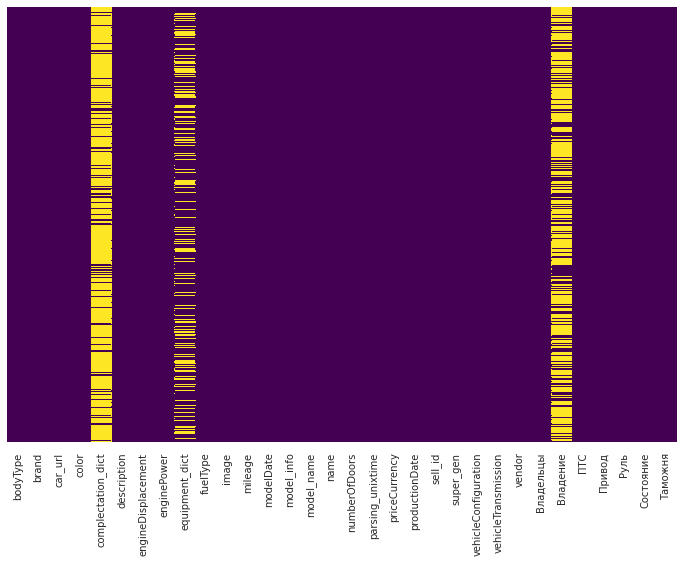

COMPLECTATION_DICT
%% пропущенных данных в столбце: 	81.0
(%% от общего кол-ва данных: 	3.0)

EQUIPMENT_DICT
%% пропущенных данных в столбце: 	29.0
(%% от общего кол-ва данных: 	1.0)

ВЛАДЕНИЕ
%% пропущенных данных в столбце: 	65.0
(%% от общего кол-ва данных: 	2.0)

ПТС
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)



In [12]:
na_values(test)

# Предобработка

## Подготовка для сбора обучающего датасета

In [13]:
# Уникальные пары brand - model_name
for_parsing = test[['brand','model_name']].drop_duplicates()
for_parsing.sample(3)

,brand,model_name
9143,BMW,340
20249,TOYOTA,ORIGIN
11499,NISSAN,NP300


In [14]:
# Проверка уникальности
for_parsing.model_name.value_counts().max()

1

In [15]:
# Выгрузка
for_parsing.to_csv('band_model.csv', index=False)

In [16]:
len(test.columns)

32

## Загрузка обучающей выборки

### Свежие данные

In [17]:
# Загрузка данных в переменные
DIR_TRAIN   = '../input/car-price-spring-2021/'
train = pd.read_csv(DIR_TRAIN+'extended_train.csv', index_col=0) # датасет для обучения модели

In [18]:
# Обзор тренировочного датасета с помощью pandas_profiling
# train_profile = ProfileReport(train, title='Train Report', html={'style':{'full_width':True}})
# train_profile.to_widgets()
# Мы спрятали код в комментарии, потому что он некорректно работает в ноутбуке на kaggle

In [19]:
pd.options.display.max_columns = train.shape[1]
train.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price_info
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,"{'id': '21151162', 'name': 'Style', 'available...","единственный собственник , куплена в июле 2016...",1.4 LTR,150 N12,"{'cruise-control': True, 'esp': True, 'adaptiv...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,70000.0,2013.0,"{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...",OCTAVIA,1.4 AMT (150 л.с.),5.0,1619648597,RUB,2016.0,1.102728e+09,"{'id': '9338208', 'name': 'III (A7)', 'ru_name...",LIFTBACK ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,4 года и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{'price': 1190000, 'currency': 'RUR', 'EUR': 1..."
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,{'id': '0'},Продаёт - Собственник.\nВыпуск - декабрь 2018г...,1.6 LTR,110 N12,"{'leather-gear-stick': True, 'esp': True, 'ptf...",бензин,https://autoru.naydex.net/jsB9Y6O22/7f4364z4/Y...,120000.0,2017.0,"{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...",OCTAVIA,1.6 AT (110 л.с.),5.0,1619648599,RUB,2018.0,1.103302e+09,"{'id': '20898195', 'name': 'III (A7) Рестайлин...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{'price': 980000, 'currency': 'RUR', 'EUR': 10..."
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серый,"{'id': '20803542', 'name': 'Ambition', 'availa...",Автомобиль в идеальном состоянии. Приобретен в...,1.8 LTR,180 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,https://autoru.naydex.net/jsB9Y6O22/7f4364z4/Y...,86000.0,2013.0,"{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...",OCTAVIA,1.8 MT (180 л.с.),5.0,1619648602,RUB,2013.0,1.103229e+09,"{'id': '9338208', 'name': 'III (A7)', 'ru_name...",LIFTBACK MECHANICAL 1.8,механическая,EUROPEAN,2 владельца,9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{'price': 1020000, 'currency': 'RUR', 'EUR': 1..."


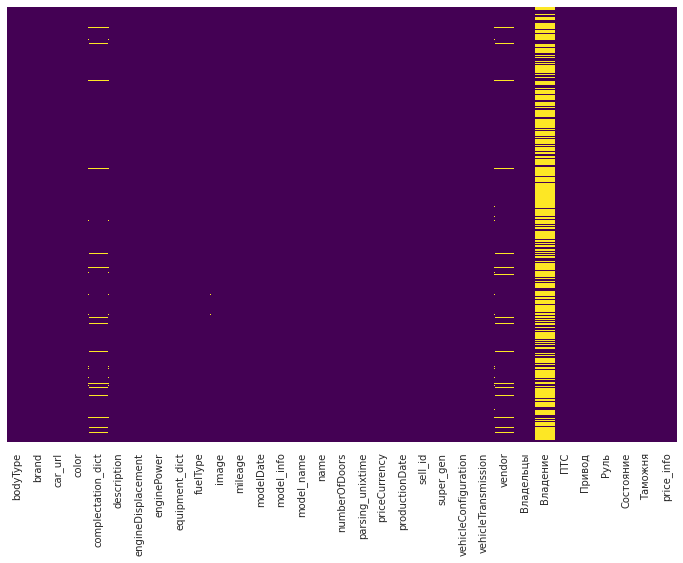

BODYTYPE
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

BRAND
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

COLOR
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

COMPLECTATION_DICT
%% пропущенных данных в столбце: 	3.0
(%% от общего кол-ва данных: 	0.0)

DESCRIPTION
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

ENGINEDISPLACEMENT
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

ENGINEPOWER
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

EQUIPMENT_DICT
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

FUELTYPE
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

IMAGE
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

MILEAGE
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

MODELDATE
%% пропущенных данных в столбце: 	0.0
(%% от общего кол

In [20]:
na_values(train)

В тренировочной выборке больше признаков с пропущенными данными, по сравнению с тестовой выборкой. Необходимо избавиться от пропусков.

In [21]:
# Заполним пропуски признака vendor на основе модели автомобиля
eur_vendor = ['SKODA', 'MERCEDES', 'BMW', 'VOLKSWAGEN', 'VOLVO', 'AUDI']

def fill_vendor(row):
    if pd.isnull(row['vendor']):
        if row['brand'] in eur_vendor:
            return 'EUROPEAN'
        else:
            return 'JAPANESE'
    return row['vendor']
    
train['vendor'] = train.apply(fill_vendor, axis = 1)

In [22]:
# Для дальнейшей корректной работы в признак 'complectation_dict' вместо Nan поставим пустые словари
train['complectation_dict'].fillna(train['complectation_dict'].value_counts().index[0], inplace = True)

In [23]:
# Создание списка признаков, по которым в тестовой выборке нет пропусков
cols_to_clean=[]
for col in train.drop('price_info', axis=1).columns:
    if len(test[col].isna().unique())==1:
        cols_to_clean.append(col)

In [24]:
# Очистка от пропусков
train.dropna(inplace=True, subset=cols_to_clean)

In [25]:
train.shape

(84218, 33)

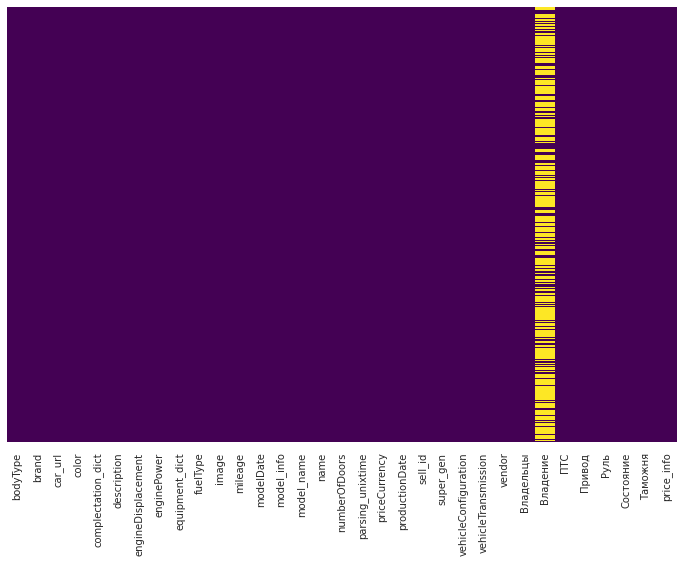

ВЛАДЕНИЕ
%% пропущенных данных в столбце: 	72.0
(%% от общего кол-ва данных: 	2.0)

ПТС
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)



In [26]:
na_values(train)

In [27]:
train.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price_info
9770,минивэн,TOYOTA,https://auto.ru/cars/used/sale/toyota/alphard/...,чёрный,"{'id': '20743391', 'name': 'Executive Lounge',...",Автомобиль приобретался у официального дилера ...,3.5 LTR,275 N12,"{'cruise-control': True, 'multi-wheel': True, ...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,67237.0,2015.0,"{'code': 'ALPHARD', 'name': 'Alphard', 'ru_nam...",ALPHARD,3.5 AT (275 л.с.),5.0,1619720134,RUB,2016.0,1.103135e+09,"{'id': '20478363', 'name': 'III', 'ru_name': '...",MINIVAN AUTOMATIC 3.5,автоматическая,JAPANESE,1 владелец,4 года и 5 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{'price': 3840000, 'currency': 'RUR', 'EUR': 4..."
10115,родстер,TOYOTA,https://auto.ru/cars/used/sale/toyota/mr2/1103...,чёрный,{'id': '0'},Левый руль. МКПП с завода. По технической част...,1.8 LTR,140 N12,"{'condition': True, 'abs': True, 'usb': True, ...",бензин,https://autoru.naydex.net/8q6jZcU25/19c30camuR...,135000.0,1999.0,"{'code': 'MR2', 'name': 'MR2', 'ru_name': 'МР ...",MR2,1.8 MT (140 л.с.),2.0,1619720988,RUB,2000.0,1.103127e+09,"{'id': '4995564', 'name': 'III (W30)', 'ru_nam...",ROADSTER MECHANICAL 1.8,механическая,JAPANESE,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,"{'price': 650000, 'currency': 'RUR', 'EUR': 72..."
35919,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1100557...,серый,{'id': '0'},Все вопросы по телефонуТорг при встрече,2.0 LTR,143 N12,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,206617.0,2001.0,"{'code': '3ER', 'name': '3 серии', 'ru_name': ...",3ER,318i 2.0 AT (143 л.с.),4.0,1620025433,RUB,2004.0,1.100558e+09,"{'id': '7690949', 'name': 'IV (E46) Рестайлинг...",SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,"{'price': 370000, 'currency': 'RUR', 'EUR': 40..."
29391,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/10974...,белый,{'id': '0'},"Авто в идеале, гаражное хранение, ошибок нет, ...",1.6 LTR,180 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,159000.0,2010.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,1.6 AT (180 л.с.),4.0,1619999696,RUB,2011.0,1.097437e+09,"{'id': '6478325', 'name': 'II', 'ru_name': '2'...",SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,3 или более,3 года и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{'price': 695000, 'currency': 'RUR', 'EUR': 76..."
8127,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/cla_kl...,серебристый,{'id': '0'},Только до конца этой недели. В РОЛЬФ Автопрайм...,2.0 LTR,360 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://autoru.naydex.net/8q6jZcU25/19c30camuR...,58076.0,2013.0,"{'code': 'CLA_KLASSE_AMG', 'name': 'CLA AMG', ...",CLA_KLASSE_AMG,45 AMG 2.0 AMT (360 л.с.) 4WD,4.0,1619715902,RUB,2015.0,1.102737e+09,"{'id': '10392956', 'name': 'I (C117, X117)', '...",SEDAN ROBOT 2.0,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,"{'price': 2207055, 'currency': 'RUR', 'EUR': 2..."


Отсутствие пропусков по 'complectation_dict' и 'equipment_dict' в тренировочной выборке объясняется наличаем пустых словарей.

In [28]:
# Удаление дубликатов
train.drop_duplicates(subset=['sell_id'], inplace=True)

## Преобразование строковых величин в словари

### Тренировочная выборка

In [29]:
# Преобразование
for col in ['complectation_dict', 'equipment_dict',
            'model_info', 'super_gen', 'price_info']:
    train[col] = train[col].apply(lambda x: ast.literal_eval(x))

### Тестовая выборка

In [30]:
# Функция возвращает словарь из строки
def str_to_dict(string):
    try:
        return json.loads(string)
    except:
        return None

In [31]:
# Применение функции str_to_dict
for col in ['complectation_dict', 'equipment_dict',
            'model_info', 'super_gen']:
    test[col] = test[col].apply(str_to_dict)

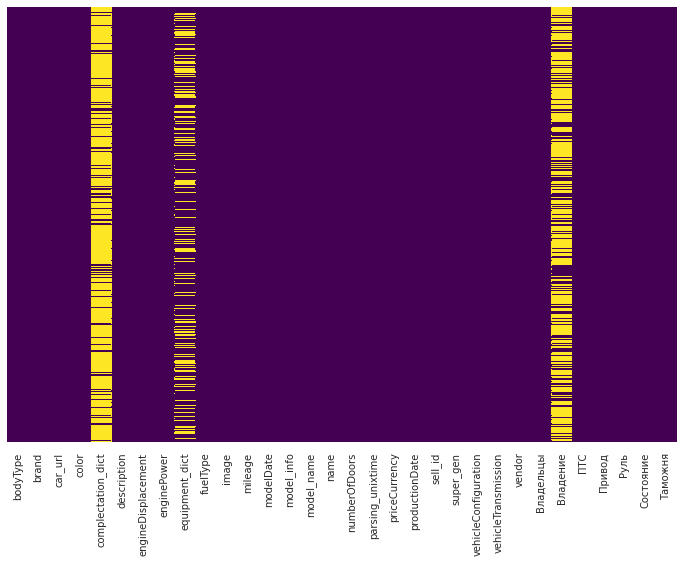

COMPLECTATION_DICT
%% пропущенных данных в столбце: 	81.0
(%% от общего кол-ва данных: 	3.0)

EQUIPMENT_DICT
%% пропущенных данных в столбце: 	29.0
(%% от общего кол-ва данных: 	1.0)

ВЛАДЕНИЕ
%% пропущенных данных в столбце: 	65.0
(%% от общего кол-ва данных: 	2.0)

ПТС
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)



In [32]:
na_values(test)

Пропорции пропусков остались прежними, функция отработала корректно.

In [33]:
# Создаем признак цены в тесте
default_price = "{'price': 0, 'currency': 'RUR', 'EUR': 0, 'RUR': 0, 'USD': 0, 'with_nds': False}"
test['price_info'] = default_price
test['price_info'] = test.price_info.apply(lambda x: ast.literal_eval(x))

## Совместная предобработка

In [34]:
# Создание метки тренировочной выборки
train['train'] = 1
test['train'] = 0

# Объединение выборок
data = train.append(test, sort=False).reset_index(drop=True)

In [35]:
data.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,...,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price_info,train
71072,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,чёрный,{'id': '0'},авто в отличном состоянии стоит новая резина н...,1.8 LTR,152 N12,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,188000.0,2011.0,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",PASSAT,1.8 AMT (152 л.с.),...,RUB,2012.0,1.098926e+09,"{'id': '7150225', 'name': 'B7', 'year_from': 2...",SEDAN ROBOT 1.8,роботизированная,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,"{'price': 600000, 'currency': 'RUR', 'EUR': 66...",1
108608,внедорожник 5 дв.,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/outl...,серый,"{'id': '21663830', 'name': 'Intense+ (7 мест)'...",Продаю свою ласточку. В связи покупкой квартиры.,2.0 LTR,146 N12,"{'cruise-control': True, 'tinted-glass': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,18000.0,2018.0,"{'code': 'OUTLANDER', 'name': 'Outlander', 'ru...",OUTLANDER,2.0 CVT (146 л.с.) 4WD,...,RUB,2019.0,1.101200e+09,"{'id': '21397559', 'displacement': 1998, 'engi...",ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,"{'price': 0, 'currency': 'RUR', 'EUR': 0, 'RUR...",0
72383,компактвэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/cadd...,красный,{'id': '0'},Не автосалон. НЕ АВТОДИЛЕР. \nПродаю свой авто...,1.6 LTR,102 N12,"{'engine-proof': True, 'asr': True, 'tinted-gl...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,215105.0,2004.0,"{'code': 'CADDY', 'name': 'Caddy', 'ru_name': ...",CADDY,1.6 MT (102 л.с.),...,RUB,2010.0,1.089633e+09,"{'id': '7915529', 'name': 'III', 'ru_name': '3...",COMPACTVAN MECHANICAL 1.6,механическая,EUROPEAN,3 или более,3 года и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{'price': 580000, 'currency': 'RUR', 'EUR': 64...",1
40926,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/terrano/...,серый,"{'id': '20770450', 'name': 'Elegance Plus', 'a...",Автомобиль продается от дилерского центра РРТ ...,2.0 LTR,143 N12,"{'engine-proof': True, 'tinted-glass': True, '...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,33320.0,2014.0,"{'code': 'TERRANO', 'name': 'Terrano', 'ru_nam...",TERRANO,2.0 MT (143 л.с.) 4WD,...,RUB,2018.0,1.103157e+09,"{'id': '20145592', 'name': 'III (D10)', 'ru_na...",ALLROAD_5_DOORS MECHANICAL 2.0,механическая,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,"{'price': 1150000, 'currency': 'RUR', 'EUR': 1...",1
52793,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/gls_kl...,чёрный,{'id': '0'},«ЛУКАВТО» – официальный дилер Mercedes-Benz в ...,2.9 LTR,330 N12,"{'body-kit': True, 'glonass': True, 'isofix': ...",дизель,https://autoru.naydex.net/iZe1e7630/ef5c48LR/h...,11.0,2019.0,"{'code': 'GLS_KLASSE', 'name': 'GLS', 'ru_name...",GLS_KLASSE,400 d 2.9d AT (330 л.с.) 4WD,...,RUB,2020.0,1.102376e+09,"{'id': '21600734', 'name': 'II (X167)', 'ru_na...",ALLROAD_5_DOORS AUTOMATIC 2.9,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,"{'price': 9690000, 'currency': 'RUR', 'EUR': 1...",1


Функции для обработки:

In [36]:
# Фунция возвращает ID комплектации
def get_comp_id(dictionary):
    try:
        return dictionary['id']
    except:
        return 0
    
# Фунция возвращает название комплектации
def get_comp_name(dictionary):
    try:
        return dictionary['name']
    except:
        return 'Not_specified'

# Фунция возвращает список опций в комплектации
def get_eqp_options(dictionary):
    try:
        return list(dictionary.keys())
    except:
        return None

# Фунция возвращает кол-во опций в комплектации
def get_eqp_amount(eqp_list):
    try:
        return len(eqp_list)
    except:
        return 0

# Фунция возвращает ценовой сегмент
def get_price_segment(dictionary):
    try:
        return dictionary['price_segment']
    except:
        return 'Not_specified'

# Фунция возвращает время владения в месяцах
def get_own_time(string):
    months = 0
    if type(string) == str:
        numbers = re.findall(r'\d+', string)
        if len(numbers) == 2:
            months += int(numbers[0])*12 + int(numbers[1])
        else:
            if 'месяц' in string:
                months += int(numbers[0])
            else:
                months += int(numbers[0])*12
    return months

# Фунция возвращает цену в рублях
def get_rur_price(dictionary):
    try:
        return dictionary['RUR']
    except:
        return None

# Фунция возвращает цену в евро
def get_eur_price(dictionary):
    try:
        return dictionary['EUR']
    except:
        return None

# Фунция возвращает цену в долларах
def get_usd_price(dictionary):
    try:
        return dictionary['USD']
    except:
        return None

Обработка:

In [37]:
# Извлечение информации из словарей
data['comp_id'] = data['complectation_dict'].apply(get_comp_id)
data['comp_name'] = data['complectation_dict'].apply(get_comp_name)
data['eqp_options'] = data['equipment_dict'].apply(get_eqp_options)
data['eqp_amount'] = data['eqp_options'].apply(get_eqp_amount)
data['price_segment'] = data['super_gen'].apply(get_price_segment)
data['gen_id'] = data['super_gen'].apply(lambda x: x['id'])
data['rur_price'] = data['price_info'].apply(get_rur_price)
data['eur_price'] = data['price_info'].apply(get_eur_price)
data['usd_price'] = data['price_info'].apply(get_usd_price)

# Извлечение информации из строк
data['eng_volume'] = data['engineDisplacement'].apply(lambda x: float('0'+x[:str.find(x,' ')]))
data['eng_pwr'] = data['enginePower'].apply(lambda x: int(x[:str.find(x,' ')]))
data['own_time'] = data['Владение'].apply(get_own_time)

# Даты
data['parsing_datetime'] = pd.to_datetime(data['parsing_unixtime'],unit='s')

# Правки
data['Владельцы'] = data['Владельцы'].str.replace('\xa0',' ')

# Удаление
data.drop(['car_url','complectation_dict','engineDisplacement',
           'enginePower', 'equipment_dict', 'image','model_info',
           'name', 'priceCurrency','super_gen','vehicleConfiguration',
           'Владение', 'Состояние', 'Таможня', 'price_info'], 
          axis=1, inplace = True)

In [38]:
data.sample(5)

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,train,comp_id,comp_name,eqp_options,eqp_amount,price_segment,gen_id,rur_price,eur_price,usd_price,eng_volume,eng_pwr,own_time,parsing_datetime
109924,универсал 5 дв.,MITSUBISHI,красный,ЦЕНА ТАКАЯ В ТЕЧЕНИИ 5 дней. \nЗатем ставлю ка...,бензин,325000.0,2000.0,LANCER,5.0,1603268237,2005.0,1.093086e+09,механическая,JAPANESE,3 или более,Оригинал,передний,Левый,0,0,Not_specified,None,0,Not_specified,2334589,0.0,0.0,0.0,2.0,135,36,2020-10-21 08:17:17
2676,хэтчбек 3 дв.,VOLVO,серебристый,"Диллерский центр Рольф (для вас персонально, т...",бензин,75000.0,2010.0,C30,3.0,1619684637,2010.0,1.102871e+09,автоматическая,EUROPEAN,2 владельца,Оригинал,передний,Левый,1,6060757,Т5 R-Design,"[cruise-control, tinted-glass, esp, adaptive-l...",55,PREMIUM,6060645,1150000.0,12717.0,15346.0,2.5,230,8,2021-04-29 08:23:57
9718,внедорожник 5 дв.,TOYOTA,чёрный,Ваш выбор и Ваше время — наши главные приорите...,дизель,4570.0,2020.0,FORTUNER,5.0,1619720020,2020.0,1.102807e+09,автоматическая,JAPANESE,1 владелец,Оригинал,полный,Левый,1,0,Not_specified,"[cruise-control, asr, usb, multi-wheel, airbag...",49,MEDIUM,22457016,3635000.0,40321.0,48869.0,2.8,200,0,2021-04-29 18:13:40
28961,универсал 5 дв.,VOLVO,синий,"Машина в хорошем состоянии , установлен контра...",дизель,265000.0,2007.0,XC70,5.0,1620000446,2012.0,1.103327e+09,автоматическая,EUROPEAN,3 или более,Оригинал,полный,Левый,1,0,Not_specified,"[cruise-control, tinted-glass, esp, airbag-dri...",29,PREMIUM,2310029,1160000.0,12806.0,15499.0,2.4,215,0,2021-05-03 00:07:26
55491,седан,MERCEDES,серый,Продается мерседес 190 (w201) 1992г.в. Автомоб...,бензин,272000.0,1982.0,W201,4.0,1620206008,1992.0,1.099929e+09,механическая,EUROPEAN,3 или более,Дубликат,задний,Левый,1,0,Not_specified,[],0,PREMIUM,8259491,313000.0,3460.0,4159.0,1.8,109,33,2021-05-05 09:13:28


In [39]:
# Проверка на наличие целевой переменной
data[data.rur_price.isna()==True]

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,train,comp_id,comp_name,eqp_options,eqp_amount,price_segment,gen_id,rur_price,eur_price,usd_price,eng_volume,eng_pwr,own_time,parsing_datetime
17,лифтбек,SKODA,чёрный,Ваш выбор и Ваше время — наши главные приорите...,бензин,149500.0,2008.0,OCTAVIA,5.0,1619648639,2013.0,1.102848e+09,роботизированная,EUROPEAN,3 или более,Оригинал,передний,Левый,1,0,Not_specified,"[electro-window-back, asr, tinted-glass, leath...",22,MEDIUM,4560887,NaN,NaN,NaN,1.4,122,0,2021-04-28 22:23:59
21,лифтбек,SKODA,коричневый,Автомобиль куплен в январе 2020 года у оф. дил...,бензин,16500.0,2017.0,OCTAVIA,5.0,1619648649,2020.0,1.103226e+09,автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый,1,21403777,Hockey Edition,"[cruise-control, esp, adaptive-light, usb, mul...",66,MEDIUM,20898195,NaN,NaN,NaN,1.6,110,15,2021-04-28 22:24:09
43,лифтбек,SKODA,белый,"Как человек, поездивший на множестве авто, зая...",бензин,132000.0,2008.0,SUPERB,5.0,1619648705,2012.0,1.101742e+09,автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый,1,2436032,Elegance,"[cruise-control, asr, esp, adaptive-light, usb...",66,MEDIUM,2309235,NaN,NaN,NaN,1.8,152,102,2021-04-28 22:25:05
64,универсал 5 дв.,SKODA,синий,#cme1039-№2918-11210020a5bb11ebae4730e17163fbd...,бензин,171363.0,2008.0,SUPERB,5.0,1619648761,2012.0,1.103342e+09,роботизированная,EUROPEAN,1 владелец,Оригинал,передний,Левый,1,0,Not_specified,"[abs, rain-sensor, light-sensor, cruise-contro...",64,MEDIUM,2309235,NaN,NaN,NaN,2.0,200,0,2021-04-28 22:26:01
120,внедорожник 5 дв.,SKODA,серый,Автомобиль продается от официального дилерског...,бензин,164193.0,2013.0,YETI,5.0,1619648883,2015.0,1.102816e+09,роботизированная,EUROPEAN,2 владельца,Оригинал,полный,Левый,1,20805791,Ambition,"[abs, esp, asr, computer, rain-sensor, light-s...",26,MEDIUM,20078038,NaN,NaN,NaN,1.8,152,0,2021-04-28 22:28:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80970,седан,TOYOTA,золотистый,Год выпуска: 2000. Пробег: 150 000 км. Кузов: ...,бензин,150000.0,1999.0,PLATZ,4.0,1620371532,2000.0,1.101385e+09,автоматическая,JAPANESE,2 владельца,Оригинал,передний,Правый,1,0,Not_specified,[],0,MEDIUM,8302962,NaN,NaN,NaN,1.0,70,0,2021-05-07 07:12:12
80990,седан,TOYOTA,серебристый,Продаю надёжного японца. 2 владельца по птс. П...,бензин,223000.0,1999.0,PLATZ,4.0,1620371596,2000.0,1.101334e+09,автоматическая,JAPANESE,2 владельца,Оригинал,передний,Правый,1,0,Not_specified,[],0,MEDIUM,8302962,NaN,NaN,NaN,1.5,110,201,2021-05-07 07:13:16
80996,седан,TOYOTA,серый,"ПТС оригинал, выдан Владивостокской таможней, ...",бензин,100550.0,1999.0,PLATZ,4.0,1620371614,2002.0,1.103379e+09,автоматическая,JAPANESE,2 владельца,Оригинал,передний,Правый,1,0,Not_specified,"[feedback-alarm, lock, audiosystem-cd, 12v-soc...",19,MEDIUM,8302962,NaN,NaN,NaN,1.5,110,0,2021-05-07 07:13:34
81012,седан,TOYOTA,белый,"продам, в нармальном состоянии автомобиль двиг...",бензин,260000.0,1999.0,PLATZ,4.0,1620371666,2001.0,1.103024e+09,автоматическая,JAPANESE,3 или более,Дубликат,передний,Правый,1,0,Not_specified,[],0,MEDIUM,8302962,NaN,NaN,NaN,1.5,110,0,2021-05-07 07:14:26


In [40]:
# Проверка на то, что целевая пропущена только в тренировочной выборке
data[data.rur_price.isna()==True].train.unique()

array([1])

In [41]:
# Удаление пропущенных значений
data.dropna(subset=['rur_price'], axis=0, inplace = True)

### Добавление старой тренировочной выборки

In [42]:
# Загрузка данных в переменные
DIR_OLD_TRAIN   = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
old_train = pd.read_csv(DIR_OLD_TRAIN+'all_auto_ru_09_09_2020.csv')

In [43]:
pd.options.display.max_columns = old_train.shape[1]
old_train.head(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100


In [44]:
# Проверка на избыточность брендов в старой тренировочной выборке
len(old_train.brand.unique()) - len(for_parsing.brand.unique())

24

In [45]:
# Очистка
useful_brands = for_parsing.brand.unique()
for_processing = old_train[old_train.brand == useful_brands[0]]
for brand in tqdm(useful_brands[1:]):
    for_processing = for_processing.append(old_train[old_train.brand == brand], sort=False).reset_index(drop=True)
old_train = for_processing

In [46]:
# Проверка на избыточность брендов в старой тренировочной выборке
len(old_train.brand.unique()) - len(for_parsing.brand.unique())

0

Время парсинга (предположительно start_date):

In [47]:
# Преобразование в datetime
old_train['start_date'] = old_train.start_date.progress_apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))

In [48]:
# Преобразование в unixtimestamp
old_train['parsing_unixtime'] = old_train.start_date.progress_apply(lambda x: x.value/(10**9))

In [49]:
# Минимальное и максимальное значения
display(old_train[old_train.parsing_unixtime==old_train.parsing_unixtime.max()]['start_date'])
display(old_train[old_train.parsing_unixtime==old_train.parsing_unixtime.min()]['start_date'])

30554    2020-09-09 10:38:32
Name: start_date, dtype: object

1523    2014-06-10 06:27:00
Name: start_date, dtype: object

Судя по разбросу в несколько лет, start_date - дата размещения объявления. В таком случае, время парсинга примерно равно дате размещения последнего объявления.

Преобразование параметров 'Комплектация' и 'Владение':

In [50]:
def get_dict(string):
    try:
        return ast.literal_eval(string)
    except:
        return None

In [51]:
# Преобразование
old_train['Комплектация'] = old_train['Комплектация'].apply(lambda x: ast.literal_eval(x))
old_train['Владение'] = old_train['Владение'].apply(get_dict)

#### Создание датафрейма в формате основных данных:

In [52]:
old_train.head(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,...,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model,parsing_unixtime
0,Седан,SKODA,FAFBFB,бензин,1969.0,100 1.0 MT (42 л.с.),4.0,1976,SEDAN MECHANICAL 100,MECHANICAL,100,42.0,"На автомобиль получен новый ПТС, СТС и государ...",...,{'id': '0'},задний,LEFT,NaN,1.0,ORIGINAL,True,"{'year': 1992, 'month': 2}",150000.0,2020-03-01 04:18:19,NaN,100_SERIES,1.583036e+09
1,Седан 120,SKODA,C49648,бензин,1976.0,1.2 MT (53 л.с.),4.0,1984,SEDAN MECHANICAL 1.2,MECHANICAL,1.2,53.0,120L 52 л.с. в России таких нет! состояние отл...,...,{'id': '0'},задний,LEFT,NaN,2.0,ORIGINAL,True,"{'year': 2012, 'month': 4}",170000.0,2019-03-28 15:13:10,NaN,120,1.553786e+09
2,Хэтчбек 5 дв.,SKODA,040001,бензин,2010.0,1.2 MT (70 л.с.),5.0,2012,HATCHBACK_5_DOORS MECHANICAL 1.2,MECHANICAL,1.2,70.0,Автомобиль по тех состоянию без нареканий. Куз...,...,{'id': '0'},передний,LEFT,NaN,2.0,ORIGINAL,True,"{'year': 2020, 'month': 2}",250000.0,2020-08-20 07:41:09,NaN,FABIA,1.597909e+09


In [53]:
pd.options.display.max_columns = data.shape[1]
data.sample(3)

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,train,comp_id,comp_name,eqp_options,eqp_amount,price_segment,gen_id,rur_price,eur_price,usd_price,eng_volume,eng_pwr,own_time,parsing_datetime
41011,внедорожник 5 дв.,NISSAN,бежевый,Собственник. Машина декабря 2014 года. Имеет р...,бензин,30000.0,2014.0,TERRANO,5.0,1620049275,2014.0,1.102142e+09,автоматическая,JAPANESE,3 или более,Оригинал,передний,Левый,1,0,Not_specified,"[engine-proof, tinted-glass, esp, airbag-drive...",26,ECONOMY,20145592,795000.0,8776.0,10622.0,2.0,135,10,2021-05-03 13:41:15
57033,внедорожник 5 дв.,TOYOTA,чёрный,Автомобиль в наличии по адресу: г. Cтерлитамак...,бензин,160000.0,2010.0,RAV_4,5.0,1620213165,2011.0,1.103242e+09,вариатор,JAPANESE,3 или более,Оригинал,полный,Левый,1,0,Not_specified,"[asr, tinted-glass, esp, airbag-driver, aux, u...",45,MEDIUM,7277925,1170000.0,12935.0,15547.0,2.0,148,12,2021-05-05 11:12:45
53137,внедорожник 5 дв.,MERCEDES,белый,Полностью обслужен\nВ прекрасном состоянии,бензин,187000.0,2012.0,GLK_KLASSE,5.0,1620198747,2014.0,1.103286e+09,автоматическая,EUROPEAN,3 или более,Оригинал,полный,Левый,1,0,Not_specified,"[cruise-control, tinted-glass, esp, aux, light...",29,PREMIUM,8225450,1295000.0,14317.0,17208.0,2.0,211,0,2021-05-05 07:12:27


In [54]:
# Фунция возвращает объем двигателя из name
def get_eng_pwr(string):
    try:
        liters = re.findall(r'\d+', string[:str.find(string,'.')])[-1]
        decimals = re.findall(r'\d+', string[str.find(string,'.'):])[0]
        return float(liters+'.'+decimals)
    except:
        return 0

# Фунция возвращает время владения в месяцах
def get_own_time(dictinonary):
    months = 0
    if type(dictinonary) == dict:
        months += (2020 - dictinonary['year'])*12
        months += (9 - dictinonary['month'])
    return months

In [55]:
# Обработка старой тренировочной выборки
adj_old_train = pd.DataFrame()
old_train['bodyType'] = old_train['bodyType'].apply(lambda x: str(x))
adj_old_train['bodyType'] = old_train['bodyType'].apply(lambda x: x.lower())
adj_old_train['brand'] = old_train['brand']

mapping_dict = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
                'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
                '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
                '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
                '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
                'FFC0CB':'розовый'}
adj_old_train['color'] = old_train['color'].map(mapping_dict)

for col in ['description', 'fuelType', 'mileage', 'modelDate']:
    adj_old_train[col] = old_train[col]
adj_old_train['model_name'] = old_train['model']
adj_old_train['numberOfDoors'] = old_train['numberOfDoors']
adj_old_train['parsing_unixtime'] = old_train['parsing_unixtime'].max()
adj_old_train['productionDate'] = old_train['productionDate']
adj_old_train['sell_id'] = None

mapping_dict = {'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 
                'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
adj_old_train['vehicleTransmission'] = old_train['vehicleTransmission'].map(mapping_dict)

mapping_series = data.groupby('brand').vendor.unique()
mapping_dict = {}
for brand in mapping_series.index:
    mapping_dict[brand] = mapping_series[brand][0]
adj_old_train['vendor'] = old_train['brand'].map(mapping_dict)

mapping_dict = {1.:'1 владелец', 2.:'2 владельца', 
                3.:'3 или более'}
adj_old_train['Владельцы'] = old_train['Владельцы'].map(mapping_dict)

mapping_dict = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
adj_old_train['ПТС'] = old_train['ПТС'].map(mapping_dict)

adj_old_train['Привод'] = old_train['Привод']

mapping_dict = {'LEFT':'Левый', 'RIGHT':'Правый'}
adj_old_train['Руль'] = old_train['Руль'].map(mapping_dict)

adj_old_train['train'] = 1

adj_old_train['comp_id'] = old_train['Комплектация'].apply(get_comp_id)
adj_old_train['comp_name'] = old_train['Комплектация'].apply(get_comp_name)
adj_old_train['eqp_options'] = None
adj_old_train['eqp_amount'] = None
adj_old_train['price_segment'] = None
adj_old_train['gen_id'] = None
adj_old_train['rur_price'] = old_train['price']
# Курсы валюты взяты вручную с сайта ЦБ РФ, т.к. не имеет смысла делать парсинг ради 2ух значений
adj_old_train['eur_price'] = old_train['price'].apply(lambda x: np.round(x/89.7369))
adj_old_train['usd_price'] = old_train['price'].apply(lambda x: np.round(x/75.9645))
adj_old_train['eng_volume'] = old_train['name'].apply(get_eng_pwr)
adj_old_train['eng_pwr'] = old_train['enginePower']
adj_old_train['own_time'] = old_train['Владение'].apply(get_own_time)
adj_old_train['parsing_datetime'] = pd.to_datetime(adj_old_train['parsing_unixtime'],unit='s')

In [56]:
adj_old_train.sample(3)

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,train,comp_id,comp_name,eqp_options,eqp_amount,price_segment,gen_id,rur_price,eur_price,usd_price,eng_volume,eng_pwr,own_time,parsing_datetime
13101,седан,BMW,белый,NaN,бензин,200000,1987.0,5ER,4.0,1.599648e+09,1988,None,автоматическая,EUROPEAN,3 или более,Оригинал,задний,Левый,1,0,Not_specified,None,None,None,None,120000.0,1337.0,1580.0,2.5,170.0,183,2020-09-09 10:38:32
9065,внедорожник 5 дв.,VOLVO,серебристый,———————————————————————————\nФУНКЦИОНАЛЬНОЕ ОБ...,бензин,0,2017.0,XC60,5.0,1.599648e+09,2020,None,автоматическая,EUROPEAN,NaN,Оригинал,полный,Левый,1,21158446,Momentum (MY17-20),None,None,None,None,3621000.0,40351.0,47667.0,2.0,249.0,0,2020-09-09 10:38:32
22808,внедорожник 5 дв.,NISSAN,белый,У Сервис+ NISSAN - лучший дилер ДВУХ столиц п...,бензин,0,2017.0,X_TRAIL,5.0,1.599648e+09,2020,None,вариатор,JAPANESE,NaN,Оригинал,передний,Левый,1,21436617,SE,None,None,None,None,1920000.0,21396.0,25275.0,2.0,144.0,0,2020-09-09 10:38:32


In [57]:
# Проверка, что столбцы совпадают с основным датасетом
cols_check = []
for i in range(len(data.columns)):
    cols_check.append(data.columns[i]==adj_old_train.columns[i])
print(np.unique(cols_check))

[ True]


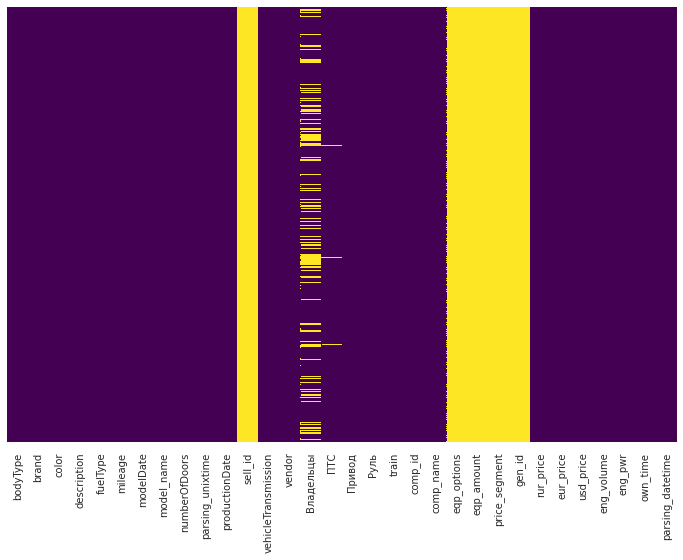

SELL_ID
%% пропущенных данных в столбце: 	100.0
(%% от общего кол-ва данных: 	3.0)

ВЛАДЕЛЬЦЫ
%% пропущенных данных в столбце: 	23.0
(%% от общего кол-ва данных: 	1.0)

ПТС
%% пропущенных данных в столбце: 	1.0
(%% от общего кол-ва данных: 	0.0)

EQP_OPTIONS
%% пропущенных данных в столбце: 	100.0
(%% от общего кол-ва данных: 	3.0)

EQP_AMOUNT
%% пропущенных данных в столбце: 	100.0
(%% от общего кол-ва данных: 	3.0)

PRICE_SEGMENT
%% пропущенных данных в столбце: 	100.0
(%% от общего кол-ва данных: 	3.0)

GEN_ID
%% пропущенных данных в столбце: 	100.0
(%% от общего кол-ва данных: 	3.0)



In [58]:
# Очистка от пропусков
adj_old_train.dropna(inplace=True, subset=['description', 'modelDate', 'numberOfDoors', 
                                           'vehicleTransmission', 'Привод', 'rur_price', 
                                           'eur_price', 'usd_price', 'eng_pwr'])

na_values(adj_old_train)

Внесение в основной датасет:

In [59]:
# Объединение выборок
data = data.append(adj_old_train, sort=False).reset_index(drop=True)

Доля тренировочной выборки в итоговом датасете:

In [60]:
np.round(data[data.train==1].shape[0]/data.shape[0],2)

0.78

Разметка переменных:

In [61]:
# Предварительная разметка
bin_cols = []
cat_cols = []
dat_cols = []
num_cols = []

for column in data.drop('eqp_options', axis=1).columns:
    if len(data[column].unique()) == 2:
        bin_cols.append(column)
    elif data[column].dtype == 'datetime64[ns]':
        dat_cols.append(column)
    elif (data[column].dtype == float)|(data[column].dtype == int):
        num_cols.append(column)
    else:
        cat_cols.append(column)

print('Бинарные данные: \t', bin_cols)
print()
print('Категориальные данные: \t', cat_cols)
print()
print('Время/дата: \t\t', dat_cols)
print()
print('Числовые данные: \t', num_cols)

Бинарные данные: 	 ['vendor', 'Руль', 'train']

Категориальные данные: 	 ['bodyType', 'brand', 'color', 'description', 'fuelType', 'model_name', 'sell_id', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'comp_id', 'comp_name', 'eqp_amount', 'price_segment', 'gen_id']

Время/дата: 		 ['parsing_datetime']

Числовые данные: 	 ['mileage', 'modelDate', 'numberOfDoors', 'parsing_unixtime', 'productionDate', 'rur_price', 'eur_price', 'usd_price', 'eng_volume', 'eng_pwr', 'own_time']


In [62]:
# Метка тренировочной выборки не является бинарным признаком
bin_cols.remove('train')

# Текстовые переменные (description, eqp_options) будут обработаны отдельно
# ID авто необходимо только для submission
for col in ['description', 'sell_id']:
    cat_cols.remove(col)

# Наивная модель

Для промежуточного моделирования будет использован алгоритм CatBoost по следующим причинам:
- Алгоритм работает с пропусками в данных
- Показывает высокую эффективность на категориальных данных, которых в датасете большинство
- Не требует предобработки категориальных переменных
- Низкий разброс результатов, что позволяет использовать алгоритм с дефолтными гиперпараметрами

In [63]:
# Функция возвращает метрики для данных и модели
def metics(data, target, model=CatBoostRegressor(random_seed = RS, silent=True)):
    df = data.copy()
    
    # Кодирование
    LE = LabelEncoder()
    for col in bin_cols+cat_cols:
        if df[col].dtype == object:
            df[col] = df[col].fillna('Non_specified')
            df[col] = df[col].apply(lambda x: str(x))
            df[col] = LE.fit_transform(df[col])
    
    # Разделение переменных
    X = df[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values
    y = df[target].values
    
    # Создание списков для записи локальных результатов
    local_mape = []
    local_mae = []
    local_mse = []
    
    # Моделирование с 3-ой кросс-валидацией
    SKF = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)
    for train_index, test_index in SKF.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        local_mape.append(MAPE(y_test, preds))
        local_mae.append(mean_absolute_error(y_test, preds))
        local_mse.append(mean_squared_error(y_test, preds)**(1/2))
    
    # Усреднение метрик
    result = []
    result.append(np.mean(local_mape))
    result.append(np.mean(local_mae))
    result.append(np.mean(local_mse))
    
    return result

In [64]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

results = pd.DataFrame({'naive': metics(data[data.train==1], 'rur_price')}, 
                       index = ['MAPE','MAE','RMSE'])
results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,naive
MAPE,0.1744
MAE,150333.7260
RMSE,443434.7237


Наивная модель в среднем ошибается на 17.43%(MAPE) или на 150 100 руб(MAE). Вместе с тем отклонение квадратного кореня из среднеквадратичной ошибки (RMSE) выше среднего более чем в 2 раза, что говорит о том, что модель особенно плохо предсказывает некоторые примеры.

## Выбор целевой

In [65]:
# Функция возвращает визуализацию результатов
def plot_results(results, target_metric):
    MMS = MinMaxScaler()
    trans_res = results.T
    scaled_res = pd.DataFrame(MMS.fit_transform(trans_res), 
                              columns=trans_res.columns, index=trans_res.index)
    
    fig, axs = plt.subplots(figsize=(15, 7), gridspec_kw={'height_ratios': [5, 1]}, nrows=2)
    sns.lineplot(x=results.columns, y=results.loc[target_metric].values, 
                 marker='o', sort = False, ax=axs[0])
    axs[0].set(ylabel=target_metric, xlabel='ITER')
    sns.lineplot(data = scaled_res, marker='o', 
                          sort = False, palette='viridis', ax=axs[1])
    plt.legend(loc='upper left')
    axs[1].set(ylabel='All Metrics', xlabel='ITER')
    plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


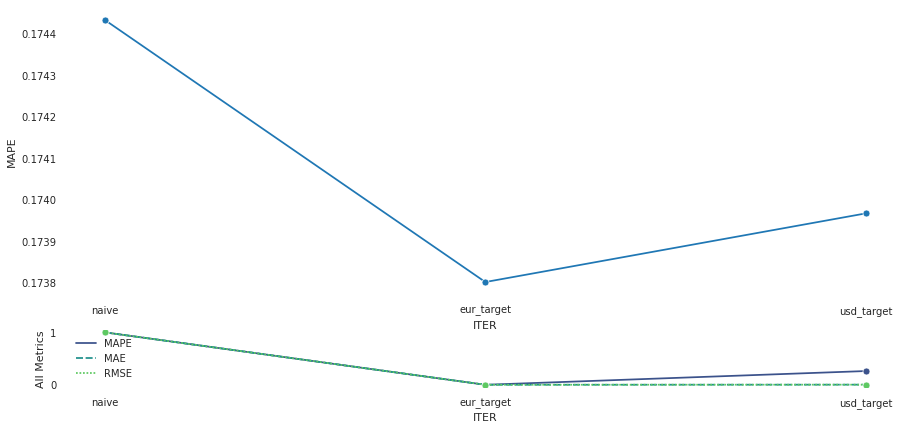

,naive,eur_target,usd_target
MAPE,0.1744,0.1738,0.1740
MAE,150333.7260,1664.7240,1996.3549
RMSE,443434.7237,4951.5050,5853.0802


In [66]:
# Расчет и запись метрик
results['eur_target'] = metics(data[data.train==1], 'eur_price')
results['usd_target'] = metics(data[data.train==1], 'usd_price')

# Визуализация
plot_results(results, 'MAPE')
results

По-видимому, наименее волатильна цена в евро. Это и будет целевой переменной, которую при финальном предсказании перевернем в рубль.

In [67]:
# Удаление промежуточных шагов
results.drop(['naive', 'eur_target', 'usd_target'], axis=1, inplace=True)

# Расчет и запись метрик
results['target_set'] = metics(data[data.train==1], 'eur_price')

# Визуализация
results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,target_set
MAPE,0.1738
MAE,1664.7240
RMSE,4951.5050


# EDA

## Бинарные данные

In [68]:
# Функция, проверяющая наличие статистически значимых различий между вариациями признака
def get_stat_dif(df, col, target):
    variations=len(df[col].value_counts().index)
    indexes=[i for i in range (0,variations)]
    comb=list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]][target]
        y = df[df[col] == df[col].value_counts().index[c[1]]][target]
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            return True
        else:
            return False

In [69]:
# Функция выводит основную информацию, визуализацию пропорций в тренировочной выборке и сравнение с тестовой
def sum_up_cat(df, col, target, label='train'):
    print(col.upper())
    train = df[df[label]==1]
    trn = train[col].value_counts(normalize=True)
    tst = df[df[label]==0][col].value_counts(normalize=True)
    vc = train[col].value_counts()
    changes = pd.DataFrame({'train':trn, 'test':tst})
    for i in vc.index:
        print('{} (%%):\t{}'.format(i, np.round(trn[i],2)))
        print('\t Среднее значение целевой:\t{}'.format(np.round(train[train[col] == i][target].mean(),2)))
    print('Cтатистически значимые различия:\t{}'.format(get_stat_dif(train, col, target)))
    fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
    sns.barplot(x=vc.index, y=vc.values, palette='viridis', ax=axs[0])
    if len(train[col].unique())>5:
        axs[0].tick_params(labelrotation=45)
    sns.lineplot(data=changes, palette='viridis', linewidth=3, ax=axs[1])
    if len(changes.index)>5:
        axs[1].tick_params(labelrotation=45)
    plt.show()

VENDOR
EUROPEAN (%%):	0.53
	 Среднее значение целевой:	20116.2
JAPANESE (%%):	0.47
	 Среднее значение целевой:	10384.05
Cтатистически значимые различия:	True


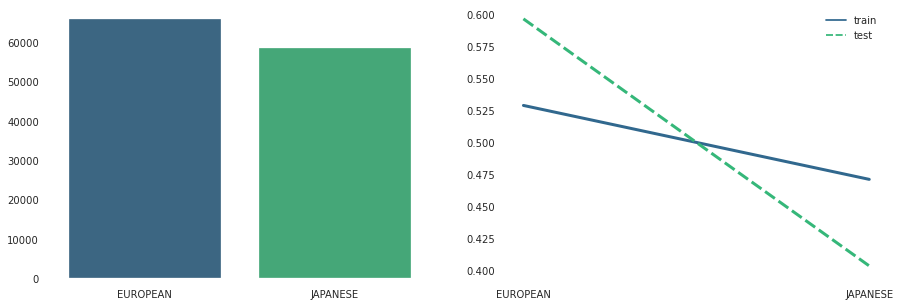

РУЛЬ
Левый (%%):	0.85
	 Среднее значение целевой:	17429.52
Правый (%%):	0.15
	 Среднее значение целевой:	4385.73
Cтатистически значимые различия:	True


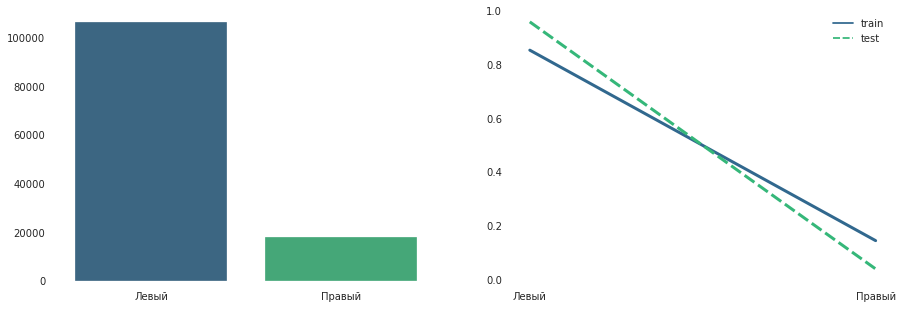

In [70]:
for column in bin_cols:
    sum_up_cat(data, column, 'eur_price')

Для данных переменных найдены статистически значимые различия.

В тренировочной выборке больше авто с правым рулем японских производителей по сравнению с тестовой.

## Категориальные данные

BRAND
NISSAN (%%):	0.15
	 Среднее значение целевой:	7551.08
TOYOTA (%%):	0.15
	 Среднее значение целевой:	11246.55
MERCEDES (%%):	0.13
	 Среднее значение целевой:	32496.76
BMW (%%):	0.11
	 Среднее значение целевой:	25374.96
VOLKSWAGEN (%%):	0.11
	 Среднее значение целевой:	11000.91
AUDI (%%):	0.08
	 Среднее значение целевой:	14753.65
MITSUBISHI (%%):	0.08
	 Среднее значение целевой:	8753.73
SKODA (%%):	0.05
	 Среднее значение целевой:	8454.95
HONDA (%%):	0.05
	 Среднее значение целевой:	6416.85
VOLVO (%%):	0.04
	 Среднее значение целевой:	15418.96
LEXUS (%%):	0.03
	 Среднее значение целевой:	26244.29
INFINITI (%%):	0.02
	 Среднее значение целевой:	17176.77
Cтатистически значимые различия:	True


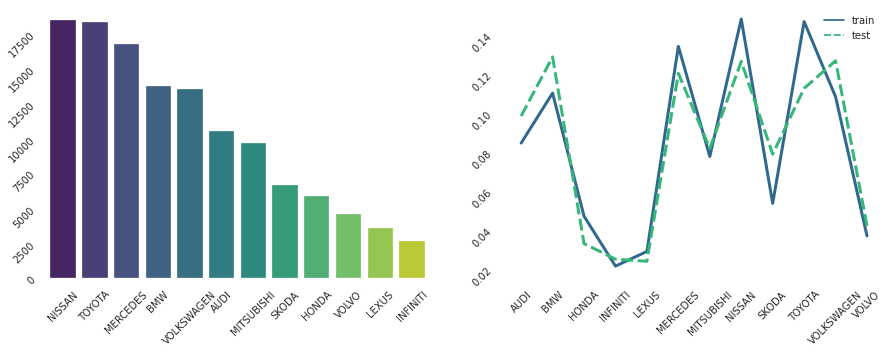

FUELTYPE
бензин (%%):	0.8
	 Среднее значение целевой:	13042.44
дизель (%%):	0.18
	 Среднее значение целевой:	26570.64
гибрид (%%):	0.01
	 Среднее значение целевой:	13493.66
электро (%%):	0.0
	 Среднее значение целевой:	16407.66
газ (%%):	0.0
	 Среднее значение целевой:	6480.18
Cтатистически значимые различия:	True


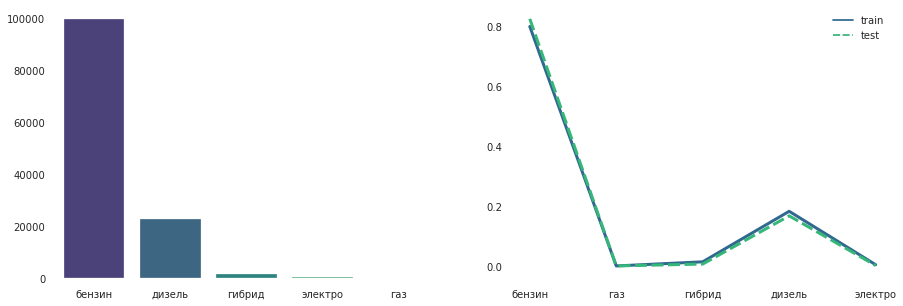

VEHICLETRANSMISSION
автоматическая (%%):	0.57
	 Среднее значение целевой:	19472.44
механическая (%%):	0.21
	 Среднее значение целевой:	5504.71
вариатор (%%):	0.12
	 Среднее значение целевой:	12504.0
роботизированная (%%):	0.1
	 Среднее значение целевой:	17453.02
Cтатистически значимые различия:	True


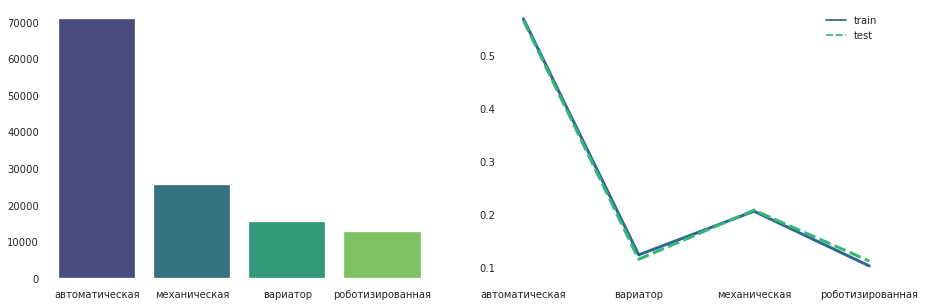

ВЛАДЕЛЬЦЫ
3 или более (%%):	0.52
	 Среднее значение целевой:	7649.55
1 владелец (%%):	0.25
	 Среднее значение целевой:	21935.05
2 владельца (%%):	0.24
	 Среднее значение целевой:	14564.71
Cтатистически значимые различия:	True


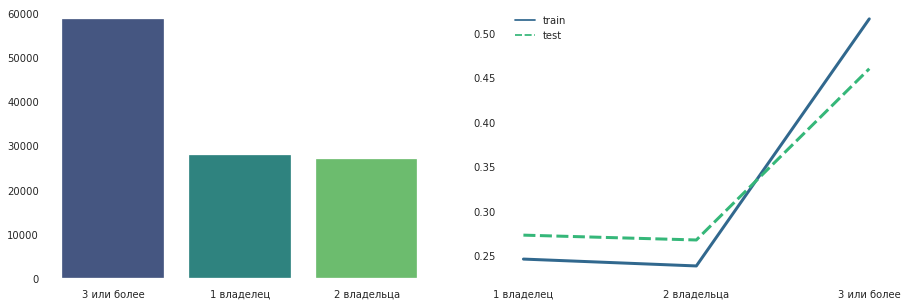

ПТС
Оригинал (%%):	0.85
	 Среднее значение целевой:	16930.6
Дубликат (%%):	0.15
	 Среднее значение целевой:	7006.02
Cтатистически значимые различия:	True


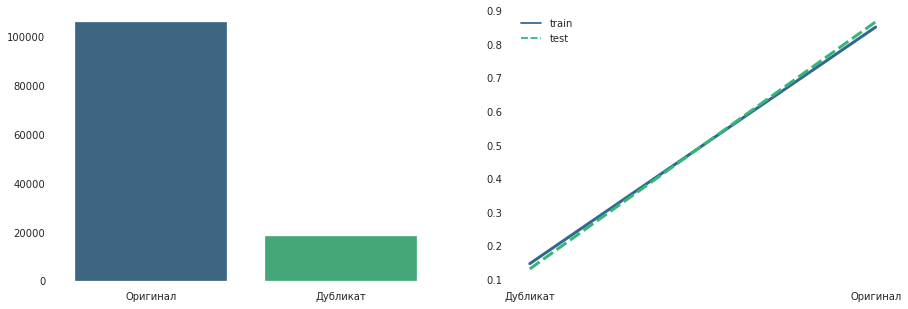

ПРИВОД
передний (%%):	0.45
	 Среднее значение целевой:	7201.55
полный (%%):	0.44
	 Среднее значение целевой:	24983.22
задний (%%):	0.11
	 Среднее значение целевой:	12411.62
Cтатистически значимые различия:	True


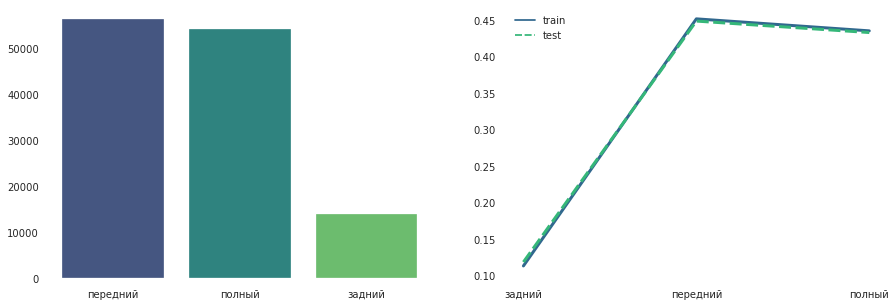

PRICE_SEGMENT
MEDIUM (%%):	0.53
	 Среднее значение целевой:	7638.44
PREMIUM (%%):	0.4
	 Среднее значение целевой:	22052.58
ECONOMY (%%):	0.08
	 Среднее значение целевой:	4750.17
Cтатистически значимые различия:	True


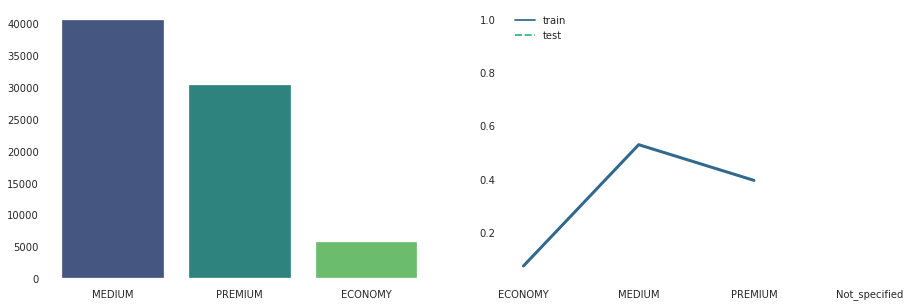

In [71]:
# Переменные, для которых уникальных значений меньше 15ти.
for column in cat_cols:
    if len(data[column].unique())<=15:
        sum_up_cat(data, column, 'eur_price')

Для данных переменных найдены статистически значимые различия.

Доля японских брендов выше в тренировочной выборке. В остальном, пропорции распределения схожи. За исключением ценового сегмента, который отсутствует в тестовой выборке. Имеет смысл удалить признак.

In [72]:
data[data.train==0].price_segment.unique()

array(['Not_specified'], dtype=object)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


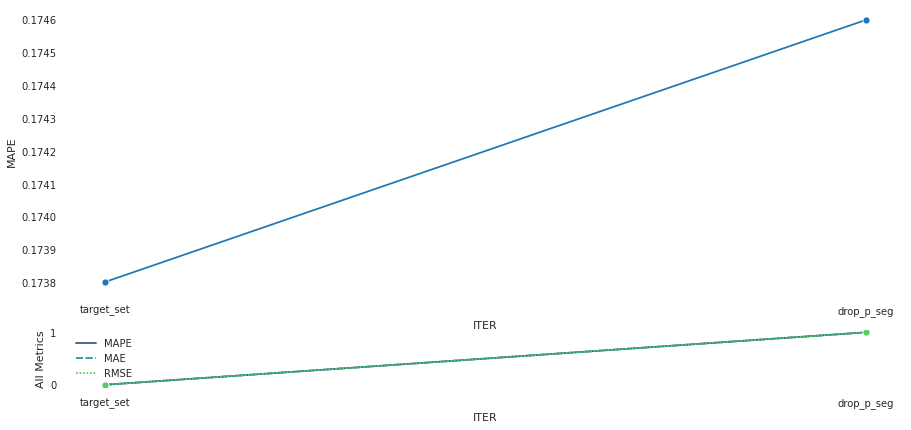

,target_set,drop_p_seg
MAPE,0.1738,0.1746
MAE,1664.7240,1674.1179
RMSE,4951.5050,5006.9795


In [73]:
# Удаление
data.drop('price_segment', axis=1, inplace=True)
cat_cols.remove('price_segment')

# Расчет и запись метрик
results['drop_p_seg'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

После удаления price_segment, качество модели снизилось.

В любом случае, данная переменная не несет ценности для предсказаний на тестовой выборке.

In [74]:
# Проверка наличия статистически значимых различий для переменных с большим числом уникальных значений
for column in cat_cols:
    if len(data[column].unique())>15:
        print(column.upper())
        print('Cтатистически значимые различия:\t{}'.format(get_stat_dif(data[data.train==1], column, 'eur_price')))

BODYTYPE
Cтатистически значимые различия:	True
COLOR
Cтатистически значимые различия:	True
MODEL_NAME
Cтатистически значимые различия:	True
COMP_ID
Cтатистически значимые различия:	True
COMP_NAME
Cтатистически значимые различия:	False
EQP_AMOUNT
Cтатистически значимые различия:	False
GEN_ID
Cтатистически значимые различия:	True


Статистически значимые различия не найдены для наименования комплектации и кол-ва опций.

Необходимо проверить полезность данных переменных для модели.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


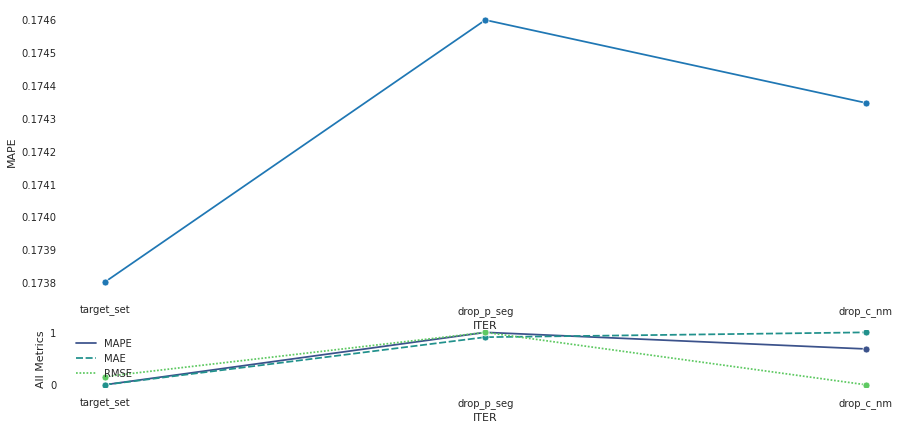

,target_set,drop_p_seg,drop_c_nm
MAPE,0.1738,0.1746,0.1743
MAE,1664.7240,1674.1179,1675.0652
RMSE,4951.5050,5006.9795,4941.1828


In [75]:
# Исключение comp_name
cat_cols.remove('comp_name')

# Расчет и запись метрик
results['drop_c_nm'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Удаление comp_name привело к снижению метрик.

К тому же, comp_name дублировал comp_id и не несет большой ценности.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


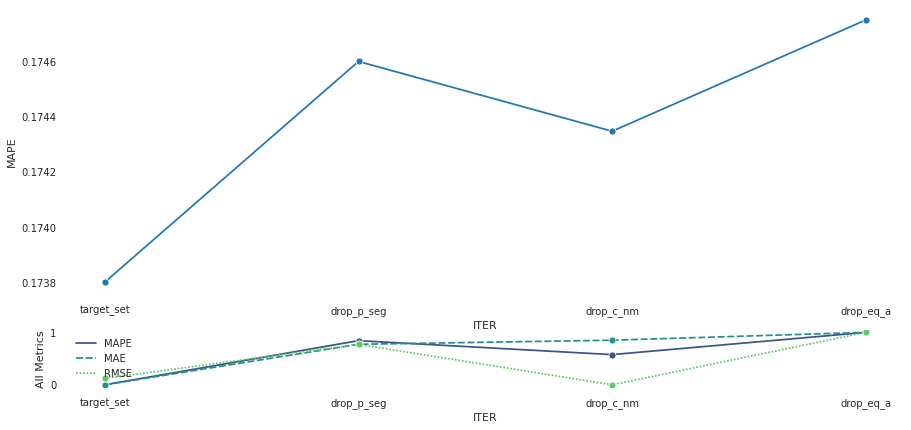

,target_set,drop_p_seg,drop_c_nm,drop_eq_a
MAPE,0.1738,0.1746,0.1743,0.1747
MAE,1664.7240,1674.1179,1675.0652,1676.8848
RMSE,4951.5050,5006.9795,4941.1828,5026.4531


In [76]:
# Исключение eqp_amount
cat_cols.remove('eqp_amount')

# Расчет и запись метрик
results['drop_eq_a'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Несмотря на снижение вспомогательных метрик, удаление eqp_amount привело к повышению MAPE

In [77]:
cat_cols.append('eqp_amount')

### Итог:

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


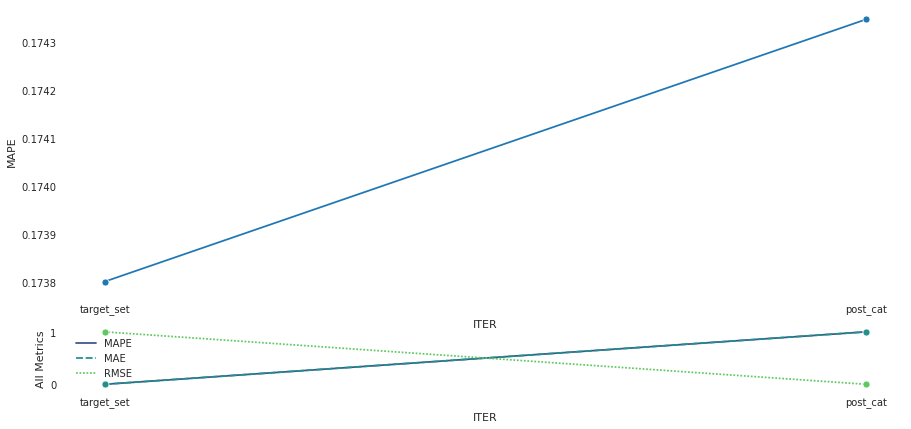

,target_set,post_cat
MAPE,0.1738,0.1743
MAE,1664.7240,1675.0652
RMSE,4951.5050,4941.1828


In [78]:
# Удаление промежуточных шагов
results.drop(['drop_p_seg', 'drop_c_nm', 'drop_eq_a'], axis=1, inplace=True)

# Расчет и запись метрик
results['post_cat'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

В ходе обработки метрики выросли. Во многом, из-за удаления признака, отсутвующего в тестовой выборке.

## Числовые данные

In [79]:
# Функция рассчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest)|(df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [80]:
# Функция выводит основную информацию и график признака
def sum_up_num(df, col, target, label='train'):
    print(col.upper())
    train = df[df[label]==1]
    trn = train[col].describe()[1:]
    tst = df[df[label]==0][col].describe()[1:]
    changes = pd.DataFrame({'train':trn, 'test':tst})
    
    print(trn)
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(train, col)[0], 
                                                   np.round(outbursts(train, col)[1]*100,2)))
    print()
    fig, axs = plt.subplots(figsize=(20, 5), ncols=3)
    sns.distplot(train[col], kde=True, ax=axs[0])
    sns.boxplot(data = train,  x = col, palette = 'viridis', ax=axs[1])
    sns.lineplot(data=changes, palette='viridis', linewidth=3, ax=axs[2])
    plt.show()

MILEAGE
mean    157209.3194
std     113238.1584
min          0.0000
25%      74000.0000
50%     147100.0000
75%     222463.0000
max    1000000.0000
Name: mileage, dtype: float64
Кол-во выбросов: 1859 	 (%%: 1.49)



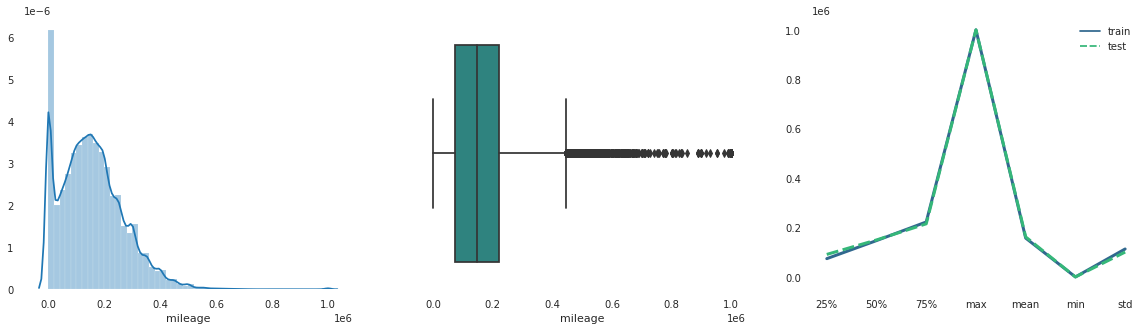

MODELDATE
mean   2006.8681
std       8.7029
min    1904.0000
25%    2002.0000
50%    2009.0000
75%    2013.0000
max    2020.0000
Name: modelDate, dtype: float64
Кол-во выбросов: 2226 	 (%%: 1.79)



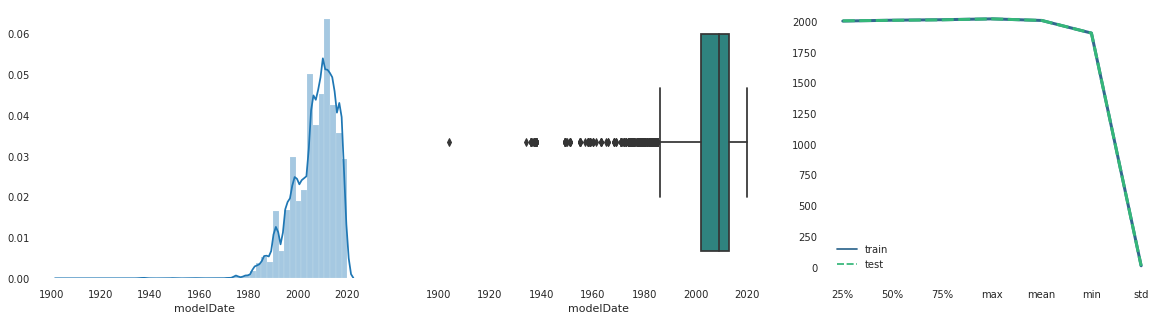

NUMBEROFDOORS
mean   4.4927
std    0.6766
min    0.0000
25%    4.0000
50%    5.0000
75%    5.0000
max    5.0000
Name: numberOfDoors, dtype: float64
Кол-во выбросов: 3520 	 (%%: 2.83)



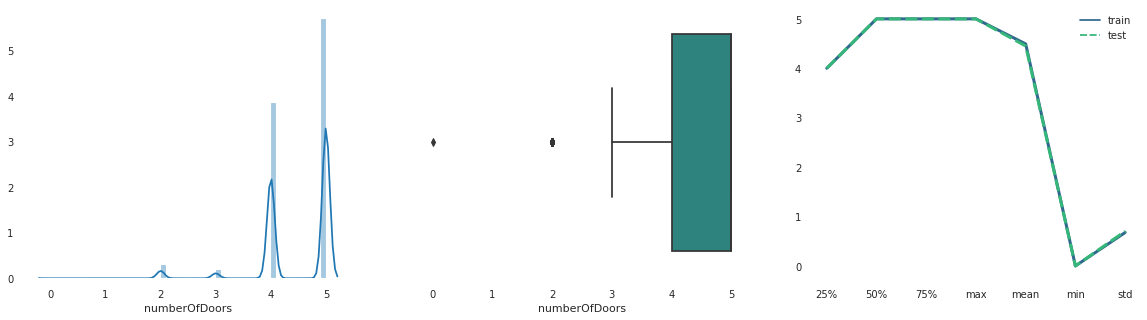

PARSING_UNIXTIME
mean   1612257887.6844
std       9918238.2175
min    1599647912.0000
25%    1599647912.0000
50%    1619952959.0000
75%    1620116507.0000
max    1620371710.0000
Name: parsing_unixtime, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



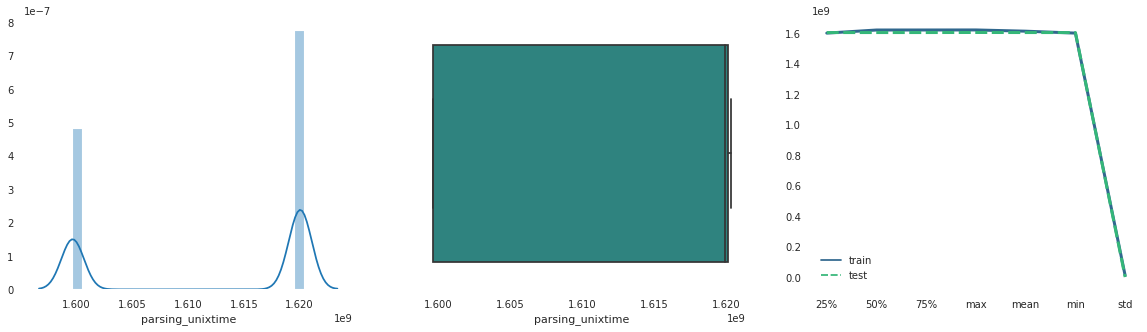

PRODUCTIONDATE
mean   2009.0580
std       8.3761
min    1904.0000
25%    2004.0000
50%    2011.0000
75%    2015.0000
max    2021.0000
Name: productionDate, dtype: float64
Кол-во выбросов: 1452 	 (%%: 1.17)



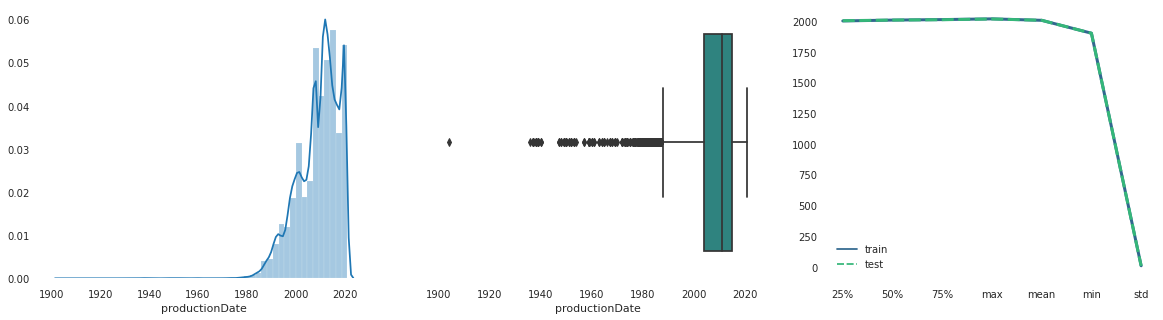

RUR_PRICE
mean    1398001.2830
std     1857453.8315
min       20000.0000
25%      389000.0000
50%      800000.0000
75%     1729000.0000
max    68500000.0000
Name: rur_price, dtype: float64
Кол-во выбросов: 9075 	 (%%: 7.3)



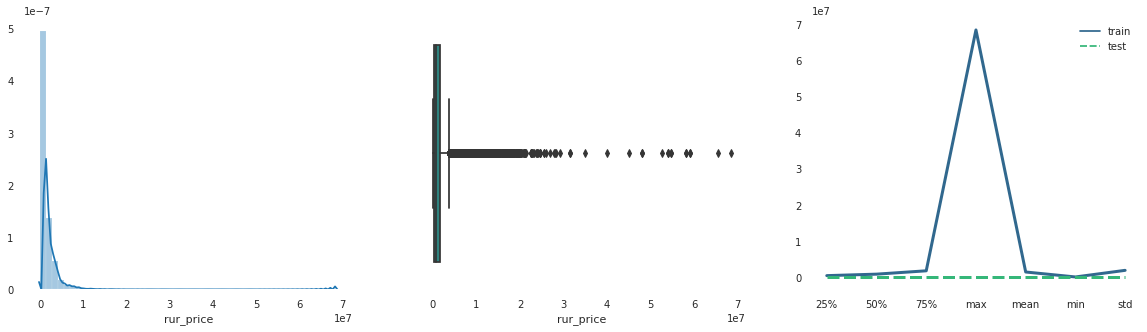

EUR_PRICE
mean    15530.4890
std     20656.9367
min       221.0000
25%      4305.0000
50%      8845.0000
75%     19197.0000
max    763343.0000
Name: eur_price, dtype: float64
Кол-во выбросов: 9041 	 (%%: 7.27)



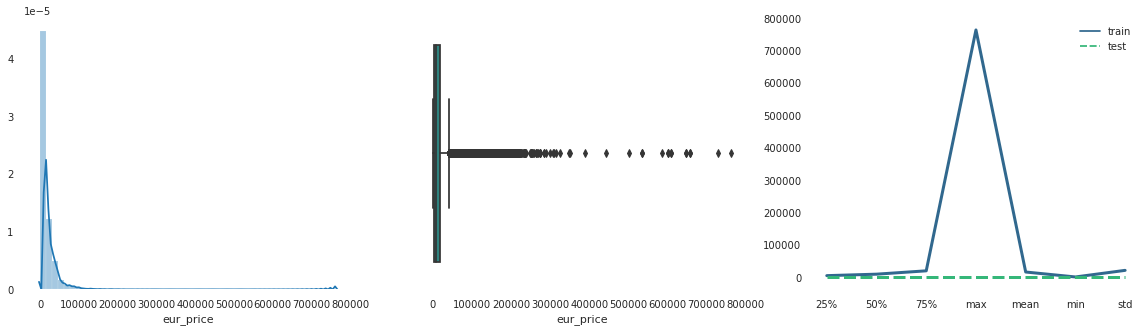

USD_PRICE
mean    18551.6874
std     24580.6659
min       263.0000
25%      5134.0000
50%     10593.0000
75%     22905.0000
max    901737.0000
Name: usd_price, dtype: float64
Кол-во выбросов: 9028 	 (%%: 7.26)



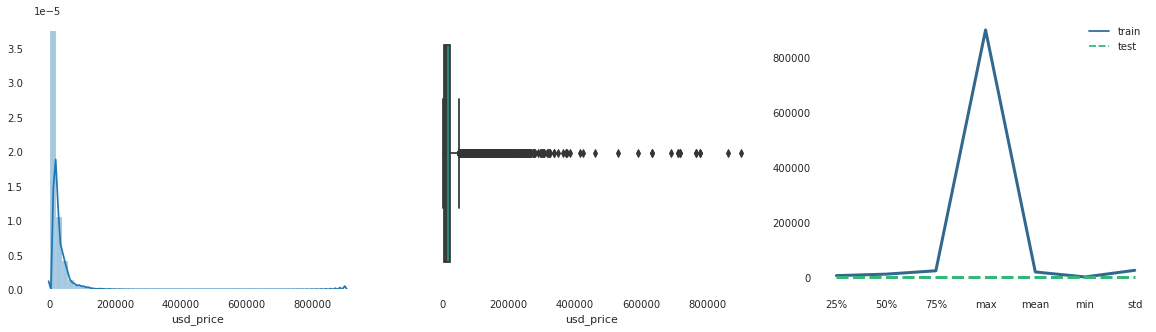

ENG_VOLUME
mean     2.3320
std      1.5224
min      0.0000
25%      1.6000
50%      2.0000
75%      2.9000
max    300.0000
Name: eng_volume, dtype: float64
Кол-во выбросов: 3359 	 (%%: 2.7)



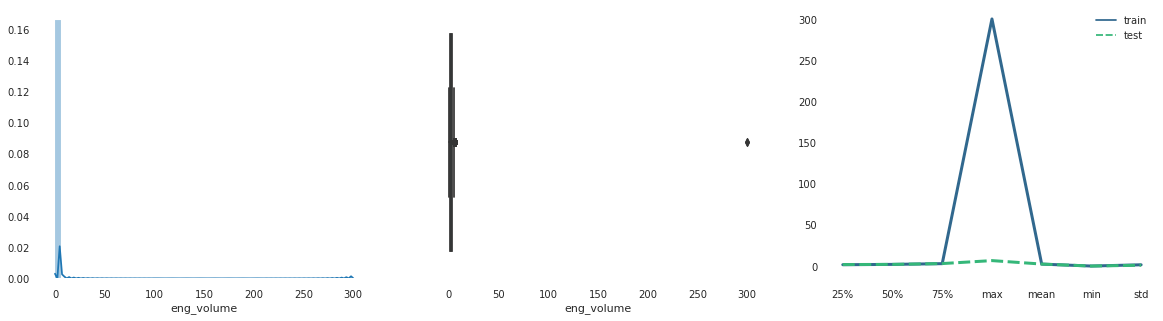

ENG_PWR
mean   181.9853
std     88.6240
min     30.0000
25%    117.0000
50%    156.0000
75%    224.0000
max    800.0000
Name: eng_pwr, dtype: float64
Кол-во выбросов: 4598 	 (%%: 3.7)



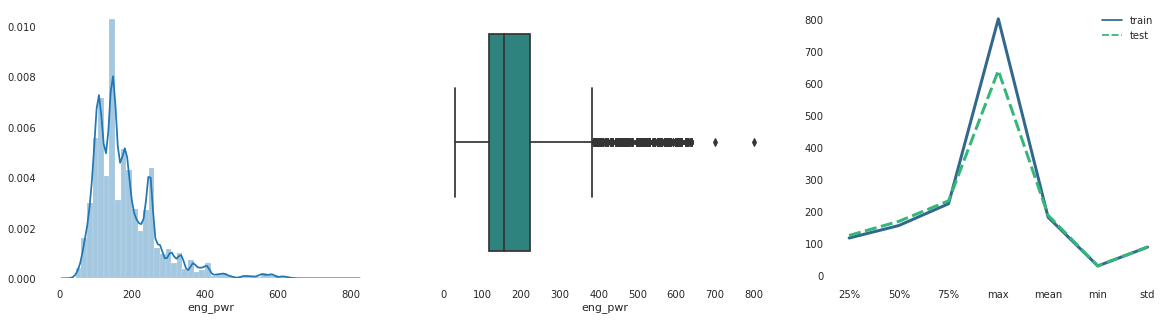

OWN_TIME
mean    14.9193
std     33.7430
min      0.0000
25%      0.0000
50%      0.0000
75%     12.0000
max    578.0000
Name: own_time, dtype: float64
Кол-во выбросов: 21169 	 (%%: 17.02)



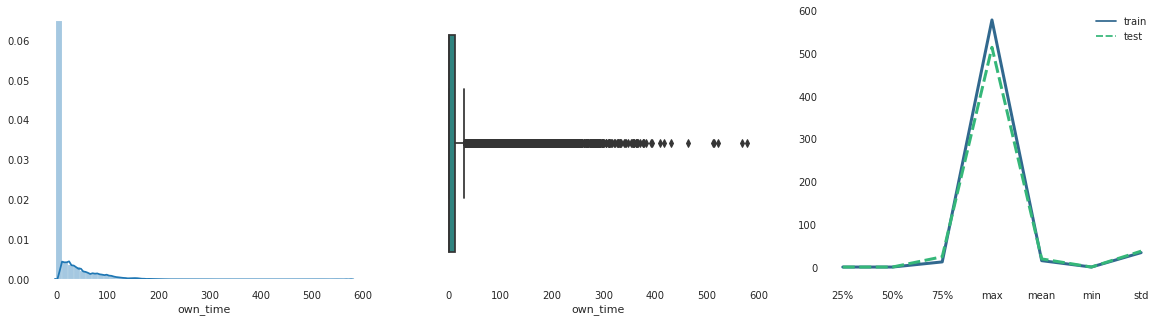

In [81]:
for column in num_cols:
    sum_up_num(data, column, 'eur_price')

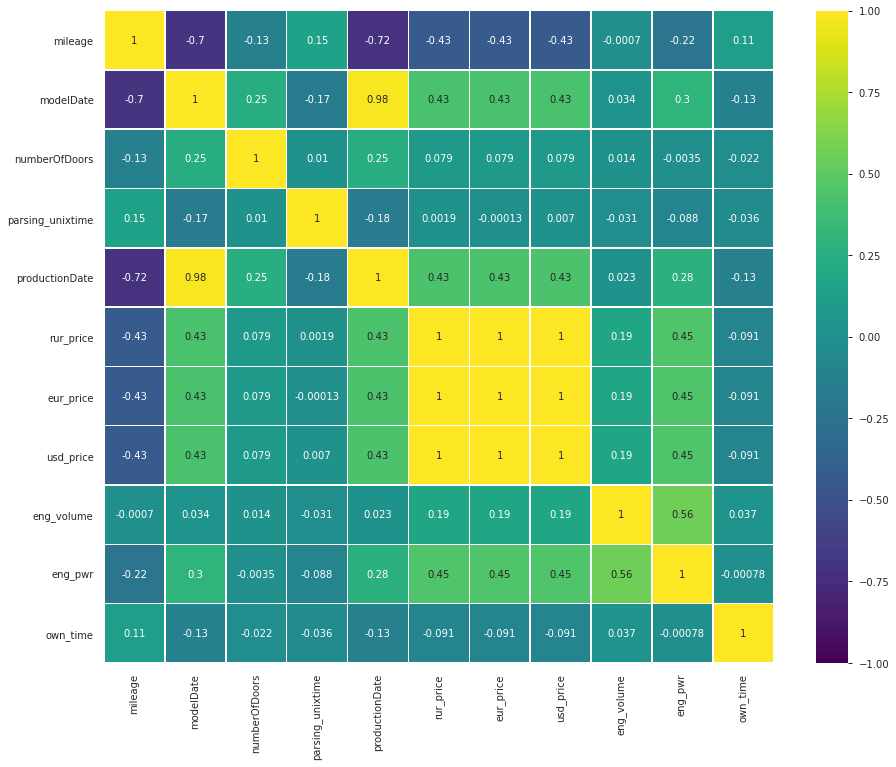

In [82]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Числовые данные в тренировочной и тестовой выборках распределены примерно одинаково. Бросается в глаза, что в тестовой выборке минимальное кол-во дверей равно 0.

Имеет смысл вычесть годы производства авто из текущего года, получив возраст. В таком случае распределение переменной будет выглядеть логнормально. Так же, вычитая из производства авто выпуск модели, мы получил кол-во лет перед производством. Это позволит избавиться от высокой корреляции.

Мощность двигателя и пробег распределены логнормально. Имеет смысл нормализовать данные.

Ожидаемо, цены на авто скореллированы между собой и имеют высокое кол-во выбросов в большую сторону. Дополнительная обработка входа и выхода, может улучшить предсказания модели. Указание цен в валюте может пригодиться для предсказания на тесте, так даты выгрузки данных отличаются. Возможно, цены в валюте ведут себя более стабильно.

### Кол-во дверей

In [83]:
data[data.numberOfDoors==0]

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,train,comp_id,comp_name,eqp_options,eqp_amount,gen_id,rur_price,eur_price,usd_price,eng_volume,eng_pwr,own_time,parsing_datetime
93780,кабриолет,MERCEDES,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",бензин,48000.0000,1904.0000,SIMPLEX,0.0000,1603245843.0000,1904.0000,1093802104.0000,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,0,0,Not_specified,None,0,21743990,0.0000,0.0000,0.0000,5.3000,32.0000,80,2020-10-21 02:04:03
142194,кабриолет,MERCEDES,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",бензин,48000.0000,1904.0000,SIMPLEX,0.0000,1599647912.0000,1904.0000,None,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,1,0,Not_specified,None,None,None,12000000.0000,133724.0000,157969.0000,5.3000,32.0000,79,2020-09-09 10:38:32


Данное авто 1904-го года действительно не имеет дверей.

### Года

In [84]:
data['age'] = data.parsing_datetime.dt.year - data.productionDate
data['years_in_prod'] = data.productionDate - data.modelDate

AGE
mean    11.5599
std      8.4898
min      0.0000
25%      5.0000
50%     10.0000
75%     17.0000
max    116.0000
Name: age, dtype: float64
Кол-во выбросов: 778 	 (%%: 0.63)



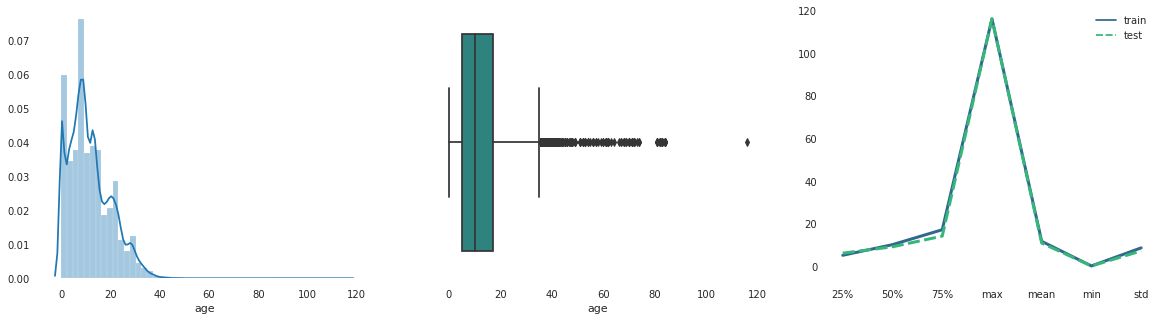

YEARS_IN_PROD
mean    2.1899
std     1.7485
min    -5.0000
25%     1.0000
50%     2.0000
75%     3.0000
max    58.0000
Name: years_in_prod, dtype: float64
Кол-во выбросов: 2331 	 (%%: 1.87)



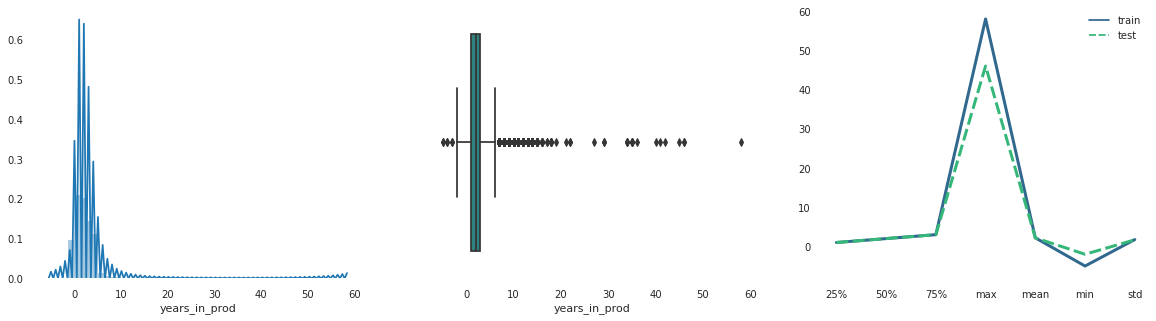

In [85]:
for column in ['age','years_in_prod']:
    sum_up_num(data, column, 'eur_price')

Бросается в глаза отрицательный показатель years_in_prod. Имеет смысл выяснить, характерна ли эта ошибка только для тренировочной выборки.

In [86]:
data[data['years_in_prod']<0].train.unique()

array([1, 0])

Авто, у которых дата производства меньше даты выпуска, присутствуют как в тренирочной, так и в тестовой выборках.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


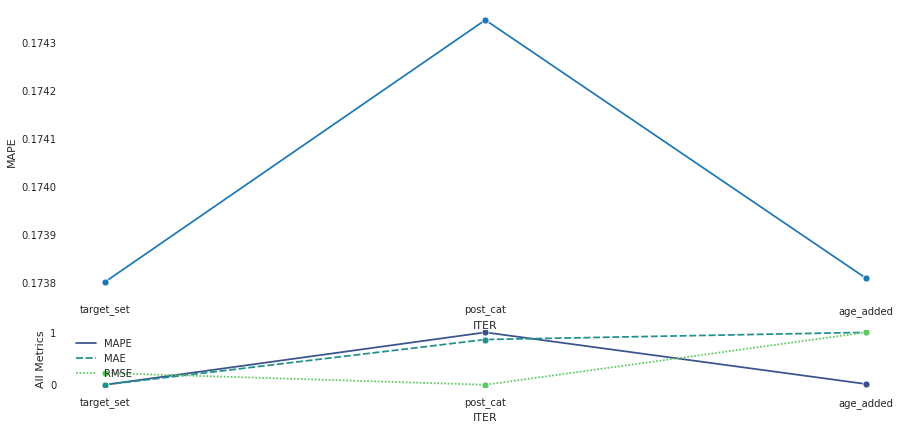

,target_set,post_cat,age_added
MAPE,0.1738,0.1743,0.1738
MAE,1664.7240,1675.0652,1676.7070
RMSE,4951.5050,4941.1828,4987.1651


In [87]:
for column in ['age','years_in_prod']:
    num_cols.append(column)

# Расчет и запись метрик
results['age_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

В среднем, точность модели снизилась после добавления переменных

### Нормализация

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


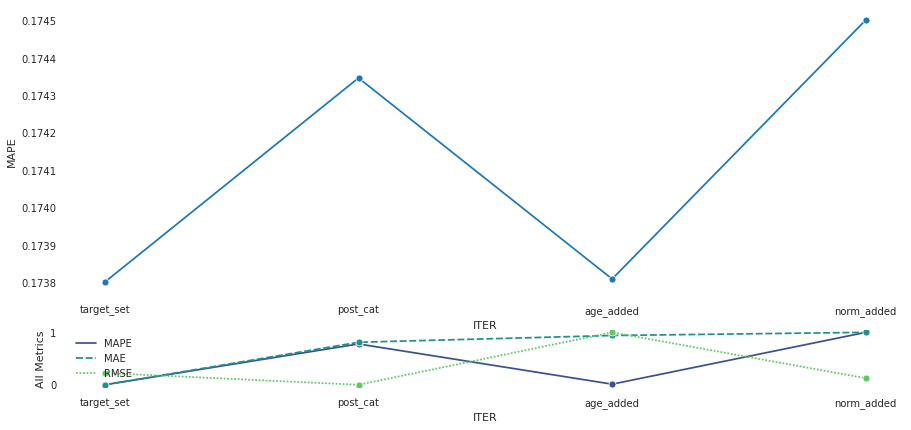

,target_set,post_cat,age_added,norm_added
MAPE,0.1738,0.1743,0.1738,0.1745
MAE,1664.7240,1675.0652,1676.7070,1677.4705
RMSE,4951.5050,4941.1828,4987.1651,4946.9444


In [88]:
data['mileage_norm'] = data.mileage.apply(lambda x: np.log(x))
data['eng_pwr_norm'] = data.eng_pwr.apply(lambda x: np.log(x))

for column in ['mileage_norm','eng_pwr_norm']:
    num_cols.append(column)

# Расчет и запись метрик
results['norm_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Нормализация не улучшает работу модели с точки зрения MAPE. Вместе с тем, корень среднеквадратичной ошибки снижается.

В целом, так как алгоритм основан на деревьях решений, не чувствительных к выбросам, нет необходимости нормализовать переменные.

### Доп. обработка целевой переменной

Добавление доп. обработки в функцию моделирования:

In [89]:
# Функция возвращает метрики для данных и модели
def metics(data, target, model=CatBoostRegressor(random_seed = RS, silent=True)):
    df = data.copy()
    
    # Кодирование
    LE = LabelEncoder()
    for col in bin_cols+cat_cols:
        if df[col].dtype == object:
            df[col] = df[col].fillna('Non_specified')
            df[col] = df[col].apply(lambda x: str(x))
            df[col] = LE.fit_transform(df[col])
    
    # Разделение переменных
    X = df[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values
    y = df[target].values
    
    # Создание списков для записи локальных результатов
    local_mape = []
    local_mae = []
    local_mse = []
    
    # Моделирование с 3-ой кросс-валидацией
    SKF = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)
    for train_index, test_index in SKF.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, np.log(y_train)) #<= Логорифмирование
        preds = np.exp(model.predict(X_test)) #<= Экспонента
        local_mape.append(MAPE(y_test, preds))
        local_mae.append(mean_absolute_error(y_test, preds))
        local_mse.append(mean_squared_error(y_test, preds)**(1/2))
    
    # Усреднение метрик
    result = []
    result.append(np.mean(local_mape))
    result.append(np.mean(local_mae))
    result.append(np.mean(local_mse))
    
    return result

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


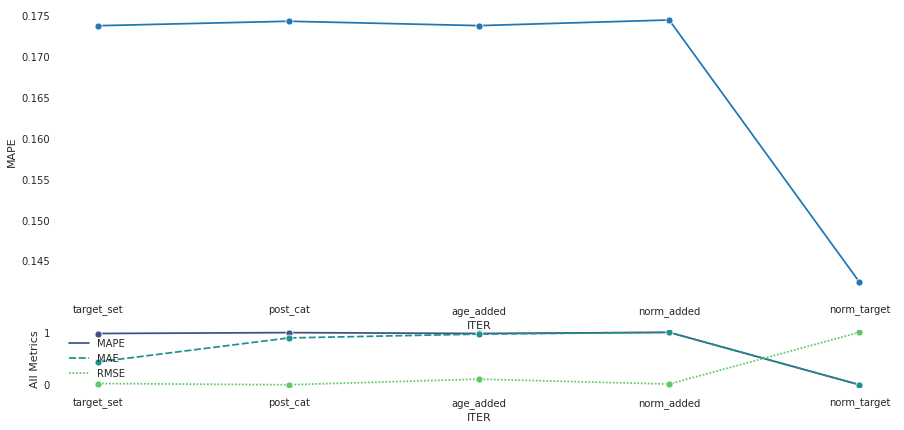

,target_set,post_cat,age_added,norm_added,norm_target
MAPE,0.1738,0.1743,0.1738,0.1745,0.1424
MAE,1664.7240,1675.0652,1676.7070,1677.4705,1654.7988
RMSE,4951.5050,4941.1828,4987.1651,4946.9444,5369.0246


In [90]:
# Расчет и запись метрик
results['norm_target'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Модель стала менее чуствительна к выбросам целевой переменной. В результате, в среднем предсказания модели стали точнее. Вместе с тем, предсказание экстремальных значений стало менее точным (RMSE повысился).

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


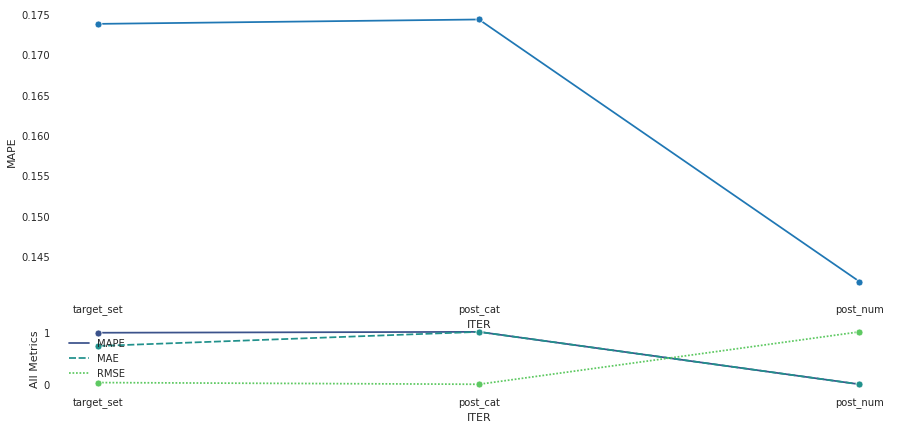

,target_set,post_cat,post_num
MAPE,0.1738,0.1743,0.1418
MAE,1664.7240,1675.0652,1636.6076
RMSE,4951.5050,4941.1828,5260.0485


In [91]:
data.drop(['mileage_norm','eng_pwr_norm', 'age','years_in_prod'],axis=1,inplace=True)
for column in ['mileage_norm','eng_pwr_norm', 'age','years_in_prod']:
    num_cols.remove(column)

# Удаление промежуточных шагов
results.drop(['age_added', 'norm_added','norm_target'], axis=1, inplace=True)

# Расчет и запись метрик
results['post_num'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

# Feature Engineering

In [92]:
# Функция возвращает важность переменных для модели
def get_feature_importance(data, target, model=CatBoostRegressor(random_seed = RS, silent=True)):
    df = data.copy()
    
    # Кодирование
    LE = LabelEncoder()
    for col in bin_cols+cat_cols:
        if df[col].dtype == object:
            df[col] = df[col].fillna('Non_specified')
            df[col] = df[col].apply(lambda x: str(x))
            df[col] = LE.fit_transform(df[col])
    
    # Разделение переменных
    cols = df[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).columns
    X = df[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values
    y = df[target].values
    
    # Расчет важности переменных
    model.fit(X, np.log(y))
    FE = pd.Series(model.get_feature_importance(), index=cols).sort_values(ascending=False)
    
    # Визуализация
    plt.figure(figsize=(15,10))
    ax = sns.barplot(x=FE.values, y=FE.index, palette = 'viridis')
    ax.set(ylabel='FEATURE', xlabel='RELATIVE IMPORTANCE (%%)')
    plt.show()
    display(pd.DataFrame(FE, columns=['score']).T)

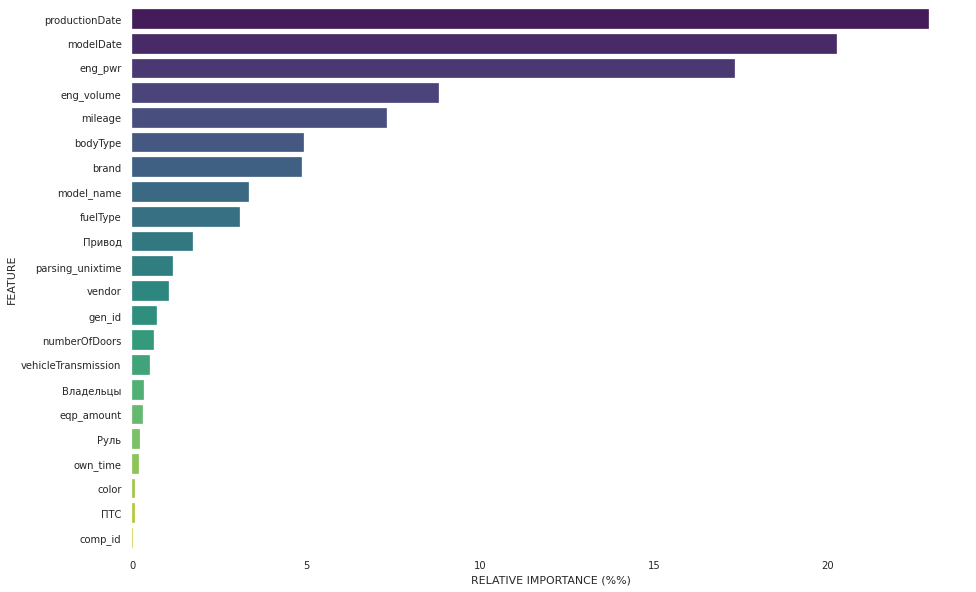

,productionDate,modelDate,eng_pwr,eng_volume,mileage,bodyType,brand,model_name,fuelType,Привод,parsing_unixtime,vendor,gen_id,numberOfDoors,vehicleTransmission,Владельцы,eqp_amount,Руль,own_time,color,ПТС,comp_id
score,22.9087,20.2653,17.3142,8.8120,7.3267,4.9329,4.8786,3.3639,3.0879,1.7396,1.1837,1.0551,0.7106,0.6233,0.5240,0.3480,0.3112,0.2174,0.2063,0.0780,0.0732,0.0395


In [93]:
get_feature_importance(data[data.train==1], 'eur_price')

Наиболее полезно себя показывают числовые переменные productionDate и modelDate.

В то же время, категориальные признаки brand и model_name показывают себя относительно плохо. Имеет смысл поэксперементировать с расчетом статистик для данных групп.

## Stats

### Brand

Для brand расчитаем среднеарифметическое стандартизированых средней и максимальной цен.
- Это позволит нивелировать ошибку среднего (к примеру, если автопроизводитель представлен более старыми авто, среднее значение будет ниже и не отобразит относительной цены бренда), и ошибку максимума (к примеру, у автопроизводителя имеются модели, выбивающиеся из общего модельного ряда в большую сторону, завышая относительную цену бренда).

In [94]:
# Расчет статистик по брендам
stat_max = data[data.train==1].groupby('brand').eur_price.max()
stat_avg = data[data.train==1].groupby('brand').eur_price.mean()
stat = pd.DataFrame({'brand':stat_max.index, 'max_price':stat_max.values})
stat['mean_price'] = stat.brand.apply(lambda x: stat_avg[x])
max_price_range = stat.max_price.max() - stat.max_price.min()
mean_price_range = stat.mean_price.max() - stat.mean_price.min()
stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range 
                + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
stat.sort_values(by='stat',inplace = True)
stat.reset_index(drop=True, inplace = True)
stat['ordinal_code'] = stat.index
stat

,brand,max_price,mean_price,stat,ordinal_code
0,HONDA,63489.0000,6416.8519,0.0208,0
1,SKODA,33107.0000,8454.9471,0.0391,1
2,NISSAN,95284.0000,7551.0847,0.0643,2
3,MITSUBISHI,105934.0000,8753.7292,0.0947,3
4,VOLKSWAGEN,94721.0000,11000.9098,0.1301,4
5,TOYOTA,152640.0000,11246.5535,0.1744,5
6,VOLVO,85997.0000,15418.9599,0.2088,6
7,INFINITI,73099.0000,17176.7699,0.2337,7
8,AUDI,166024.0000,14753.6453,0.2508,8
9,BMW,181531.0000,25374.9596,0.4651,9


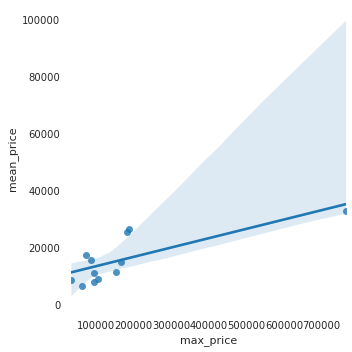

In [95]:
# Визуализация отношения средней и максимальной цен
sns.lmplot(data=stat, x='max_price', y='mean_price', palette = 'viridis')

Имеет смысл кластеризовать автопроизводителей, фактически обозначив сигменты рынка. Визуально выделяются 5.

In [96]:
# Предсказание кластера
kmeans = KMeans(n_clusters=5)
kmeans.fit(MinMaxScaler().fit_transform(stat[['max_price', 'mean_price']]))
stat['brand_cluster'] = kmeans.labels_.astype(np.int)

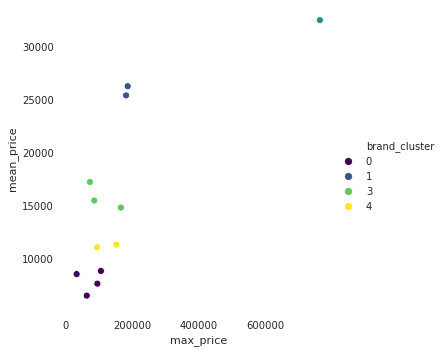

In [97]:
# Визуализация
sns.relplot(data=stat, x='max_price', y='mean_price', hue='brand_cluster', palette = 'viridis')

Поскольку KMeans назначает имена случайным образом, имеет смысл упорядочить их согласно значению статистики.

In [98]:
# Изменение значения кластера на ординальное
ord_clust = stat.groupby('brand_cluster').stat.mean().sort_values()
mapping_dict = {}
for i in range(ord_clust.shape[0]):
    mapping_dict[ord_clust.index[i]] = i
stat['brand_cluster'] = stat.brand_cluster.map(mapping_dict)

Тестирование:

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


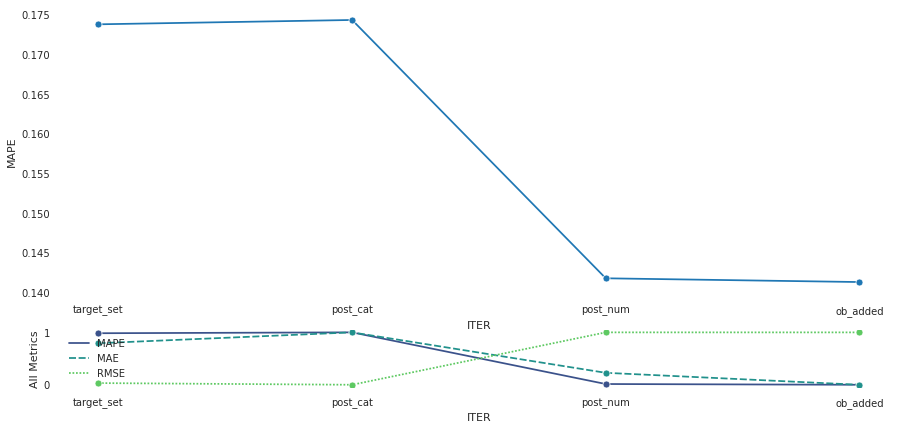

,target_set,post_cat,post_num,ob_added
MAPE,0.1738,0.1743,0.1418,0.1414
MAE,1664.7240,1675.0652,1636.6076,1625.2435
RMSE,4951.5050,4941.1828,5260.0485,5259.8889


In [99]:
# Добавление параметра
mapping_dict = {}
for i in range(stat.shape[0]):
    mapping_dict[stat.brand.loc[i]] = i
data['ord_brand'] = data.brand.map(mapping_dict)
cat_cols.append('ord_brand')

# Расчет и запись метрик
results['ob_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Добавление упорядоченного кодирования бренда дало небольшое улучшение работы модели.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


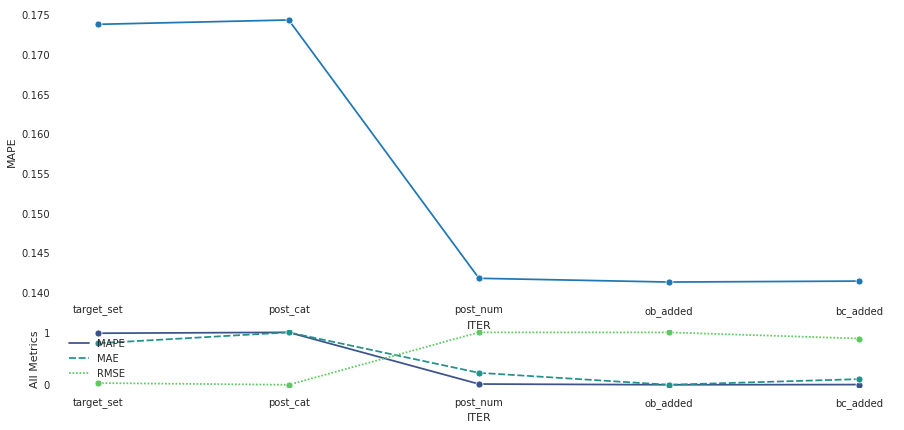

,target_set,post_cat,post_num,ob_added,bc_added
MAPE,0.1738,0.1743,0.1418,0.1414,0.1415
MAE,1664.7240,1675.0652,1636.6076,1625.2435,1630.6258
RMSE,4951.5050,4941.1828,5260.0485,5259.8889,5222.5177


In [100]:
# Добавление параметра
mapping_dict = {}
for i in range(stat.shape[0]):
    mapping_dict[stat.brand.loc[i]] = stat.brand_cluster.loc[i]
data['brand_cluster'] = data.brand.map(mapping_dict)
cat_cols.append('brand_cluster')

# Расчет и запись метрик
results['bc_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Кластер бренда не несет ценности для модели.

In [101]:
# Удаление brand_cluster
cat_cols.remove('brand_cluster')
data.drop('brand_cluster', axis=1, inplace=True)

### Model

Модели авто будут рассмотрены по каждому бренду. Для каждой моделей рассчитаем статистику, аналогичную той, что считались ранее (Если модель присутствует только в тесте, берется среднеарифметическое по бренду). Далее, упорядочиваем модели по статистике внутри бренда и стандартизируем позицию. Таким образом, мы получаем относительное положение модели внутри линейки бренда (самые дорогие авто = 1, самые дешевые = 0).

In [102]:
# Функция возвращает значение, если оно имеется
# В противном случае 'None'
def get_price(df, model):
    try:
        return df[model]
    except:
        return None

In [103]:
# Расчет относительного рейтинга модели
mapping_dict = {}
for mark in tqdm(data.brand.unique()):
    stat = pd.DataFrame({'model':data[data.brand==mark].model_name.unique()})
    stat_max = data[(data.train==1)&(data.brand==mark)].groupby('model_name').eur_price.max()
    stat['max_price'] = stat.model.apply(lambda x: get_price(stat_max, x))
    stat_mean = data[(data.train==1)&(data.brand==mark)].groupby('model_name').eur_price.mean()
    stat['mean_price'] = stat.model.apply(lambda x: get_price(stat_mean, x))
    max_price_range = stat.max_price.max() - stat.max_price.min()
    mean_price_range = stat.mean_price.max() - stat.mean_price.min()
    stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range 
                    + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
    stat['stat'] = stat.stat.fillna(stat.stat.mean())
    stat.sort_values(by='stat',inplace = True)
    stat.reset_index(drop=True, inplace = True)
    stat['ordinal_code'] = stat.index
    stat.stat.fillna(stat.stat.mean())
    for i in stat.index:
        mapping_dict[stat.loc[i]['model']] = stat.loc[i]['ordinal_code']/stat['ordinal_code'].max()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


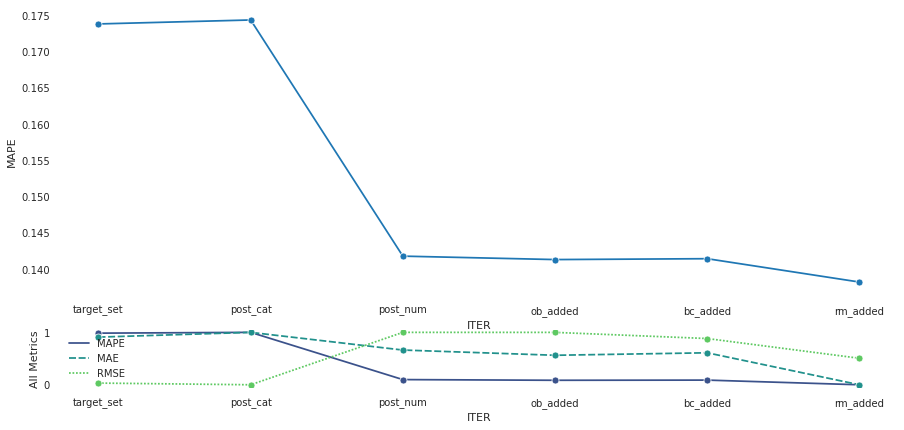

,target_set,post_cat,post_num,ob_added,bc_added,rm_added
MAPE,0.1738,0.1743,0.1418,0.1414,0.1415,0.1383
MAE,1664.7240,1675.0652,1636.6076,1625.2435,1630.6258,1561.0964
RMSE,4951.5050,4941.1828,5260.0485,5259.8889,5222.5177,5102.4822


In [104]:
data['rel_model'] = data.model_name.map(mapping_dict)
num_cols.append('rel_model')

# Расчет и запись метрик
results['rm_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Параметр относительного рейтинга модели улучшает работу модели. Судя по более резкому снижению MAPE и RMSE относительно MAPE, улучшения больше сказываются на предсказании более дорогих и редких авто.

### Decades

Так как зависимость возраста авто и его цены нелинейна (наиболее старые и новые авто дороже), имеет смысл поэксперементировать с разделением времени на отрезки. Несмотря на то,что в градиентный бустинг встроен подобный алгоритм, эксперимент может быть полезен.

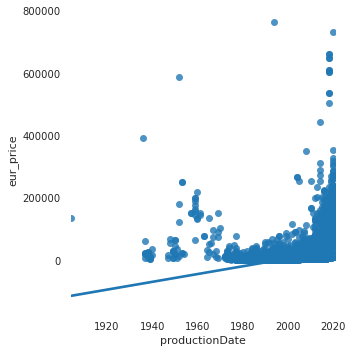

In [105]:
sns.lmplot(data=data[data.train==1], x='productionDate', y='eur_price', palette = 'viridis')

In [106]:
data['decade'] = data.productionDate.apply(lambda x: (int(x/10))*10)

In [107]:
stat = pd.DataFrame({'decade':data.decade.unique()})
stat_max = data[data.train==1].groupby('decade').eur_price.max()
stat['max_price'] = stat.decade.apply(lambda x: get_price(stat_max, x))
stat_avg = data[data.train==1].groupby('decade').eur_price.mean()
stat['mean_price'] = stat.decade.apply(lambda x: get_price(stat_avg, x))
stat.sort_values(by='decade',inplace = True)
stat.fillna(method='backfill', inplace = True)
max_price_range = stat.max_price.max() - stat.max_price.min()
mean_price_range = stat.mean_price.max() - stat.mean_price.min()
stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range 
                + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
stat.sort_values(by='stat',inplace = True)
stat.reset_index(drop=True, inplace = True)
stat['ordinal_code'] = stat.index
stat

,decade,max_price,mean_price,stat,ordinal_code
0,1980,44157.0000,2127.7339,0.0000,0
1,1970,101496.0000,8819.6466,0.0653,1
2,1940,66862.0000,26510.1818,0.1084,2
3,2000,349413.0000,6177.9203,0.2276,3
4,1930,390029.0000,41649.3125,0.3906,4
5,1960,216236.0000,80594.0455,0.4178,5
6,2010,658454.0000,19881.2615,0.4945,6
7,1990,763343.0000,2984.0288,0.5033,7
8,1900,133724.0000,133724.0000,0.5623,8
9,2020,729196.0000,43123.6234,0.6320,9


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


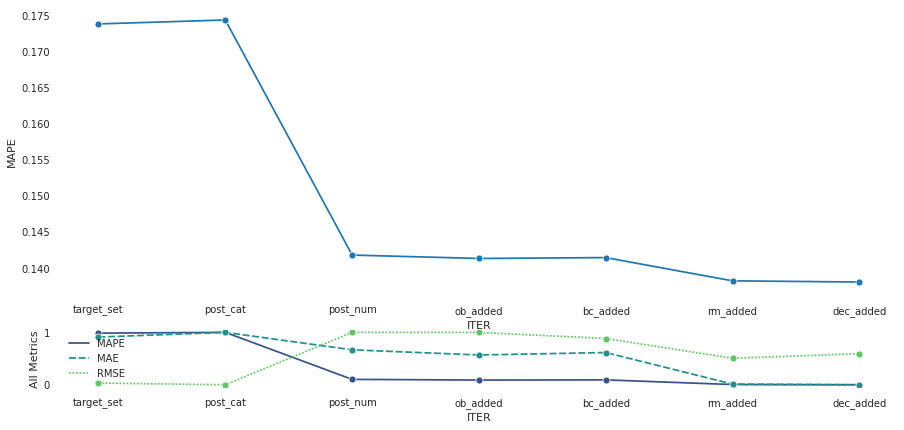

,target_set,post_cat,post_num,ob_added,bc_added,rm_added,dec_added
MAPE,0.1738,0.1743,0.1418,0.1414,0.1415,0.1383,0.1381
MAE,1664.7240,1675.0652,1636.6076,1625.2435,1630.6258,1561.0964,1559.6489
RMSE,4951.5050,4941.1828,5260.0485,5259.8889,5222.5177,5102.4822,5130.0938


In [108]:
# Добавление параметра
mapping_dict = {}
for i in range(stat.shape[0]):
    mapping_dict[stat.decade.loc[i]] = i
data['decade'] = data.decade.map(mapping_dict)
cat_cols.append('decade')

# Расчет и запись метрик
results['dec_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Параметр decade снижает целевую метрику.

### Body type

In [109]:
data.bodyType.value_counts()


внедорожник 5 дв.             57521
седан                         54871
хэтчбек 5 дв.                 11737
лифтбек                        7312
универсал 5 дв.                6212
                              ...  
седан premio                      1
универсал 5 дв. california        1
хэтчбек 5 дв. runx                1
родстер roadster                  1
седан gracia                      1
Name: bodyType, Length: 102, dtype: int64

In [110]:
# Сократим количество типов кузова до основных
data['body'] = data['bodyType'].apply(lambda x: x[:4])
cat_cols.append('body')

data['body'].value_counts()

внед    58207
седа    56456
хэтч    13821
лифт     7604
унив     6263
мини     5674
комп     4012
купе     3896
пика     1662
фург      694
родс      384
кабр      300
микр       43
лиму       16
тарг        7
фаст        4
Name: body, dtype: int64

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


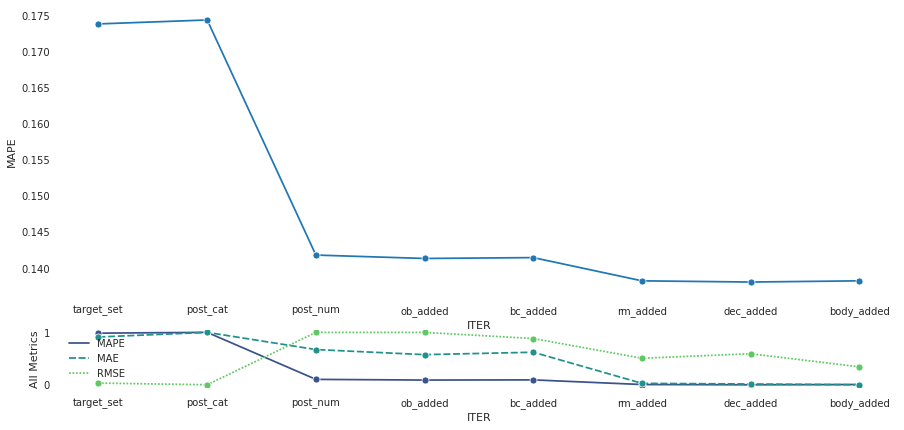

,target_set,post_cat,post_num,ob_added,bc_added,rm_added,dec_added,body_added
MAPE,0.1738,0.1743,0.1418,0.1414,0.1415,0.1383,0.1381,0.1383
MAE,1664.7240,1675.0652,1636.6076,1625.2435,1630.6258,1561.0964,1559.6489,1557.9206
RMSE,4951.5050,4941.1828,5260.0485,5259.8889,5222.5177,5102.4822,5130.0938,5050.2973


In [111]:
# Расчет и запись метрик
results['body_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Признак body немного улучшил основую метрику

### Color

In [112]:
# Определим популярные цвета и добавим признак "популярный цвет"
data['color'].value_counts()

чёрный         46475
белый          31789
серый          20088
серебристый    18819
синий          14822
красный         6952
коричневый      6305
зелёный         4617
бежевый         2599
голубой         2000
золотистый      1211
пурпурный       1056
фиолетовый       905
жёлтый           688
оранжевый        614
розовый          103
Name: color, dtype: int64

In [113]:
popular_color = ['чёрный', 'белый', 'серый', 'серебристый']
data['pop_color'] = data['color'].apply(lambda x: 1 if x in popular_color else 0)
cat_cols.append('pop_color')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


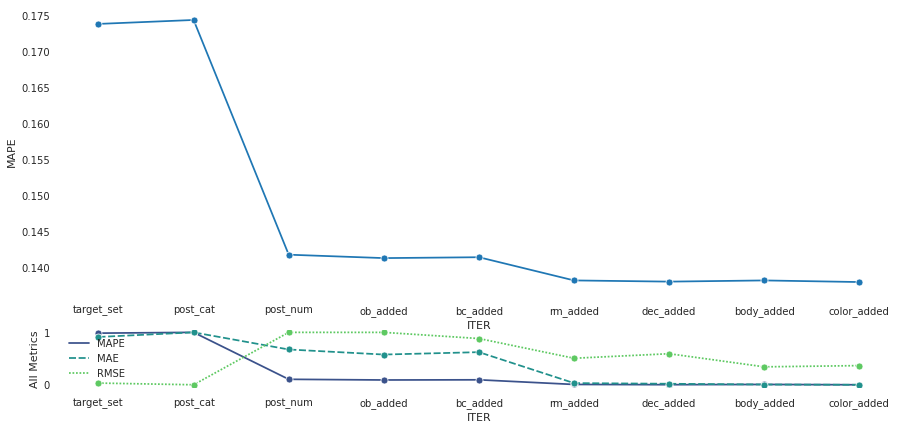

,target_set,post_cat,post_num,ob_added,bc_added,rm_added,dec_added,body_added,color_added
MAPE,0.1738,0.1743,0.1418,0.1414,0.1415,0.1383,0.1381,0.1383,0.1380
MAE,1664.7240,1675.0652,1636.6076,1625.2435,1630.6258,1561.0964,1559.6489,1557.9206,1557.3587
RMSE,4951.5050,4941.1828,5260.0485,5259.8889,5222.5177,5102.4822,5130.0938,5050.2973,5057.7758


In [114]:
# Расчет и запись метрик
results['color_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

In [115]:
# Популярный цвет ухудшил метрику, удалим признак
cat_cols.remove('pop_color')
data.drop('pop_color', axis=1, inplace=True)

### Premium brands

In [116]:
# Посмотрим, у каких брендов, в среднем, более высокая цена
brand_data = data[data['train'] == 1].groupby(['brand'])['eur_price'].mean().sort_values(ascending=False)
brand_data

brand
MERCEDES     32496.7598
LEXUS        26244.2934
BMW          25374.9596
INFINITI     17176.7699
VOLVO        15418.9599
AUDI         14753.6453
TOYOTA       11246.5535
VOLKSWAGEN   11000.9098
MITSUBISHI    8753.7292
SKODA         8454.9471
NISSAN        7551.0847
HONDA         6416.8519
Name: eur_price, dtype: float64

In [117]:
# Также посмотрим максимальные цены по брендам
brand_data_max = data[data['train'] == 1].groupby(['brand'])['eur_price'].max().sort_values(ascending=False)
brand_data_max

brand
MERCEDES     763343.0000
LEXUS        186467.0000
BMW          181531.0000
AUDI         166024.0000
TOYOTA       152640.0000
MITSUBISHI   105934.0000
NISSAN        95284.0000
VOLKSWAGEN    94721.0000
VOLVO         85997.0000
INFINITI      73099.0000
HONDA         63489.0000
SKODA         33107.0000
Name: eur_price, dtype: float64

In [118]:
# Можно выделить трех лидеров
# Введем признак "премиальный бренд", который может сильно влиять на цену

data['premium'] = data['brand'].apply(lambda x: 1 if x in ['MERCEDES','LEXUS','BMW'] else 0)
cat_cols.append('premium')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


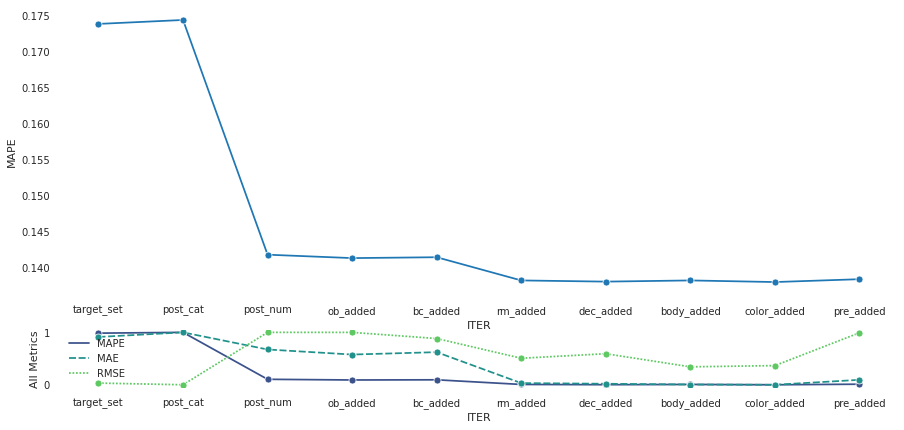

,target_set,post_cat,post_num,ob_added,bc_added,rm_added,dec_added,body_added,color_added,pre_added
MAPE,0.1738,0.1743,0.1418,0.1414,0.1415,0.1383,0.1381,0.1383,0.1380,0.1384
MAE,1664.7240,1675.0652,1636.6076,1625.2435,1630.6258,1561.0964,1559.6489,1557.9206,1557.3587,1568.4450
RMSE,4951.5050,4941.1828,5260.0485,5259.8889,5222.5177,5102.4822,5130.0938,5050.2973,5057.7758,5257.2457


In [119]:
# Расчет и запись метрик
results['pre_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

In [120]:
# Признак ухудшил метрику, удалим признак
cat_cols.remove('premium')
data.drop('premium', axis=1, inplace=True)

### Итог:

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


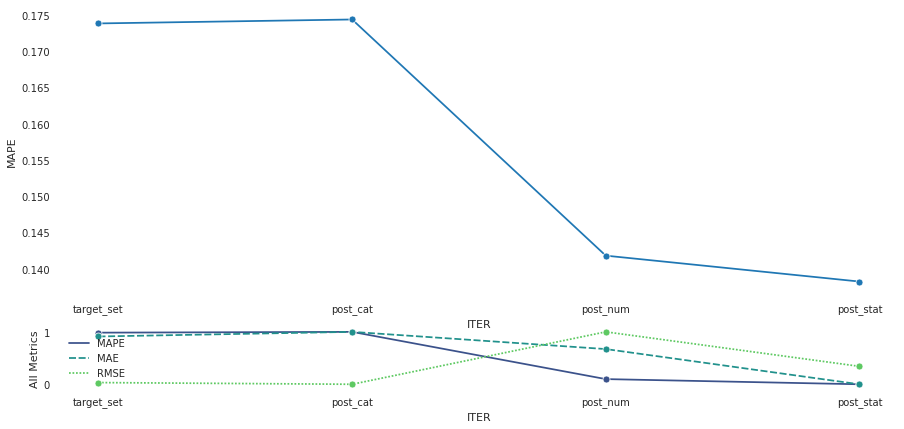

,target_set,post_cat,post_num,post_stat
MAPE,0.1738,0.1743,0.1418,0.1383
MAE,1664.7240,1675.0652,1636.6076,1557.9206
RMSE,4951.5050,4941.1828,5260.0485,5050.2973


In [121]:
# Удаление промежуточных шагов
results.drop(['ob_added', 'bc_added','rm_added','dec_added','body_added','color_added','pre_added'], axis=1, inplace=True)

# Расчет и запись метрик
results['post_stat'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

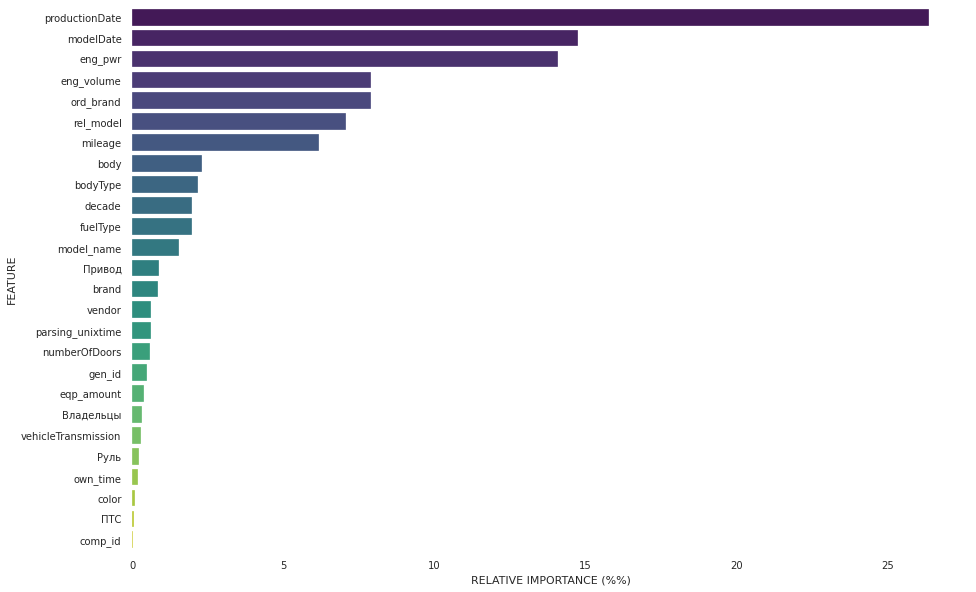

,productionDate,modelDate,eng_pwr,eng_volume,ord_brand,rel_model,mileage,body,bodyType,decade,fuelType,model_name,Привод,brand,vendor,parsing_unixtime,numberOfDoors,gen_id,eqp_amount,Владельцы,vehicleTransmission,Руль,own_time,color,ПТС,comp_id
score,26.3710,14.7583,14.0835,7.9016,7.8987,7.0690,6.1808,2.2983,2.1677,1.9947,1.9807,1.5495,0.8935,0.8633,0.6361,0.6262,0.6011,0.4813,0.3982,0.3187,0.2884,0.2375,0.2116,0.0955,0.0751,0.0198


In [122]:
get_feature_importance(data[data.train==1], 'eur_price')

В ходе расчета статистик, удалось добавить параметры, которые улучшили работу модели.

## PCA

In [123]:
# Удаление параметров: цены, modelDate, высокосколериванный с productionDate, и времени парсинга
train = data[data.train==1].reset_index()
PCA_features = train[num_cols].drop(['rur_price', 'usd_price', 'parsing_unixtime', 
                                     'productionDate', 'rur_price'], axis=1)

# Стандартизация числовых переменных, выделение целевой
A = MinMaxScaler().fit_transform(PCA_features.drop('eur_price', axis=1).values)
b = PCA_features.eur_price

In [124]:
# Применение метода главных компонент
pca = PCA(random_state = RS)
A_pca = pca.fit_transform(A)
component_names = [f"PC{i+1}" for i in range(A_pca.shape[1])]

A_pca = pd.DataFrame(A_pca, columns=component_names)
A_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.1431,-0.1059,0.0081,-0.0624,0.0824,-0.0112,-0.0018
1,-0.1332,-0.1032,0.0533,-0.0915,-0.0248,-0.0557,0.0004
2,-0.1470,-0.1015,-0.0081,-0.0288,-0.0042,-0.0053,-0.0014
3,-0.1184,-0.0531,0.0987,-0.0060,-0.0211,0.0612,-0.0016
4,-0.1390,-0.1039,0.0227,-0.0700,-0.0191,-0.0087,-0.0014


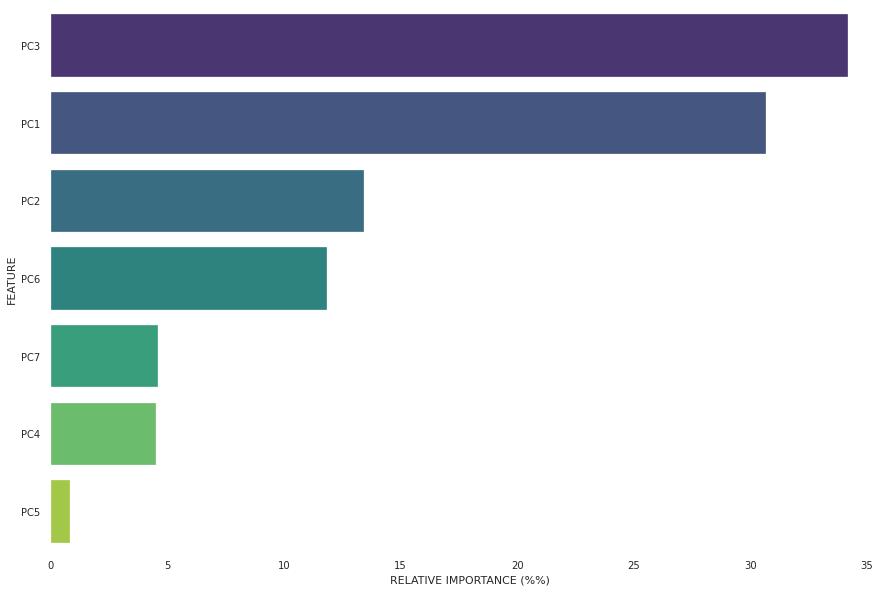

,PC3,PC1,PC2,PC6,PC7,PC4,PC5
score,34.1845,30.6746,13.4246,11.8185,4.5713,4.5007,0.8258


In [125]:
# Расчет важности компонент
M = CatBoostRegressor(random_seed = RS, silent=True)
M.fit(A_pca, np.log(b))
FI = pd.Series(M.get_feature_importance(), index=component_names).sort_values(ascending=False)
    
# Визуализация
plt.figure(figsize=(15,10))
ax = sns.barplot(x=FI.values, y=FI.index, palette = 'viridis')
ax.set(ylabel='FEATURE', xlabel='RELATIVE IMPORTANCE (%%)')
plt.show()
display(pd.DataFrame(FI, columns=['score']).T)

In [126]:
# Датафрейм для анализа результатов
for_analysis = pd.DataFrame(A, columns=PCA_features.drop('eur_price', axis=1).columns)
for_analysis['target'] = b

### Наиболее полезная компонента

In [127]:
# Голова и хвост выборки, упорядоченной по наиболее полезной компоненте
idx = A_pca[FI.index[0]].sort_values(ascending=False).index

display(for_analysis.loc[idx].head(10))
display(for_analysis.loc[idx].tail(10))

,mileage,modelDate,numberOfDoors,eng_volume,eng_pwr,own_time,rel_model,target
8127,1.0000,0.2759,0.8000,0.0057,0.0104,0.0000,0.8507,3328.0000
39779,1.0000,0.6983,1.0000,0.0080,0.0948,0.0000,0.7468,4968.0000
110637,1.0000,0.7328,1.0000,0.0140,0.1753,0.0813,0.9764,6129.0000
109600,0.9900,0.7500,1.0000,0.0043,0.0753,0.0606,0.6929,669.0000
39785,1.0000,0.6983,1.0000,0.0100,0.1623,0.1107,0.7468,2594.0000
14327,1.0000,0.8276,1.0000,0.0053,0.0935,0.0000,0.7143,2539.0000
39742,1.0000,0.7931,1.0000,0.0090,0.1234,0.0000,0.7468,2318.0000
114762,1.0000,0.6810,1.0000,0.0053,0.0519,0.0000,0.2432,780.0000
13331,1.0000,0.7069,0.8000,0.0083,0.0714,0.0000,0.7660,6101.0000
57192,1.0000,0.7931,1.0000,0.0113,0.1922,0.0000,0.9213,5792.0000


,mileage,modelDate,numberOfDoors,eng_volume,eng_pwr,own_time,rel_model,target
107483,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,184961.0000
107436,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,206515.0000
107438,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,162502.0000
107493,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,205244.0000
107465,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,184196.0000
107497,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,166792.0000
107476,0.0000,0.9741,0.4000,0.0133,0.7558,0.0000,0.7612,176814.0000
107551,0.0046,0.9655,0.4000,0.0183,0.7208,0.0000,0.5970,88035.0000
8052,0.0140,0.9138,0.4000,0.0183,0.7026,0.0000,0.3134,46588.0000
8059,0.0417,0.8793,0.4000,0.0200,0.7558,0.0000,0.3134,33277.0000


Судя по выборке, компонента основана на numberOfDoors и mileage.

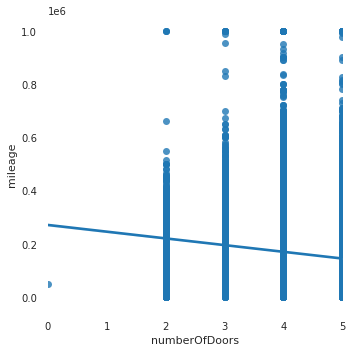

In [128]:
sns.lmplot(data=data[data.train==1], x='numberOfDoors', y='mileage', palette = 'viridis')

Можно предположить, что кол-во дверей коррелирует с размером авто. Судя по тому, что пробег с ростом кол-ва дверей снижется, возможно срок службы для больших авто ниже.

Создадим переменную rel_mileage, с отношением пройденых км к кол-ву дверей.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


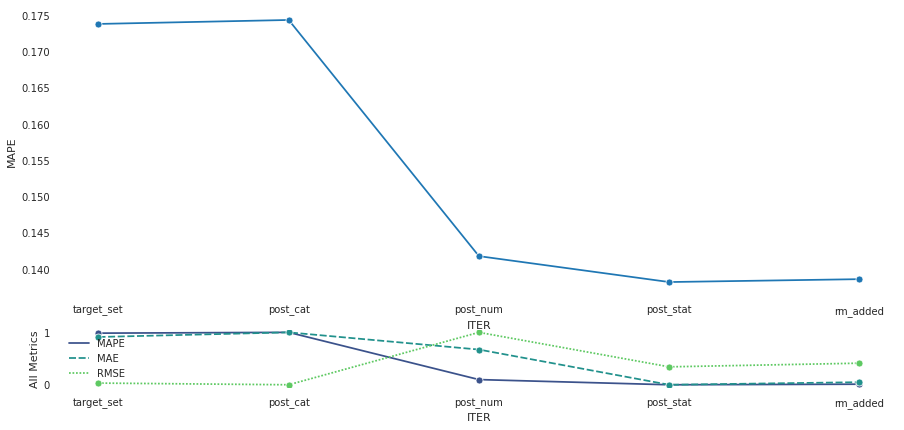

,target_set,post_cat,post_num,post_stat,rm_added
MAPE,0.1738,0.1743,0.1418,0.1383,0.1387
MAE,1664.7240,1675.0652,1636.6076,1557.9206,1563.7097
RMSE,4951.5050,4941.1828,5260.0485,5050.2973,5072.5223


In [129]:
data['rel_mileage'] = data['mileage']/(data['numberOfDoors']+1)
num_cols.append('rel_mileage')

# Рассчет и запись метрик
results['rm_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Признак снижает целевую метрику и может быть удален.

В целом, так как не удолось синтезировать полезный признак на основе наиболее полезной компоненты, не имеет смысла анализировать дальнейшие.

In [130]:
# Удаление rel_mileage
num_cols.remove('rel_mileage')
data.drop('rel_mileage', axis=1, inplace=True)

# Удаление промежуточных шагов
results.drop(['rm_added'], axis=1, inplace=True)

## Текст

### Equipment

Для наиболее популярных опций (встречаются более 50 раз), попытаемся рассчитать вклад в цену авто. Для этого будут использованы коэффициенты линейной регрессии.

In [131]:
# Создание вспомогательного dataframe для обработки
for_processing = data[(data.train==1)&(data.eqp_amount>0)].dropna(axis = 0, subset = ['eqp_options']).copy()
for_processing = for_processing[['sell_id','eqp_options','eur_price']].drop_duplicates(subset='sell_id')
display(for_processing.shape)
for_processing.sample(3)

(48609, 3)

,sell_id,eqp_options,eur_price
28631,1103383794.0000,"[cruise-control, asr, tinted-glass, esp, adapt...",68444.0000
70047,1102494258.0000,"[alloy-wheel-disks, tinted-glass, feedback-ala...",8029.0000
70158,1102353384.0000,"[steel-wheels, spare-wheel]",10036.0000


In [132]:
# Уникальные значения, встречающиеся более 50 раз
all_options = []
for i in tqdm(for_processing.index):
    all_options += for_processing.loc[i]['eqp_options']
all_options = pd.Series(all_options).value_counts()
all_options = list(all_options[all_options>50].index)
print('Unique options: ',len(all_options))


Unique options:  176


In [133]:
# Функция проверяет наличие опции в списке
def get_eqp_dummy(option, eqp_list):
    if option in eqp_list:
        return 1
    else:
        return 0

In [134]:
# Dummy-кодирование
for option in tqdm(all_options):
    for_processing[option] = for_processing.eqp_options.apply(lambda x: get_eqp_dummy(option, x))

In [135]:
for_processing.sample(3)

,sell_id,eqp_options,eur_price,abs,lock,electro-mirrors,computer,front-seats-heat,immo,airbag-driver,electro-window-front,ptf,airbag-passenger,aux,esp,usb,...,laser-lights,night-vision,seats-8,adj-pedals,22-inch-wheels,laminated-safety-glass,duo-body-color,ya-auto,seats-6,armored,13-inch-wheels,airbrush,front-camera,seats-2,electro-window-all,seats-heat
73759,1092835368.0000,"[engine-proof, tinted-glass, eco-leather, aux,...",6691.0000,1,1,1,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29234,1102847006.0000,"[asr, airbag-driver, aux, usb, isofix, light-s...",26130.0000,1,1,1,1,1,0,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53819,1103392510.0000,"[asr, esp, usb, multi-wheel, spare-wheel, heat...",21548.0000,1,1,1,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [136]:
# Обучение линейной регрессии
X = for_processing[for_processing.columns[3:]]
y = for_processing['eur_price']
LR = LinearRegression()
LR.fit(X,y)

LinearRegression()

In [137]:
# Словарь с парами опция-коэффициент
options_coef = {}
for i in range(len(all_options)):
    options_coef[X.columns[i]] = LR.coef_[i]

In [138]:
# Функция возвращает сумму коэфициентов для списка eqp_options
def get_eqp_rating(row):
    if row.eqp_amount > 0:
        rating = 0
        for option in row.eqp_options:
            try:
                rating += options_coef[option]
            except:
                rating += 0
        return rating
    else:
        return None

#### Заполнение:

In [139]:
# Применение функции
data['eqp_amount'] = data.eqp_amount.fillna(0)
data['eqp_rating'] = data.progress_apply(get_eqp_rating, axis=1)

EQP_RATING
mean    0.0024
std     1.0044
min    -2.3004
25%    -0.6107
50%    -0.3138
75%     0.3494
max     7.6636
Name: eqp_rating, dtype: float64
Кол-во выбросов: 3102 	 (%%: 2.49)



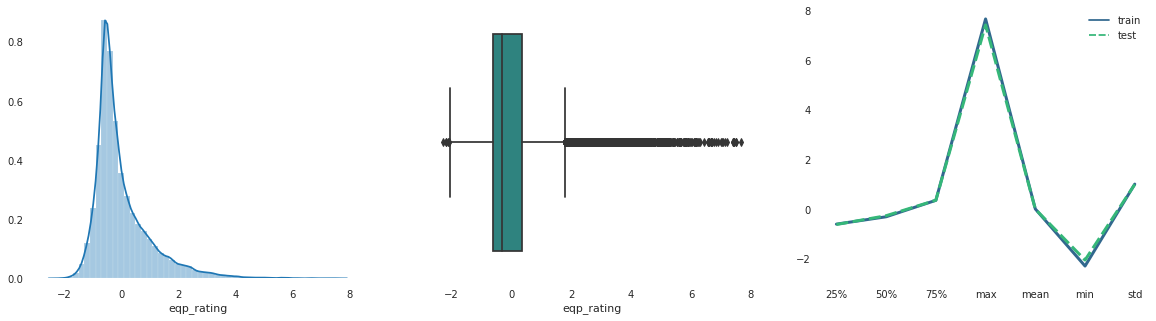

In [140]:
# Стандартизация и визуализация признака
data['eqp_rating'] = StandardScaler().fit_transform(data.eqp_rating.values.reshape(-1, 1))
sum_up_num(data, 'eqp_rating', 'eur_price')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


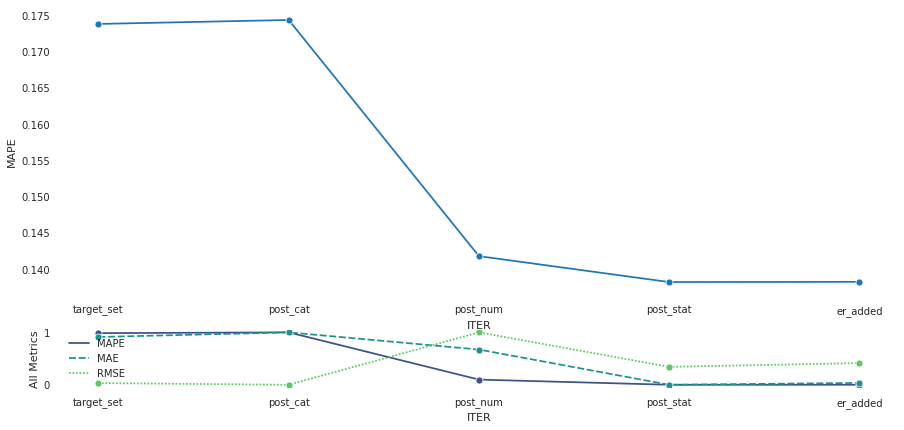

,target_set,post_cat,post_num,post_stat,er_added
MAPE,0.1738,0.1743,0.1418,0.1383,0.1383
MAE,1664.7240,1675.0652,1636.6076,1557.9206,1562.0415
RMSE,4951.5050,4941.1828,5260.0485,5050.2973,5073.1159


In [141]:
num_cols.append('eqp_rating')

# Расчет и запись метрик
results['er_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Добавление eqp_rating немного улучшает модель c точки зрения предсказания выбросов (RSME снизился).

### Description

In [142]:
# Токинизатор
CVec = CountVectorizer(stop_words=stopwords.words('russian')).build_analyzer()

In [143]:
# Создание вспомогательного dataframe, токенизация текста
for_processing = data.dropna(axis = 0, subset = ['description']).copy()
for_processing = for_processing[['sell_id','description']].drop_duplicates(subset='sell_id')
for_processing['wordbox'] = for_processing.description.progress_apply(lambda x: CVec(x))
for_processing.sample(3)

,sell_id,description,wordbox
58452,1102815865.0000,"• ПРОДАЖА, обмен, СРОЧНЫЙ ВЫКУП , комиссия авт...","[продажа, обмен, срочный, выкуп, комиссия, авт..."
95596,1092566476.0000,Автомобиль покупался у официального дилера в 2...,"[автомобиль, покупался, официального, дилера, ..."
85074,1100927730.0000,Настоящий немец. Бензин. Заказывали в индивиду...,"[настоящий, немец, бензин, заказывали, индивид..."


In [144]:
# Модель преобразования слов в вектора
dimensions = 10
word_model = Word2Vec(for_processing.wordbox, min_count=50, size=dimensions)

In [145]:
# Функция возвращает усредненный вектор документа на основе векторов слов
def doc_vectorizer(doc, model=word_model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model[word]
            else:
                doc_vector = np.add(doc_vector, model[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

In [146]:
# Применение функции
for_processing['box_vec'] = for_processing.wordbox.progress_apply(doc_vectorizer)
for_processing['vec_dems'] = for_processing.box_vec.apply(lambda x: len(x))
for_processing = for_processing[for_processing.vec_dems>0].drop('vec_dems',axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [147]:
# Добавление векторов в dataframe
for i in tqdm(range(1,dimensions+1)):
    for_processing['vec_{}'.format(i)] = for_processing.box_vec.apply(lambda x: x[i-1])

In [148]:
for_processing.sample(3)

,sell_id,description,wordbox,box_vec,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,vec_10
97295,1101293169.0000,Установлена дорогая сигнализация с приложением...,"[установлена, дорогая, сигнализация, приложени...","[-2.8366902, 0.5532189, 0.13356476, 2.740971, ...",-2.8367,0.5532,0.1336,2.7410,-0.9856,-1.3819,0.8650,-1.1962,1.6718,1.3838
42355,1102767723.0000,"Автомобиль в хорошем состоянии, по ходовой час...","[автомобиль, хорошем, состоянии, ходовой, част...","[0.21970797, 3.7043803, 4.741637, 1.7237227, -...",0.2197,3.7044,4.7416,1.7237,-0.7520,-0.8449,3.8812,0.5718,2.1472,-3.0326
695,1102886951.0000,Автомобиль 2014 г.в. в отличном состоянии! Оди...,"[автомобиль, 2014, отличном, состоянии, владел...","[3.6688812, 1.0154543, -0.38469627, 2.346743, ...",3.6689,1.0155,-0.3847,2.3467,1.6461,-1.8631,1.5068,-0.2519,-0.8752,-3.6930


In [149]:
# Функция возвращает коэффициент силуэта для кол-ва кластеров
def k_means(nc):
    kmeans = KMeans(n_clusters=nc, random_state=RS)
    X = for_processing[for_processing.columns[4:]]
    kmeans.fit(X)
    pred = kmeans.labels_.astype(np.int)+1
    return silhouette_score(X, pred, metric='euclidean')

In [150]:
# Применение функции
kmeans_scores = pd.DataFrame({'n_clusters':[5,10,20]})
kmeans_scores['score'] = kmeans_scores.n_clusters.progress_apply(k_means)
kmeans_scores

,n_clusters,score
0,5,0.2165
1,10,0.1969
2,20,0.1618


Кэффициент силуэта невысокий и снижается с увеличением кол-ва кластеров. Для предсказания будем использовать 5 кластеров.

In [151]:
# Предсказание кластера
kmeans = KMeans(n_clusters=5, random_state=RS)
kmeans.fit(for_processing[for_processing.columns[4:]])
for_processing['desc_cluster'] = kmeans.labels_.astype(np.int)+1

In [152]:
for_processing.sample(3)

,sell_id,description,wordbox,box_vec,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,vec_10,desc_cluster
9730,1103134210.0000,"Учёт РФ! Автомобиль в ОТС , крашеные бампера и...","[учёт, рф, автомобиль, отс, крашеные, бампера,...","[-1.9237, 0.8673337, 2.4142582, 0.60696286, -2...",-1.9237,0.8673,2.4143,0.6070,-2.3274,0.1074,2.0751,-1.4426,1.0388,-1.8127,2
67311,1103386231.0000,"Автомобиль в идеальном состоянии, своевременно...","[автомобиль, идеальном, состоянии, своевременн...","[-2.03303, 1.5056288, 0.6751852, 3.025233, -1....",-2.0330,1.5056,0.6752,3.0252,-1.0909,-0.8468,1.4625,-2.6554,2.5731,-0.4353,2
22915,1101085477.0000,"Двигатель,коробка передач,сцепление в хорошем ...","[двигатель, коробка, передач, сцепление, хорош...","[-1.3934433, 1.8119425, 1.8758795, -0.2786633,...",-1.3934,1.8119,1.8759,-0.2787,-3.6419,-0.5511,2.1876,-0.2760,1.6997,-1.4364,2


In [153]:
# Словарь для быстрого заполненя.
mapping_dict = {}
for i in tqdm(for_processing.index):
    row = for_processing.loc[i]
    mapping_dict[row['sell_id']] = row['desc_cluster']

In [154]:
# Функция возвращает кластер по ID
def get_desc_cluster(sl_id):
    try:
        return mapping_dict[sl_id]
    except:
        return 0

In [155]:
# Применение функции
data['desc_cluster'] = data.sell_id.apply(get_desc_cluster)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


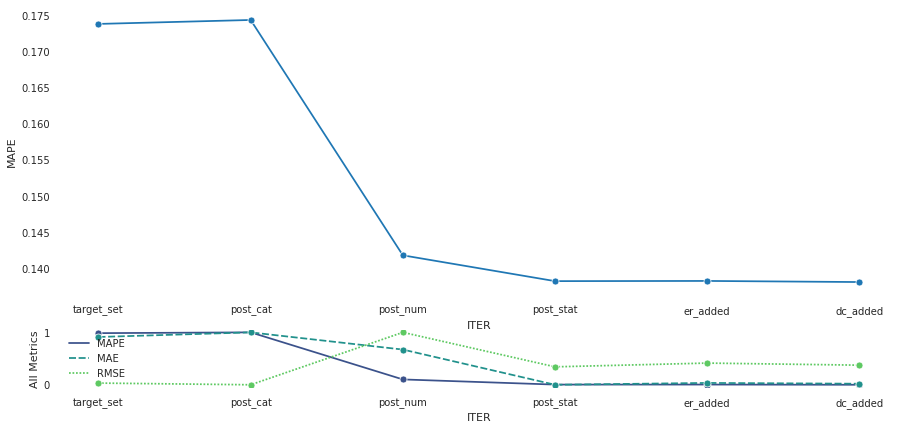

,target_set,post_cat,post_num,post_stat,er_added,dc_added
MAPE,0.1738,0.1743,0.1418,0.1383,0.1383,0.1381
MAE,1664.7240,1675.0652,1636.6076,1557.9206,1562.0415,1560.2654
RMSE,4951.5050,4941.1828,5260.0485,5050.2973,5073.1159,5060.4602


In [156]:
cat_cols.append('desc_cluster')

# Расчет и запись метрик
results['dc_added'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

Кластеризация текста немного снизила метрики.

### Итог:

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


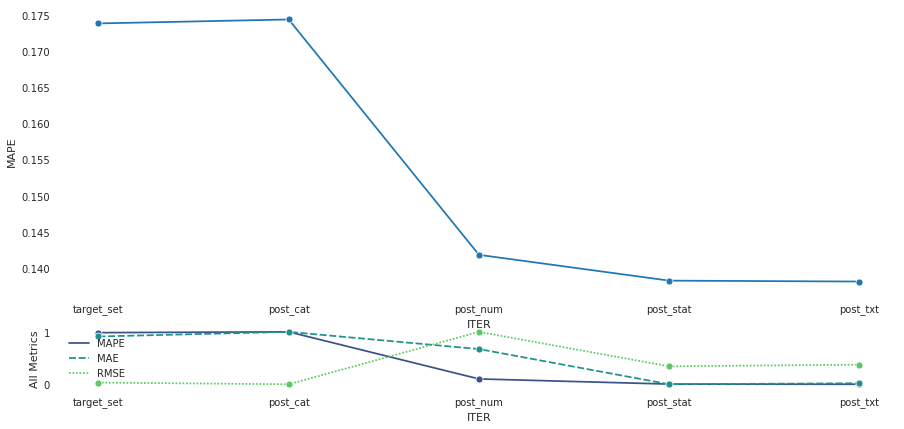

,target_set,post_cat,post_num,post_stat,post_txt
MAPE,0.1738,0.1743,0.1418,0.1383,0.1381
MAE,1664.7240,1675.0652,1636.6076,1557.9206,1560.2654
RMSE,4951.5050,4941.1828,5260.0485,5050.2973,5060.4602


In [157]:
# Удаление промежуточных шагов
results.drop(['er_added','dc_added'], axis=1, inplace=True)

# Расчет и запись метрик
results['post_txt'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

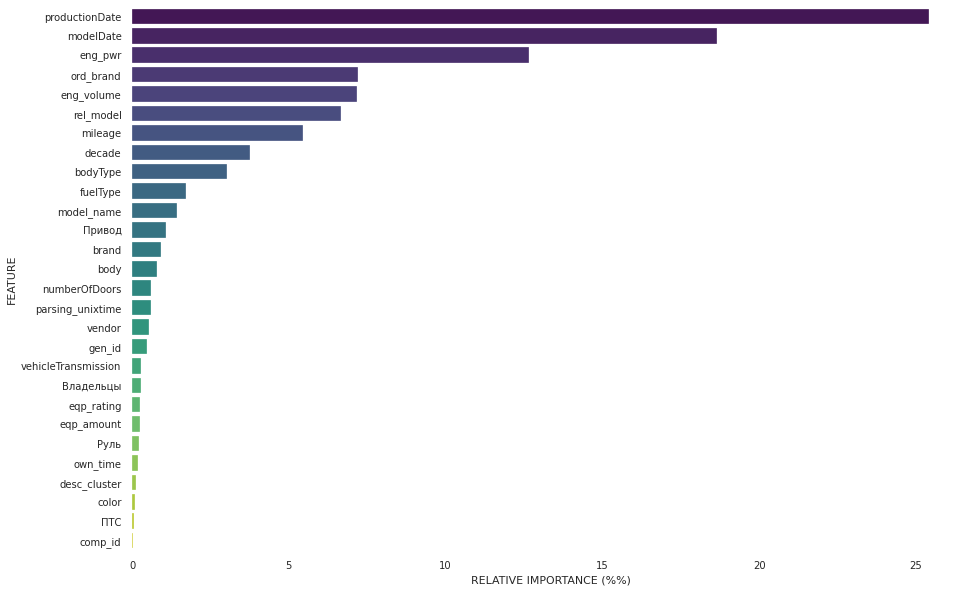

,productionDate,modelDate,eng_pwr,ord_brand,eng_volume,rel_model,mileage,decade,bodyType,fuelType,model_name,Привод,brand,body,numberOfDoors,parsing_unixtime,vendor,gen_id,vehicleTransmission,Владельцы,eqp_rating,eqp_amount,Руль,own_time,desc_cluster,color,ПТС,comp_id
score,25.4230,18.6553,12.6524,7.2039,7.1810,6.6549,5.4561,3.7682,3.0183,1.7327,1.4411,1.0733,0.9371,0.7847,0.6173,0.6007,0.5427,0.4681,0.2964,0.2876,0.2520,0.2428,0.2232,0.1815,0.1306,0.0838,0.0715,0.0198


In [158]:
get_feature_importance(data[data.train==1], 'eur_price')

В ходе обработки текста целевая метрика немного снизилась.

## Cleaning

### Числовые переменные

In [159]:
# Создание списка числовых переменных без целевых
cols_to_test = []
for col in num_cols:
    if col in ['rur_price','eur_price','usd_price']:
        continue
    else:
        cols_to_test.append(col)

In [160]:
# Тестирование и вывод параметров, после удаления которых MAPE снижается
cols_to_drop = []
last_mape = results.loc['MAPE'][results.columns[-1]]

for col in tqdm(cols_to_test):
    num_cols.remove(col)
    new_mape = metics(data[data.train==1], 'eur_price')[0]
    if new_mape < last_mape:
        last_mape = new_mape
        cols_to_drop.append(col)
    else:
        num_cols.append(col)

print('Список для удаления:', cols_to_drop)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in 


Список для удаления: ['parsing_unixtime', 'own_time']


### Категориальные переменные

In [161]:
# Копирование списка переменных
cols_to_test = []
for col in cat_cols:
    cols_to_test.append(col)
        
# Тестирование и вывод параметров, после удаления которых MAPE снижается
for col in tqdm(cols_to_test):
    cat_cols.remove(col)
    new_mape = metics(data[data.train==1], 'eur_price')[0]
    if new_mape < last_mape:
        last_mape = new_mape
        cols_to_drop.append(col)
    else:
        cat_cols.append(col)

print('Список для удаления:', cols_to_drop)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in 


Список для удаления: ['parsing_unixtime', 'own_time']


### Бинарные переменные

In [162]:
# Копирование списка переменных
cols_to_test = []
for col in bin_cols:
    cols_to_test.append(col)
        
# Тестирование и вывод параметров, после удаления которых MAPE снижается
for col in tqdm(cols_to_test):
    bin_cols.remove(col)
    new_mape = metics(data[data.train==1], 'eur_price')[0]
    if new_mape < last_mape:
        last_mape = new_mape
        cols_to_drop.append(col)
    else:
        bin_cols.append(col)

print('Список для удаления:', cols_to_drop)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Список для удаления: ['parsing_unixtime', 'own_time']


### Итог:

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


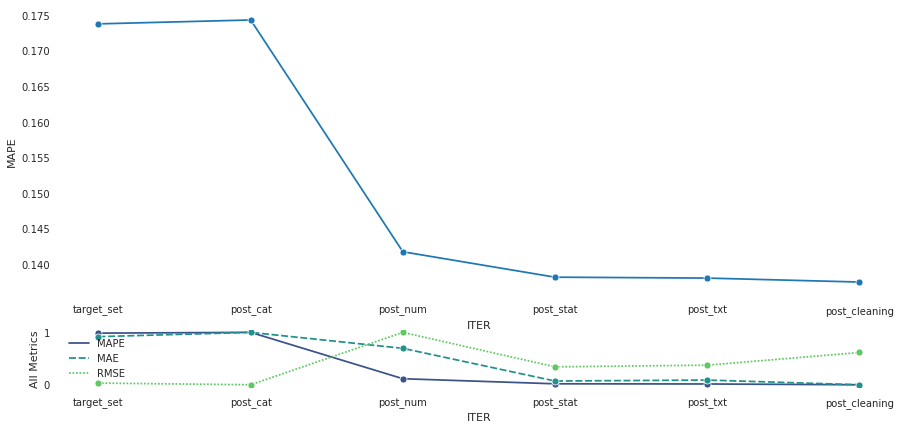

,target_set,post_cat,post_num,post_stat,post_txt,post_cleaning
MAPE,0.1738,0.1743,0.1418,0.1383,0.1381,0.1376
MAE,1664.7240,1675.0652,1636.6076,1557.9206,1560.2654,1548.9135
RMSE,4951.5050,4941.1828,5260.0485,5050.2973,5060.4602,5137.5233


In [163]:
# Расчет и запись метрик
results['post_cleaning'] = metics(data[data.train==1], 'eur_price')

# Визуализация
plot_results(results, 'MAPE')
results

In [164]:
# Удаление данных (время парсинга необходимо для постобработки)
if 'parsing_unixtime' in cols_to_drop:
    cols_to_drop.remove('parsing_unixtime')
data.drop(cols_to_drop, axis=1, inplace=True)

# Model Tuning & Prediction

## Встроенный подбор параметров CatBoost

In [165]:
# Функция возвращает метрики для данных и модели
def metics(data, target, model=CatBoostRegressor(random_seed = RS, silent=True)):
    df = data.copy()
    
    # Кодирование
    LE = LabelEncoder()
    for col in bin_cols+cat_cols:
        if df[col].dtype == object:
            df[col] = df[col].fillna('Non_specified')
            df[col] = df[col].apply(lambda x: str(x))
            df[col] = LE.fit_transform(df[col])
    
    # Разделение переменных
    X = df[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values
    y = df[target].values
    
    # Создание списков для записи локальных результатов
    local_mape = []
    local_mae = []
    local_mse = []
    
    # Моделирование с 3-ой кросс-валидацией
    SKF = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)
    for train_index, test_index in SKF.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, np.log(y_train), eval_set=(X_test, np.log(y_test)), verbose_eval=0, use_best_model=True) # <= Встроенная настройка
        preds = np.exp(model.predict(X_test))
        local_mape.append(MAPE(y_test, preds))
        local_mae.append(mean_absolute_error(y_test, preds))
        local_mse.append(mean_squared_error(y_test, preds)**(1/2))
    
    # Усреднение метрик
    result = []
    result.append(np.mean(local_mape))
    result.append(np.mean(local_mae))
    result.append(np.mean(local_mse))
    
    return result

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


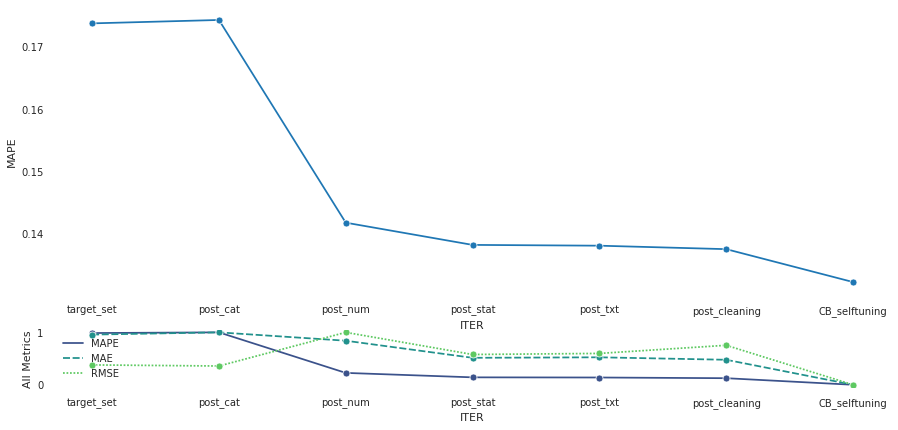

,target_set,post_cat,post_num,post_stat,post_txt,post_cleaning,CB_selftuning
MAPE,0.1738,0.1743,0.1418,0.1383,0.1381,0.1376,0.1323
MAE,1664.7240,1675.0652,1636.6076,1557.9206,1560.2654,1548.9135,1433.8433
RMSE,4951.5050,4941.1828,5260.0485,5050.2973,5060.4602,5137.5233,4763.4106


In [166]:
# Расчет и запись метрик
results['CB_selftuning'] = metics(data[data.train==1], 'eur_price', model=CatBoostRegressor(iterations = 10000, random_seed = RS, 
                                                                                            eval_metric='MAPE', custom_metric=['R2', 'MAE'], 
                                                                                            silent=True))

# Визуализация
plot_results(results, 'MAPE')
results

Результат модели стал лучше после встроенной настройки параметров в CatBoost

### Обучение модели

In [167]:
train = data[data.train==1]

# Кодирование
LE = LabelEncoder()
for col in bin_cols+cat_cols:
    if train[col].dtype == object:
        train[col] = train[col].fillna('Non_specified')
        LE.fit(train[col])
        train[col] = LE.transform(train[col])

# Разделение выборки
X = train[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values
y = train['eur_price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RS)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [168]:
# Создание модели
model = CatBoostRegressor(iterations = 10000,
                          random_seed = RS,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [169]:
# Предсказание теста
preds = np.exp(model.predict(X_test))
MAPE(y_test, preds)

0.1332075155490699

## Дополнительные модели

Для улучшения результата, блэндинга и стэкинга будут использованы следующие модели:
- Две базовые модели для противоположных эстремальных подходов:
> - Глубокое дерево для максимального заучивания данных
> - Линейная регрессия для отображения общего тренда

- Альтернативные ансамбли:
> - Стандартный бэггинг RandomForest
> - Extra Trees, найденный при помощи Lazy Predict в отдельном ноутбуке
> - Базовый градиентный бустинг от sklearn
> - Light GBM, найденный при помощи Lazy Predict в отдельном ноутбуке

### Обработка данных

,vendor,Руль,bodyType,brand,color,fuelType,model_name,vehicleTransmission,Владельцы,ПТС,Привод,comp_id,gen_id,eqp_amount,ord_brand,decade,body,desc_cluster,eur_price,mileage,modelDate,numberOfDoors,productionDate,eng_volume,eng_pwr,rel_model,eqp_rating,train,sell_id
33766,EUROPEAN,Левый,купе,BMW,белый,дизель,3ER,автоматическая,2 владельца,Оригинал,задний,0,3659007,42,9,6,купе,4,9935.0000,225500.0000,2008.0000,2.0000,2013.0000,2.0000,184.0000,0.3947,-0.1234,1,1102484199.0000
67682,EUROPEAN,Левый,седан,VOLKSWAGEN,белый,бензин,PASSAT,механическая,1 владелец,Оригинал,передний,0,2309871,4,4,6,седа,3,6921.0000,160403.0000,2005.0000,4.0000,2010.0000,1.8000,152.0000,0.6216,-0.2509,1,1103318906.0000
114971,EUROPEAN,Левый,седан,AUDI,синий,бензин,A4,вариатор,2 владельца,Оригинал,передний,0,None,0,8,3,седа,1,4680.0000,200000.0000,2004.0000,4.0000,2007.0000,2.0000,200.0000,0.3333,nan,1,None


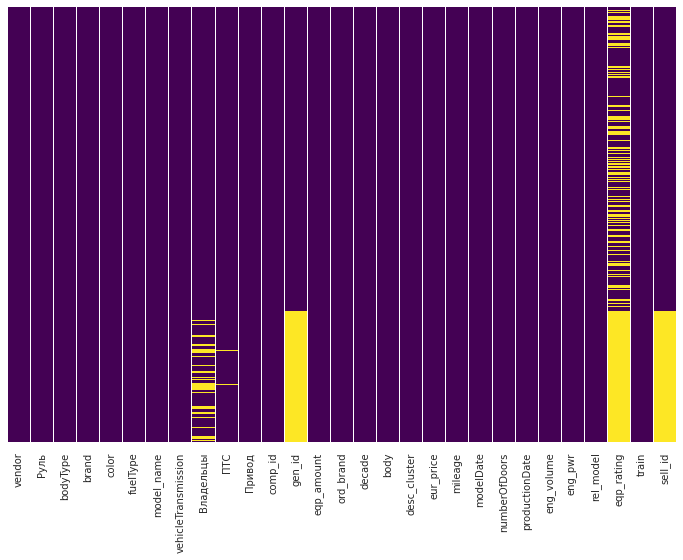

ВЛАДЕЛЬЦЫ
%% пропущенных данных в столбце: 	7.0
(%% от общего кол-ва данных: 	0.0)

ПТС
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

GEN_ID
%% пропущенных данных в столбце: 	30.0
(%% от общего кол-ва данных: 	1.0)

EQP_RATING
%% пропущенных данных в столбце: 	54.0
(%% от общего кол-ва данных: 	2.0)

SELL_ID
%% пропущенных данных в столбце: 	30.0
(%% от общего кол-ва данных: 	1.0)

Бинарные данные: 	 ['vendor', 'Руль']

Категориальные данные: 	 ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'comp_id', 'gen_id', 'eqp_amount', 'ord_brand', 'decade', 'body', 'desc_cluster']

Числовые данные: 	 ['rur_price', 'eur_price', 'usd_price', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'eng_volume', 'eng_pwr', 'rel_model', 'eqp_rating']


In [170]:
# Копия датафрейма
alt_data = data[bin_cols+cat_cols+num_cols+['train','sell_id']].drop(['rur_price', 'usd_price'], axis=1)
display(alt_data.sample(3))

na_values(alt_data)

print('Бинарные данные: \t', bin_cols)
print()
print('Категориальные данные: \t', cat_cols)
print()
print('Числовые данные: \t', num_cols)

Необходимо понять, как кодировать категориальные переменные:

In [171]:
short_cols = []
long_cols = []
for col in cat_cols:
    if len(alt_data[col].unique()) < 15:
        short_cols.append(col)
    else:
        long_cols.append(col)
print('Переменные для dummy-кодирования: \t', short_cols)
print()
print('Переменные для статистик: \t', long_cols)

Переменные для dummy-кодирования: 	 ['brand', 'fuelType', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'ord_brand', 'decade', 'desc_cluster']

Переменные для статистик: 	 ['bodyType', 'color', 'model_name', 'comp_id', 'gen_id', 'eqp_amount', 'body']


- В данном случае, не имеет смысла dummy-кодировать ord_brand, т.к. переменная продублирует brand.
- eqp_amount скорее числовой признак.
- По model_name уже есть числовой rel_model

In [172]:
# Правки
alt_data.drop('ord_brand', axis=1, inplace=True)
short_cols.remove('ord_brand')

long_cols.remove('eqp_amount')

alt_data.drop('model_name', axis=1, inplace=True)
long_cols.remove('model_name')

In [173]:
# Создание dummy-переменных. Для параметров с пропусками помечаем пропуски.
for col in short_cols:
    if len(alt_data[col].isna().unique())>1:
        alt_data = pd.get_dummies(alt_data, dummy_na=True, columns=[col])
    else:
        alt_data = pd.get_dummies(alt_data, dummy_na=False, columns=[col])

alt_data.sample(3)

,vendor,Руль,bodyType,color,comp_id,gen_id,eqp_amount,body,eur_price,mileage,modelDate,numberOfDoors,productionDate,eng_volume,eng_pwr,rel_model,...,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9,decade_10,desc_cluster_0,desc_cluster_1,desc_cluster_2,desc_cluster_3,desc_cluster_4,desc_cluster_5
104720,JAPANESE,Левый,седан,пурпурный,0,21296296,5,седа,0.0000,346000.0000,1995.0000,4.0000,1997.0000,1.8000,116.0000,0.3191,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
70856,EUROPEAN,Левый,хэтчбек 5 дв.,красный,0,3492985,0,хэтч,1505.0000,271000.0000,1991.0000,5.0000,1996.0000,2.0000,115.0000,0.2432,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
115717,EUROPEAN,Левый,седан,серый,0,None,0,седа,4959.0000,197000.0000,2004.0000,4.0000,2004.0000,3.0000,218.0000,0.5385,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Заполним gen_id и eqp_rating. В случае с gen_id, это позволит отделить пропуски от остальных данных. Для eqp_rating, 0 - среднеарифметическое.

In [174]:
# Заполнение пропусков
alt_data.fillna(0, inplace=True)
alt_data.sample(3)

,vendor,Руль,bodyType,color,comp_id,gen_id,eqp_amount,body,eur_price,mileage,modelDate,numberOfDoors,productionDate,eng_volume,eng_pwr,rel_model,...,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9,decade_10,desc_cluster_0,desc_cluster_1,desc_cluster_2,desc_cluster_3,desc_cluster_4,desc_cluster_5
66432,EUROPEAN,Левый,внедорожник 5 дв.,чёрный,0,20197631,8,внед,32059.0000,80000.0000,2014.0000,5.0000,2018.0000,3.6000,249.0000,0.9459,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
125661,EUROPEAN,Левый,внедорожник 5 дв.,серый,21661580,0,0,внед,34416.0000,0.0000,2019.0000,5.0000,2020.0000,2.0000,150.0000,0.2632,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
5212,JAPANESE,Правый,минивэн,чёрный,0,20284345,0,мини,12812.0000,89000.0000,2009.0000,5.0000,2017.0000,1.6000,109.0000,0.6709,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


Для категориальных переменных с большим кол-вом переменных, заменим их на стандартизированное среднее значение целовой для каждого уникального значения.

Для значений, которые есть в тесте, но отсутствуют в трейне, берется самое частое значение полученной статистики.

In [175]:
for col in long_cols:
    means = (alt_data[alt_data.train==1].groupby(col).eur_price.mean() / alt_data.eur_price.std()).to_dict()
    alt_data['{}_stat'.format(col)] = alt_data[col].map(means)
    alt_data['{}_stat'.format(col)] = alt_data['{}_stat'.format(col)].fillna(alt_data['{}_stat'.format(col)].value_counts().index[0])
    alt_data.drop(col, axis=1, inplace=True)
alt_data.sample(3)

,vendor,Руль,eqp_amount,eur_price,mileage,modelDate,numberOfDoors,productionDate,eng_volume,eng_pwr,rel_model,eqp_rating,train,sell_id,brand_AUDI,brand_BMW,...,decade_6,decade_7,decade_8,decade_9,decade_10,desc_cluster_0,desc_cluster_1,desc_cluster_2,desc_cluster_3,desc_cluster_4,desc_cluster_5,bodyType_stat,color_stat,comp_id_stat,gen_id_stat,body_stat
69673,EUROPEAN,Левый,24,4895.0000,187000.0000,2010.0000,4.0000,2013.0000,1.6000,105.0000,0.5405,0.1355,1,1103121844.0000,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0.5536,1.1039,0.5726,0.3700,0.6006
40566,JAPANESE,Левый,0,3367.0000,200000.0000,2006.0000,4.0000,2006.0000,1.6000,107.0000,0.2532,0.0000,1,1088104062.0000,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0.5536,0.7402,0.5726,0.1785,0.6006
11819,EUROPEAN,Левый,27,16528.0000,199950.0000,2010.0000,4.0000,2013.0000,2.0000,180.0000,0.8108,0.2249,1,1103279754.0000,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0.9048,0.8530,0.8648,0.7659,0.9147


Перекодировка бинарных признаков:

In [176]:
LE = LabelEncoder()
for col in bin_cols:
    alt_data[col] = LE.fit_transform(alt_data[col])
alt_data.sample(3)

,vendor,Руль,eqp_amount,eur_price,mileage,modelDate,numberOfDoors,productionDate,eng_volume,eng_pwr,rel_model,eqp_rating,train,sell_id,brand_AUDI,brand_BMW,...,decade_6,decade_7,decade_8,decade_9,decade_10,desc_cluster_0,desc_cluster_1,desc_cluster_2,desc_cluster_3,desc_cluster_4,desc_cluster_5,bodyType_stat,color_stat,comp_id_stat,gen_id_stat,body_stat
64199,1,0,0,10025.0000,196000.0000,2006.0000,4.0000,2008.0000,4.6000,380.0000,0.7857,0.0000,1,1103189593.0000,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0.5536,1.1039,0.5726,0.5744,0.6006
133194,1,0,0,5850.0000,158000.0000,2007.0000,5.0000,2007.0000,2.0000,141.0000,0.9367,0.0000,1,0.0000,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1.2145,1.1039,0.5726,1.0032,1.2049
107024,0,0,52,0.0000,189000.0000,2011.0000,4.0000,2011.0000,2.8000,204.0000,0.5385,-0.2086,0,1101329988.0000,1,0,...,1,0,0,0,0,0,1,0,0,0,0,0.5536,0.4502,0.5726,1.0032,0.6006


### Оценка

К сожалению, мощность компьютеров не позволила протестировать алгоритмы с оптимальными гиперпараметрами. Для тех алгоритмов, у которых оптимальные гиперпараметры были найдены, такая версия будет приведена в комментариях.

In [177]:
# Функция возвращает метрики для данных и модели (MAPE с кросс-валидацией и без нее)
def alt_metics(data, target, model=CatBoostRegressor(random_seed = RS, silent=True)):
    df = data[data.train==1].drop(['train','sell_id'], axis=1).copy()
    
    # Разделение переменных
    X = df.drop(target, axis=1).values
    y = df[target].values
    
    # Создание списков для записи локальных результатов
    local_mape = []
    
    # Моделирование с 3-ой кросс-валидацией
    SKF = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)
    for train_index, test_index in SKF.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, np.log(y_train))
        preds = np.exp(model.predict(X_test))
        local_mape.append(MAPE(y_test, preds))
    
    # Усреднение метрики
    result = []
    result.append(np.mean(local_mape))
    
    # Добавление метрики без кросс-валидации
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RS)
    model.fit(X_train, np.log(y_train))
    preds = np.exp(model.predict(X_test))
    result.append(MAPE(y_test, preds))
    
    return result

### DecisionTree

In [178]:
from sklearn.tree import DecisionTreeRegressor

In [179]:
# Параметры подобраны в отдельном ноутбуке
#DT = DecisionTreeRegressor(splitter='random', 
                           #min_samples_split=10, 
                           #min_samples_leaf=4, 
                           #max_features='auto', 
                           #max_depth=90, 
                           #random_state=RS)
DT = DecisionTreeRegressor(random_state=RS)

alt_results = pd.DataFrame({'CB': [results.loc['MAPE']['CB_selftuning'], MAPE(y_test, preds)]}, 
                           index = ['CV','TST0.3'])

alt_results['DT'] = alt_metics(alt_data, 'eur_price', model=DT)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT
CV,0.1323,0.2024
TST0.3,0.1332,0.1993


### Linear regression

In [180]:
LR = LinearRegression(n_jobs=-1)
alt_results['LR'] = alt_metics(alt_data, 'eur_price', model=LR)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR
CV,0.1323,0.2024,7785.8941
TST0.3,0.1332,0.1993,0.2202


In [181]:
# Функция возвращает метрики для нормализованных данных и модели (MAPE с кросс-валидацией и без нее)
def norm_alt_metics(data, target, scaler, model=CatBoostRegressor(random_seed = RS, silent=True)):
    df = data[data.train==1].drop(['train','sell_id'], axis=1).copy()
    
    # Разделение переменных
    X = df.drop(target, axis=1).values
    X = scaler.fit_transform(X) 
    y = df[target].values
    
    # Создание списков для записи локальных результатов
    local_mape = []
    
    # Моделирование с 3-ой кросс-валидацией
    SKF = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)
    for train_index, test_index in SKF.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, np.log(y_train))
        preds = np.exp(model.predict(X_test))
        local_mape.append(MAPE(y_test, preds))
    
    # Усреднение метрики
    result = []
    result.append(np.mean(local_mape))
    
    # Добавление метрики без кросс-валидации
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RS)
    model.fit(X_train, np.log(y_train))
    preds = np.exp(model.predict(X_test))
    result.append(MAPE(y_test, preds))
    
    return result

In [182]:
# Построим линейную регрессию, построенную на признаках, нормализованных с помощью StandardScaler
LR = LinearRegression(n_jobs=-1)

alt_results['LR(ss)'] = norm_alt_metics(alt_data, 'eur_price', scaler=RobustScaler(), model=LR)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR,LR(ss)
CV,0.1323,0.2024,7785.8941,7968.6643
TST0.3,0.1332,0.1993,0.2202,0.2202


In [183]:
# Построим линейную регрессию, построенную на признаках, нормализованных с помощью RobustScaler
from sklearn.preprocessing import RobustScaler

LR = LinearRegression(n_jobs=-1)

alt_results['LR(rs)'] = norm_alt_metics(alt_data, 'eur_price', scaler=RobustScaler(), model=LR)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR,LR(ss),LR(rs)
CV,0.1323,0.2024,7785.8941,7968.6643,7968.6643
TST0.3,0.1332,0.1993,0.2202,0.2202,0.2202


Линейная регрессия работает плохо, что было ожидаемо. Стандартизация не даёт улучшений.

In [184]:
alt_results.drop(['LR(ss)','LR(rs)'], axis=1, inplace=True)

### Random Forest

In [185]:
# Параметры подобраны в отдельном ноутбуке
#RF = RandomForestRegressor(n_estimators=1400, min_samples_split=5, 
                           #min_samples_leaf=1, max_features='sqrt', 
                           #max_depth=80, bootstrap=False, random_state=RS)
RF = RandomForestRegressor(random_state=RS)

alt_results['RF'] =  alt_metics(alt_data, 'eur_price', model=RF)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR,RF
CV,0.1323,0.2024,7785.8941,0.1370
TST0.3,0.1332,0.1993,0.2202,0.1377


### Extra Trees

In [186]:
from sklearn.ensemble import ExtraTreesRegressor

In [187]:
# Параметры по умолчанию
ET = ExtraTreesRegressor(random_state=RS)

alt_results['ET'] =  alt_metics(alt_data, 'eur_price', model=ET)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR,RF,ET
CV,0.1323,0.2024,7785.8941,0.1370,0.1414
TST0.3,0.1332,0.1993,0.2202,0.1377,0.1426


### Gradient Boosting

In [188]:
# Параметры по умолчанию
GB = GradientBoostingRegressor(random_state=RS)

alt_results['GB'] =  alt_metics(alt_data, 'eur_price', model=GB)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR,RF,ET,GB
CV,0.1323,0.2024,7785.8941,0.1370,0.1414,0.1807
TST0.3,0.1332,0.1993,0.2202,0.1377,0.1426,0.1821


### Light  GBM

In [189]:
from lightgbm import LGBMRegressor

In [190]:
# Параметры по умолчанию
LGBM = LGBMRegressor(random_state=RS)

alt_results['LGBM'] =  alt_metics(alt_data, 'eur_price', model=LGBM)

alt_results

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,CB,DT,LR,RF,ET,GB,LGBM
CV,0.1323,0.2024,7785.8941,0.1370,0.1414,0.1807,0.1488
TST0.3,0.1332,0.1993,0.2202,0.1377,0.1426,0.1821,0.1493


### Предсказания теста моделями

In [191]:
# Создание словаря для сохранения результатов
estimators_dict = {'DT':{'model': DT}, 'LR':{'model': LR}, 'RF':{'model': RF}, 
                   'ET':{'model': ET}, 'GB':{'model': GB}, 'LGBM':{'model': LGBM}}

# Цикл с моделями
for key in tqdm(estimators_dict.keys()):
    est_model = estimators_dict[key]['model']
    
    # Разбиение данных
    est_data = alt_data.copy()
    train = est_data[est_data.train==1].drop(['train','sell_id'], axis=1).copy()
    test = est_data[est_data.train==0].drop('train', axis=1).copy()
    X_train = train.drop('eur_price', axis=1).values
    y_train = train['eur_price'].values
    X_test = test.drop(['eur_price', 'sell_id'], axis=1).values
    id_test = test['sell_id']
    
    # Моделирование
    est_model.fit(X_train, np.log(y_train))
    est_preds = est_model.predict(X_test)
    
    # Запись
    est_submission = pd.DataFrame({'sell_id': id_test, 
                                   'price': est_preds})
    est_submission['sell_id'] = est_submission.sell_id.apply(lambda x: int(x))
    estimators_dict[key]['submission'] = est_submission

## Stacking

### Автоматизированная версия

В данной версии CatBoost делает предсказания на данных, обработанных для других моделей. В роли мета-алгоритма выступает RandomForest, показавший наилучший результат из альтернативных алгоритмов.

In [192]:
from sklearn.ensemble import StackingRegressor

In [193]:
# Предсказание на тренировочной выборке
estimators = [('CB', model), ('DT', DT), ('LR', LR), ('RF', RF), ('ET', ET), ('GB', GB), ('LGBM', LGBM)]

STACK = StackingRegressor(estimators=estimators, verbose=2, passthrough=True,
                          final_estimator=RF)
# Разбиение данных
df = alt_data[alt_data.train==1].drop(['train','sell_id'], axis=1).copy()    
X = df.drop('eur_price', axis=1).values
y = df['eur_price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RS)

# Моделирование
STACK.fit(X_train, np.log(y_train))
STACK_preds = np.exp(STACK.predict(X_test))

# Визуализация
alt_results['STACK'] =  [None, MAPE(y_test, STACK_preds)]

alt_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

,CB,DT,LR,RF,ET,GB,LGBM,STACK
CV,0.1323,0.2024,7785.8941,0.1370,0.1414,0.1807,0.1488,nan
TST0.3,0.1332,0.1993,0.2202,0.1377,0.1426,0.1821,0.1493,0.1335


In [194]:
# Пресказание теста

# Разбиение данных
stack_data = alt_data.copy()
train = stack_data[est_data.train==1].drop(['train','sell_id'], axis=1).copy()
test = stack_data[est_data.train==0].drop('train', axis=1).copy()
X_train = train.drop('eur_price', axis=1).values
y_train = train['eur_price'].values
X_test = test.drop(['eur_price', 'sell_id'], axis=1).values
id_test = test['sell_id']
    
# Моделирование
STACK.fit(X_train, np.log(y_train))
stack_preds = STACK.predict(X_test)
    
# Запись
stack_submission = pd.DataFrame({'sell_id': id_test, 
                                 'price': stack_preds})
stack_submission['sell_id'] = stack_submission.sell_id.apply(lambda x: int(x))
estimators_dict['STACK'] = {'submission': stack_submission}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

### Ручной stacking

Данная версия может быть полезна, т.к. основной алгоритм CatBoost показывает себя лучше альтернативных моделей, но в то же время на вход получает данные, обработанные в ином формате.

In [ ]:
from sklearn.model_selection import KFold

In [196]:
# Функция возвращает предсказание стэкинга по индексам тренировочной и тестовой выборок
def get_M_STACK_preds(train_indx, test_indx, cv_splits=3):
    
    # Предобработка для CatBoost
    CB_data = data.loc[train_indx.union(test_indx, sort=None)].copy()
    
    LE = LabelEncoder()
    for col in bin_cols+cat_cols:
        if CB_data[col].dtype == object:
            CB_data[col] = CB_data[col].fillna('Non_specified')
            CB_data[col] = CB_data[col].apply(lambda x: str(x))
            LE.fit(CB_data[col])
            CB_data[col] = LE.transform(CB_data[col])
    for col in num_cols:
        CB_data[col] = CB_data[col].fillna(0)
        
    CB_X = CB_data[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1)
    CB_y = CB_data['eur_price']
    CB_X_train = CB_X.loc[train_indx]
    CB_y_train = CB_y.loc[train_indx]
    CB_X_test = CB_X.loc[test_indx]
    
    # Предобработка для остальных алгоритмов
    rest_data = alt_data.loc[train_indx.union(test_indx, sort=None)].copy()
    rest_data = rest_data.drop(['train','sell_id'], axis=1)
    
    rest_X_train = rest_data.loc[train_indx].drop('eur_price', axis=1)
    rest_y_train = rest_data.loc[train_indx]['eur_price']
    rest_X_test = rest_data.loc[test_indx].drop('eur_price', axis=1)
    
    # Переименование CatBoost, чтобы было меньше путаницы
    CB = CatBoostRegressor(iterations = 10000,
                           random_seed = RS,
                           eval_metric='MAPE',
                           custom_metric=['R2', 'MAE'],
                           silent=True)
    
    # Моделирование входных данных для мета-адгоритма с 3-ой кросс-валидацией
    metafeatures = pd.DataFrame(index=CB_X.index)
    metafeatures['CB_preds'] = 0
    for key in ['DT', 'LR', 'RF', 'ET', 'GB', 'LGBM']:
        metafeatures[key+'_preds'] = 0
    
    # Разбиение выборки
    KF = KFold(n_splits=cv_splits, shuffle=True, random_state=RS)
    for train_i_split, test_i_split in tqdm(KF.split(train_indx, train_indx)):
        # Обучение CatBoost на cv_splits-1/cv_splits обучающей выборки
        CB.fit(CB_X_train.loc[train_indx[train_i_split]], np.log(CB_y_train.loc[train_indx[train_i_split]]), 
               eval_set=(CB_X_train.loc[train_indx[train_i_split]], np.log(CB_y_train.loc[train_indx[train_i_split]])), 
               verbose_eval=0, use_best_model=True)
        # Предсказания CatBoost для 1/cv_splits обучающей выборки
        preds = CB.predict(CB_X_train.loc[train_indx[test_i_split]])
        for i in range(len(train_indx[test_i_split])):
               metafeatures.loc[train_indx[test_i_split][i]]['CB_preds'] = preds[i]
        # Предсказания CatBoost для тренировочной выборки c весом 1/cv_splits
        tst_preds = CB.predict(CB_X_test)
        for i in range(len(test_indx)):
               metafeatures.loc[test_indx[i]]['CB_preds'] = metafeatures.loc[test_indx[i]]['CB_preds'] + tst_preds[i]/cv_splits
        # Аналогично CatBoost
        for key in ['DT', 'LR', 'RF', 'ET', 'GB', 'LGBM']:
            model = estimators_dict[key]['model']
            model.fit(rest_X_train.loc[train_indx[train_i_split]].values, np.log(rest_y_train.loc[train_indx[train_i_split]]))
            preds = model.predict(rest_X_train.loc[train_indx[test_i_split]].values)
            for i in range(len(train_indx[test_i_split])):
                metafeatures.loc[train_indx[test_i_split][i]][key+'_preds'] = preds[i]
            tst_preds = model.predict(rest_X_test.values)
            for i in range(len(test_indx)):
                metafeatures.loc[test_indx[i]][key+'_preds'] = metafeatures.loc[test_indx[i]][key+'_preds'] + tst_preds[i]/cv_splits
    
    # Добавление предсказаний в исходные данные для мета-алгоритма (CatBoost)
    for col in metafeatures.columns:
              CB_X[col] =  metafeatures[col]
    CB.fit(CB_X.loc[train_indx], np.log(CB_y.loc[train_indx]), 
           eval_set=(CB_X.loc[train_indx], np.log(CB_y.loc[train_indx])), 
                     verbose_eval=0, use_best_model=True)
    return CB.predict(CB_X.loc[test_indx])

In [197]:
# Разбиваем индексы
train_index, test_index = train_test_split(data[data.train==1].index, test_size=0.3, shuffle=True, random_state=RS)

In [198]:
import warnings
warnings.filterwarnings("ignore")

# Предсказания на тренировочной выборке
M_STACK_preds = get_M_STACK_preds(train_index, test_index)

In [199]:
# Визуализация
M_STACK_MAPE = MAPE(data.loc[test_index]['eur_price'].values, np.exp(M_STACK_preds))
alt_results['M_STACK'] =  [None, M_STACK_MAPE]

alt_results

,CB,DT,LR,RF,ET,GB,LGBM,STACK,M_STACK
CV,0.1323,0.2024,7785.8941,0.1370,0.1414,0.1807,0.1488,nan,nan
TST0.3,0.1332,0.1993,0.2202,0.1377,0.1426,0.1821,0.1493,0.1335,0.1334


In [200]:
# Пресказание теста

# Разбиение данных
sub_train_index = data[data.train==1].index
sub_test_index = data[data.train==0].index
id_test = data.loc[data[data.train==0].index]['sell_id']
    
# Моделирование
m_stack_preds = get_M_STACK_preds(sub_train_index, sub_test_index)
    
# Запись
m_stack_submission = pd.DataFrame({'sell_id': id_test, 
                                   'price': m_stack_preds})
m_stack_submission['sell_id'] = m_stack_submission.sell_id.apply(lambda x: int(x))
estimators_dict['M_STACK'] = {'submission': m_stack_submission}

# Post processing

## Анализ ошибок

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,...,gen_id,rur_price,eur_price,usd_price,eng_volume,eng_pwr,parsing_datetime,ord_brand,rel_model,decade,body,eqp_rating,desc_cluster,preds,mistake,mistake_positive
123022,седан,BMW,бежевый,"Мотор и кпп - Ford Sierra. \nНа ходу, стоит на...",бензин,35800.0000,1936.0000,326,4.0000,1599647912.0000,1938.0000,None,механическая,EUROPEAN,2 владельца,Оригинал,...,None,440000.0000,4903.0000,5792.0000,2.0000,51.0000,2020-09-09 10:38:32,9,0.2105,4,седа,nan,1,31023.2534,5.3274,True
4046,седан,BMW,чёрный,Продам эксклюзивное ретро авто! Машина на ходу...,бензин,20000.0000,1949.0000,340,4.0000,1619705808.0000,1951.0000,1101837845.0000,механическая,EUROPEAN,1 владелец,Оригинал,...,20654943,500000.0000,5546.0000,6722.0000,2.0000,51.0000,2021-04-29 14:16:48,9,0.4474,10,седа,nan,4,32222.4090,4.8100,True
53534,седан,MERCEDES,синий,Год выпуска: 1993. Пробег: 173 000 км. Кузов: ...,бензин,173000.0000,1982.0000,W201,4.0000,1620206055.0000,1993.0000,1097395328.0000,механическая,EUROPEAN,2 владельца,Оригинал,...,8259491,110000.0000,1216.0000,1462.0000,1.8000,109.0000,2021-05-05 09:14:15,11,0.0299,7,седа,nan,1,6571.9625,4.4046,True
111522,седан,SKODA,белый,"На автомобиль получен новый ПТС, СТС и государ...",бензин,74969.0000,1969.0000,100_SERIES,4.0000,1599647912.0000,1976.0000,None,механическая,EUROPEAN,1 владелец,Оригинал,...,None,150000.0000,1672.0000,1975.0000,1.0000,42.0000,2020-09-09 10:38:32,1,0.0714,1,седа,nan,1,9022.7778,4.3964,True
5426,седан,NISSAN,белый,Авто не на ходу . Перебрана вся топливная сис...,бензин,320000.0000,1996.0000,BLUEBIRD,4.0000,1619709161.0000,1997.0000,1102582602.0000,автоматическая,JAPANESE,3 или более,Оригинал,...,6016197,25000.0000,277.0000,336.0000,1.8000,125.0000,2021-04-29 15:12:41,2,0.0506,7,седа,nan,2,1408.7624,4.0858,True
146649,внедорожник 5 дв.,TOYOTA,зелёный,Автомобиль на востоновление.,бензин,100000.0000,1994.0000,RAV_4,5.0000,1599647912.0000,1997.0000,None,механическая,JAPANESE,3 или более,Оригинал,...,None,60000.0000,669.0000,790.0000,2.0000,129.0000,2020-09-09 10:38:32,5,0.8819,7,внед,nan,1,3391.8912,4.0701,True
123469,седан,BMW,красный,Вложите деньги в историю. Через 5 лет перейдёт...,бензин,88000.0000,1972.0000,5ER,4.0000,1599647912.0000,1975.0000,None,механическая,EUROPEAN,3 или более,Оригинал,...,None,83000.0000,925.0000,1093.0000,2.0000,109.0000,2020-09-09 10:38:32,9,0.6053,1,седа,nan,1,4679.4272,4.0588,True
31203,седан,BMW,синий,"продам свою старушку,мотор и коробка с бмв е32...",бензин,35828.0000,1981.0000,5ER,4.0000,1620009913.0000,1985.0000,1101312502.0000,механическая,EUROPEAN,1 владелец,Оригинал,...,3473276,130000.0000,1435.0000,1737.0000,3.4000,218.0000,2021-05-03 02:45:13,9,0.6053,0,седа,-0.6272,2,6405.4774,3.4637,True
3056,седан,VOLVO,синий,Не уйдет за месяц поидет в металл\nПробит ради...,бензин,400000.0000,1983.0000,740,4.0000,1619702516.0000,1985.0000,1095383848.0000,механическая,EUROPEAN,3 или более,Оригинал,...,20342897,30000.0000,333.0000,403.0000,2.3000,113.0000,2021-04-29 13:21:56,6,0.0741,0,седа,-1.0233,2,1471.4400,3.4187,True
141473,лимузин pullman,MERCEDES,белый,"Категория В, вставка 130 см, 7 посадочных мест...",бензин,62000.0000,1998.0000,S_KLASSE,4.0000,1599647912.0000,1999.0000,None,автоматическая,EUROPEAN,3 или более,Оригинал,...,None,400000.0000,4457.0000,5266.0000,5.0000,306.0000,2020-09-09 10:38:32,11,0.9254,7,лиму,nan,1,18952.7373,3.2524,True


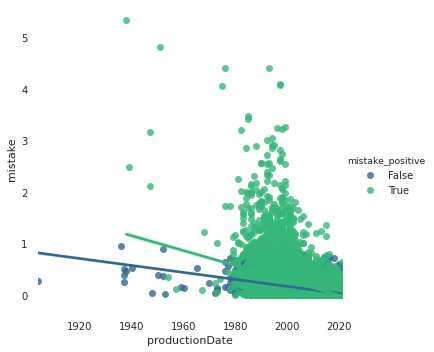

In [201]:
# Создаем вспомогательный датафрейм для анализа ошибок сделанных ручным стэкингом
for_analysis = data.loc[test_index].copy()
for_analysis['preds'] = np.exp(M_STACK_preds)
for_analysis['mistake'] = (for_analysis.preds-for_analysis.eur_price)/for_analysis.eur_price
for_analysis['mistake_positive'] = for_analysis.mistake.apply(lambda x: True if x>0 else False)
for_analysis['mistake'] = np.abs(for_analysis.mistake)
display(for_analysis.sort_values(by='mistake', ascending=False).head(10))
sns.lmplot(data=for_analysis, x='productionDate', y='mistake', hue='mistake_positive', palette = 'viridis')

Ошибка в предсказаниях растет с возрастом авто, приемущественно в большую сторону. Имеет смысл ограничить возможную ошибку, взяв макимальное и минимальное значения из тренировочной выборки как лимит.

In [202]:
# Вспомогательных словарь для более быстрой обработки
mapping_dict = {}
for year in tqdm(for_analysis['productionDate'].unique()):
    relevant_data = data[(data.train==1)&(data.productionDate==year)]['eur_price']
    mapping_dict[year] = {'price_max':relevant_data.max(), 'price_min':relevant_data.min()}

In [203]:
# Функция проверяет является ли предсказание выбросом по году и возвращает корректое значение
def limits(row):
    year = row['productionDate']
    price_max = mapping_dict[year]['price_max']
    price_min = mapping_dict[year]['price_min']
    prediction = row['preds']
    if prediction > price_max:
        return price_max
    elif prediction < price_min:
        return price_min
    else:
        return prediction


Изменение MAPE: -0.00025565182093600924


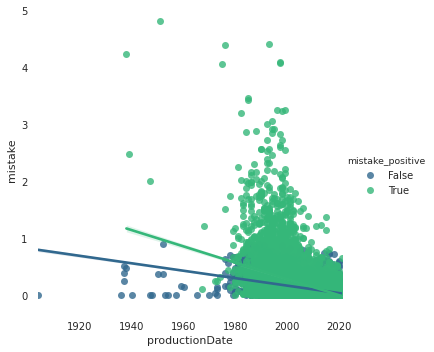

In [204]:
# Применение функции, визуализация
for_analysis['preds'] = for_analysis.progress_apply(limits, axis=1)
for_analysis['mistake'] = (for_analysis.preds-for_analysis.eur_price)/for_analysis.eur_price
for_analysis['mistake_positive'] = for_analysis.mistake.apply(lambda x: True if x>0 else False)
for_analysis['mistake'] = np.abs(for_analysis.mistake)
print('Изменение MAPE:',(MAPE(for_analysis['eur_price'], for_analysis['preds'])-M_STACK_MAPE))
sns.lmplot(data=for_analysis, x='productionDate', y='mistake', hue='mistake_positive', palette = 'viridis')

Метрика немного снизилась.

## Курс

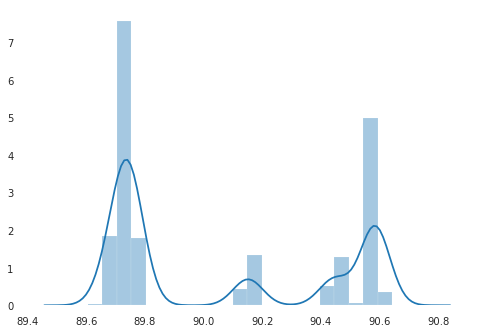

In [209]:
# Визуализация курса
sns.distplot(for_analysis.rur_price/for_analysis.eur_price, kde=True)

Предпологая, что пересчет цены в рублях не происходит постоянно, возьмем курс на среднюю дату выгрузки.

In [205]:
pd.to_datetime(data[data.train==0].parsing_unixtime.mean() ,unit='s')

Timestamp('2020-10-21 13:25:33.619356394')

Курс евро по ЦБ РФ:
- 91.5603

## Rounding

In [206]:
# Тестирование округлений от десятков до сотен тысяч рублей
for_processing = pd.DataFrame({'degree':[x for x in range(1,6)]})
for_processing['MAPE'] = for_processing.degree.apply(lambda x: MAPE(for_analysis['rur_price'], (np.round((for_analysis['preds']*91.5603)/(10**x)))*(10**x)))
for_processing[for_processing.MAPE==for_processing.MAPE.min()]

,degree,MAPE
2,3,0.1367


Наиболее точно округление до десятков тысяч рублей.

## Итог:

In [217]:
# Вспомогательные словари для более быстрой обработки
sell_id_year_dict = {}
for i in tqdm(data[data.train==0].index):
    sell_id_year_dict[data.loc[i]['sell_id']] = data.loc[i]['productionDate']
sell_id_year_dict

mapping_dict = {}
for year in tqdm(data[data.train==0]['productionDate'].unique()):
    relevant_data = data[(data.train==1)&(data.productionDate==year)]['eur_price']
    mapping_dict[year] = {'price_max':relevant_data.max(), 'price_min':relevant_data.min()}

In [218]:
# Функция пост-обработки каждого результата
def post_proc(row):
    year = sell_id_year_dict[row['sell_id']]
    price_max = mapping_dict[year]['price_max']
    price_min = mapping_dict[year]['price_min']
    prediction = row['price']
    
    step_1 = np.exp(prediction)
    if step_1 > price_max:
        step_2 = price_max
    elif step_1 < price_min:
        step_2 = price_min
    else:
        step_2 = step_1
    step_3 = step_2*91.5603
    return (np.round(step_3/(10**4)))*(10**4)

# Submission

## CatBoost

In [219]:
df = data.copy()

# Кодирование
LE = LabelEncoder()
for col in bin_cols+cat_cols:
    if df[col].dtype == object:
        df[col] = df[col].fillna('Non_specified')
        df[col] = df[col].apply(lambda x: str(x))
        LE.fit(df[col])
        df[col] = LE.transform(df[col])

# Разделение выборки
train = df[df.train==1]
valid = df[df.train==0]
valid_sell_id = valid.sell_id

X = train[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values
y = train['eur_price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RS)
X_valid = valid[sorted(bin_cols+cat_cols+num_cols)].drop(['rur_price', 'eur_price', 'usd_price'], axis=1).values

In [220]:
# Создание модели
model = CatBoostRegressor(iterations = 10000,
                          random_seed = RS,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True)

In [221]:
# Предсказание
valid_preds = model.predict(X_valid)

In [222]:
submission = pd.DataFrame({'sell_id': valid_sell_id, 
                           'price': valid_preds})
submission['sell_id'] = submission.sell_id.apply(lambda x: int(x))
submission['price'] = submission.progress_apply(post_proc, axis=1)
submission.sample(5)

,sell_id,price
106280,1101333529,1070000.0000
105185,1100566474,800000.0000
99373,1101155755,1830000.0000
107167,1101328073,1120000.0000
100467,1101306763,1250000.0000


In [223]:
# Проверка на пропущенные значения
submission[submission.price.isna()==True]

,sell_id,price


In [224]:
# Проверка на нулевые значения
submission[submission.price==0]

,sell_id,price


In [225]:
submission.to_csv('CB_submission.csv', index=False)

## Остальные алгоритмы

In [227]:
for key in tqdm(estimators_dict.keys()):
    est_submission = estimators_dict[key]['submission']
    est_submission['price'] = est_submission.progress_apply(post_proc, axis=1)
    est_submission.to_csv(key+'_submission.csv', index=False)

# Результаты:

In [1]:
import pandas as pd
kaggle_results = pd.DataFrame({'MAPE':[17.84365, 17.77150, 13.48137, 17.25766, 20.53338, 13.39662, 12.23734, 28.13552, 16.88065]},
                             index = ['CatBoost', 'Ручной stacking', 'Stacking Regressor', 'Light GBM', 
                                      'Gradient Boosting', 'Extra Trees', 'Random Forest', 
                                      'Linear regression', 'Decision Tree'])
kaggle_results.sort_values(by='MAPE')

,MAPE
Random Forest,12.23734
Extra Trees,13.39662
Stacking Regressor,13.48137
Decision Tree,16.88065
Light GBM,17.25766
Ручной stacking,17.77150
CatBoost,17.84365
Gradient Boosting,20.53338
Linear regression,28.13552


Наилучшим образом себя показал Random Forest.